## Step 1. 데이터 다운로드 (클라우드 유저용)

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

## Step 2. 데이터 정제 및 토큰화

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook
import random

import sentencepiece as spm
from konlpy.tag import Mecab

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    # [[YOUR CODE]]
    cleaned_corpus = list(set(zip(kor, eng)))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [3]:
def preprocess_sentence(sentence):
    # [[YOUR CODE]]
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-z가-힣?.!,]+", " ", sentence)
    # 문장부호 양옆에 공백 추가
    # () : 그룹 메타 문자 
    # \1 : 재참조 메타문자 
    # $1 : replace할때 사용
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백 제거
    #sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    # corpus를 txt파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/gd_transformer/dcorpus_{lang}.txt'
    with open(temp_file, 'w') as f:
        for row in corpus:
             f.write(str(row) + '\n')
    # Sentencepiece를 이용해    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
# 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함
en_tokenizer.set_encode_extra_options("bos:eos") 

True

In [5]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남김
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:04<00:00, 16013.82it/s]


## 모델링

#### 3-1. Positional Encoding

In [6]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

#### 3-2. Multi-Head Attention

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

#### 3-3. Position-wise Feed-Forward Network

In [8]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

#### 3-4. Encoder Layer¶

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### ### 3-5. Decoder Layer

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

#### 3-6. Encoder

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

#### 3-7. Decoder

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

#### 3-8. Transformer

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

#### 3-9. Masking

In [14]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## 훈련

In [15]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [16]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [17]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [18]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [19]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [20]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [21]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [22]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [38]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [41]:
# 학습
EPOCHS = 20
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                     dec_train[idx:idx+BATCH_SIZE],
                                                                     transformer,
                                                                     optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 매 Epoch 마다 제시된 예문에 대한 번역 생성
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

Epoch  1: 100%|██████████| 2081/2081 [07:58<00:00,  4.35it/s, Loss 4.9666]


Input: 오바마는 대통령이다.
Predicted translation: the president is .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are expected to be the latest .
Input: 커피는 필요 없다.
Predicted translation: they are not .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll at least people dead .


Epoch  2: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 3.8183]


Input: 오바마는 대통령이다.
Predicted translation: the president is .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have a huge crowd in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee no coffee is not .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were wounded when they were wounded .


Epoch  3: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 3.3185]


Input: 오바마는 대통령이다.
Predicted translation: president obama is a president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is located about .
Input: 커피는 필요 없다.
Predicted translation: no one need you need you need .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: five deaths were killed .


Epoch  4: 100%|██████████| 2081/2081 [07:53<00:00,  4.40it/s, Loss 2.7402]


Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a great white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city .
Input: 커피는 필요 없다.
Predicted translation: no one need to need for the coffee .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead wednesday .


Epoch  5: 100%|██████████| 2081/2081 [07:54<00:00,  4.39it/s, Loss 2.2067]


Input: 오바마는 대통령이다.
Predicted translation: president obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens .
Input: 커피는 필요 없다.
Predicted translation: cup need needs .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: people were dead .


Epoch  6: 100%|██████████| 2081/2081 [07:54<00:00,  4.38it/s, Loss 1.7442]


Input: 오바마는 대통령이다.
Predicted translation: obama will receive a message from president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee no matters .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others were wounded .


Epoch  7: 100%|██████████| 2081/2081 [07:47<00:00,  4.46it/s, Loss 1.3486]


Input: 오바마는 대통령이다.
Predicted translation: obama , obama , obama , obama , obama becomes president , obama , says
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens put up in the mountain ,
Input: 커피는 필요 없다.
Predicted translation: coffee no matter what is needed .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four people were dead and seven others attacked .


Epoch  8: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 1.0295]


Input: 오바마는 대통령이다.
Predicted translation: president obama , who s been a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are on the streets of new delhi .
Input: 커피는 필요 없다.
Predicted translation: coffee needs .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead wednesday when seven others died .


Epoch  9: 100%|██████████| 2081/2081 [07:54<00:00,  4.38it/s, Loss 0.7993]


Input: 오바마는 대통령이다.
Predicted translation: obama is also leader .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re burning in the san imf s home .
Input: 커피는 필요 없다.
Predicted translation: it was no match .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were dead wednesday on the other seven people were wounded .


Epoch 10: 100%|██████████| 2081/2081 [07:54<00:00,  4.39it/s, Loss 0.6429]


Input: 오바마는 대통령이다.
Predicted translation: president obama , who is also president clinton .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are fire in the city .
Input: 커피는 필요 없다.
Predicted translation: it needs need to go to need to need to need to need to need a coffee .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three seven people were killed or seven others .


Epoch 11: 100%|██████████| 2081/2081 [07:53<00:00,  4.40it/s, Loss 0.5414]


Input: 오바마는 대통령이다.
Predicted translation: obama won .
Input: 시민들은 도시 속에 산다.
Predicted translation: the places of the city fire starts
Input: 커피는 필요 없다.
Predicted translation: coffee needed .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were wounded when began .


Epoch 12: 100%|██████████| 2081/2081 [07:52<00:00,  4.40it/s, Loss 0.4716]


Input: 오바마는 대통령이다.
Predicted translation: president obama will bring president barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are hurt in the choose police .
Input: 커피는 필요 없다.
Predicted translation: coffee need no space .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when began seven others were seven others dead .


Epoch 13: 100%|██████████| 2081/2081 [07:53<00:00,  4.39it/s, Loss 0.4227]


Input: 오바마는 대통령이다.
Predicted translation: president obama will do a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are on the mountain in and in the san francisco city .
Input: 커피는 필요 없다.
Predicted translation: coffee need no need .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead wednesday .


Epoch 14: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 0.3862]


Input: 오바마는 대통령이다.
Predicted translation: obama president is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they fired tear gas .
Input: 커피는 필요 없다.
Predicted translation: coffee need a coffee .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and others wounded .


Epoch 15: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 0.3599]


Input: 오바마는 대통령이다.
Predicted translation: obama is obama , who s been a good president , obama said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are fire .
Input: 커피는 필요 없다.
Predicted translation: coffee no need .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead wednesday , the interior ministry said .


Epoch 16: 100%|██████████| 2081/2081 [07:45<00:00,  4.47it/s, Loss 0.3397]


Input: 오바마는 대통령이다.
Predicted translation: obama takes a edge .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are on a resident in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee need an needed coffee


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were seven dead wednesday .


Epoch 17: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 0.3239]


Input: 오바마는 대통령이다.
Predicted translation: obama also is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens were evacuated from their mountainous city .
Input: 커피는 필요 없다.
Predicted translation: coffee need needs march .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead wednesday .


Epoch 18: 100%|██████████| 2081/2081 [07:53<00:00,  4.39it/s, Loss 0.3081]


Input: 오바마는 대통령이다.
Predicted translation: president obama , , is a great president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is police .
Input: 커피는 필요 없다.
Predicted translation: coffee no need .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were seven dead .


Epoch 19: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 0.2968]


Input: 오바마는 대통령이다.
Predicted translation: obama will lose his support .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are only evacuated from the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee need needs .


  0%|          | 0/2081 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead and seven others were wounded .


Epoch 20: 100%|██████████| 2081/2081 [07:46<00:00,  4.46it/s, Loss 0.2853]


Input: 오바마는 대통령이다.
Predicted translation: obama president barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are evacuating
Input: 커피는 필요 없다.
Predicted translation: coffee no need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three people were killed in seven others between the seven dead .


In [23]:
transformer2 = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

Epoch  1: 100%|██████████| 2127/2127 [07:57<00:00,  4.45it/s, Loss 3.9361]


Input: 오바마는 대통령이다.
Predicted translation: obama is a huge victory .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

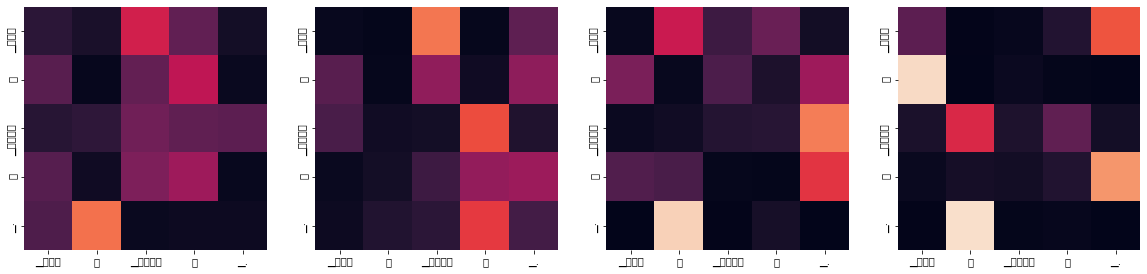

Encoder Layer 2


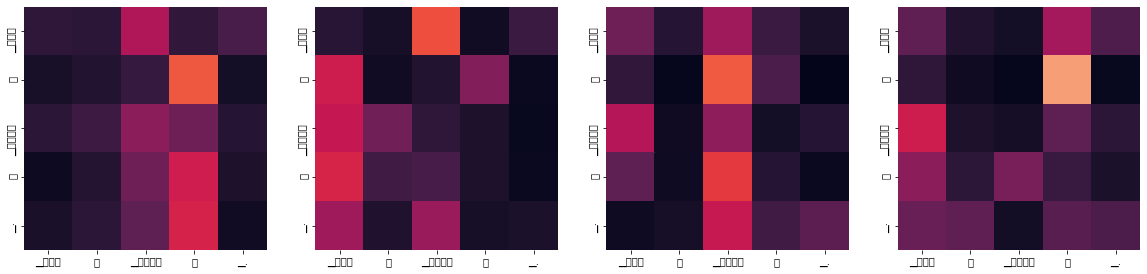

Decoder Self Layer 1


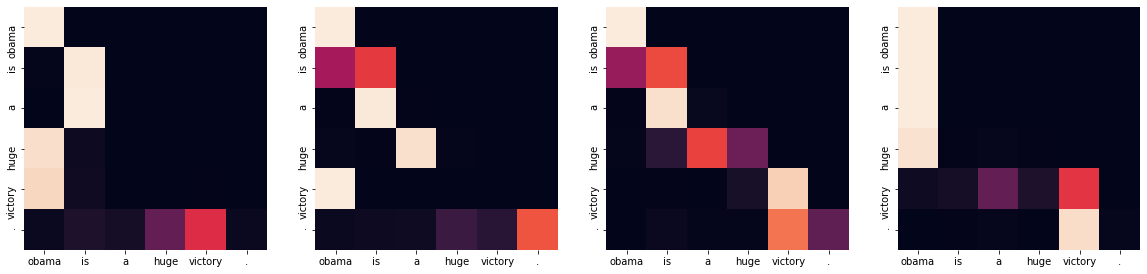

Decoder Src Layer 1


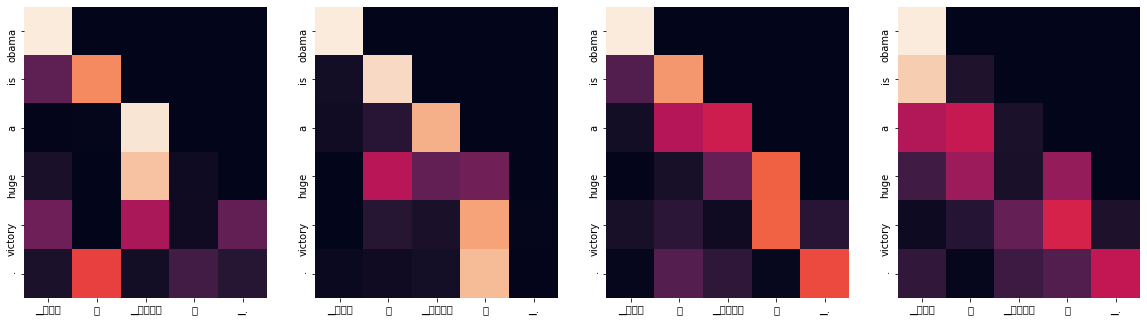

Decoder Self Layer 2


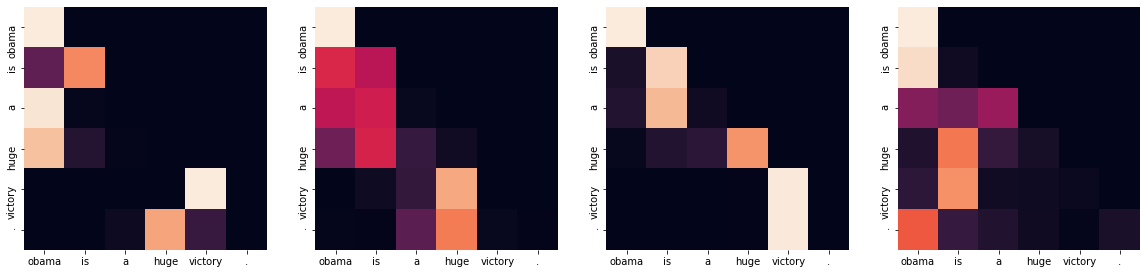

Decoder Src Layer 2


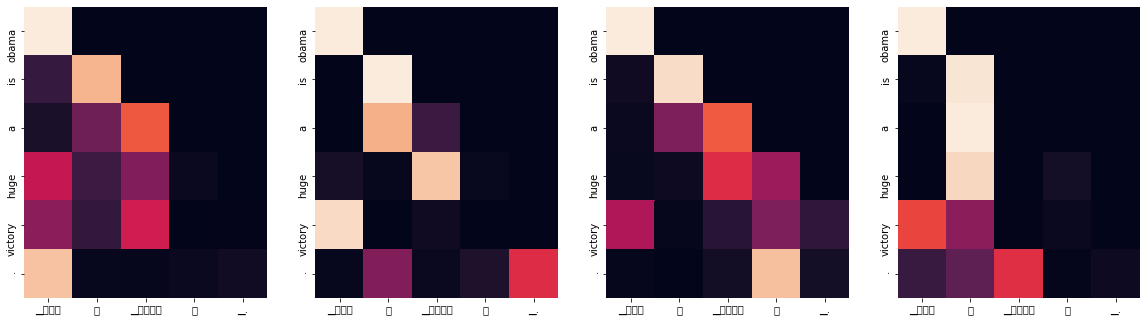

Input: 시민들은 도시 속에 산다.
Predicted translation: they fear the city s population .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_

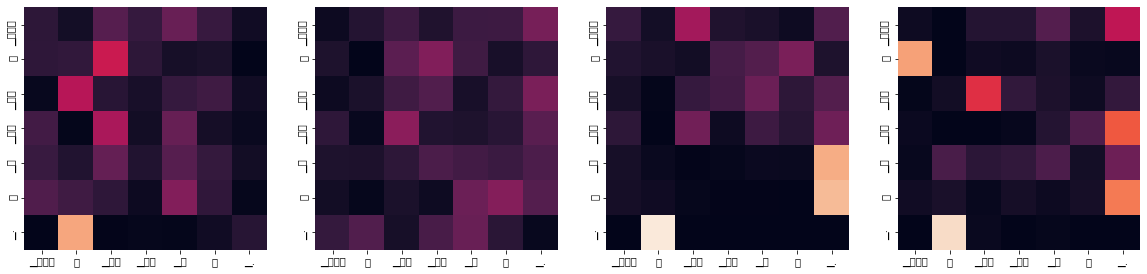

Encoder Layer 2


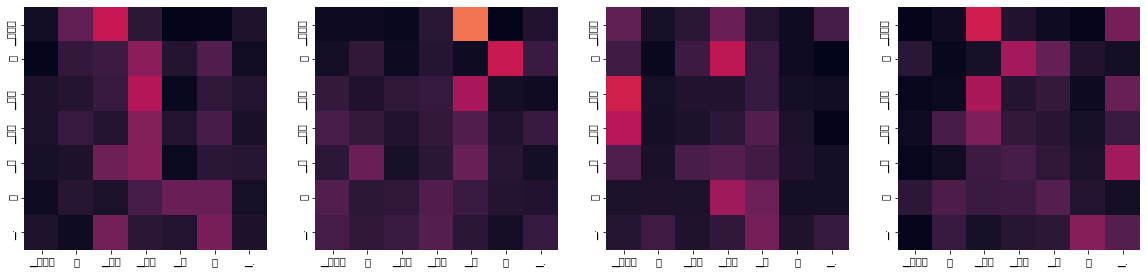

Decoder Self Layer 1


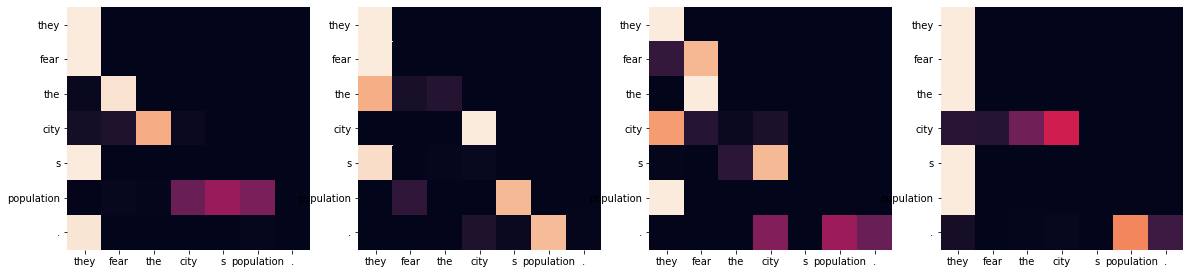

Decoder Src Layer 1


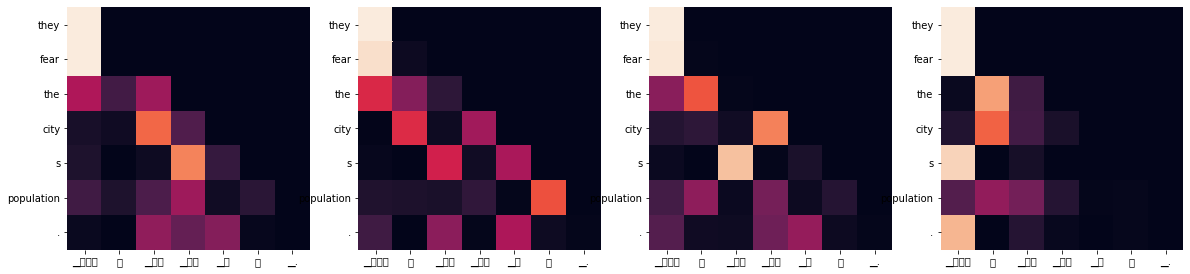

Decoder Self Layer 2


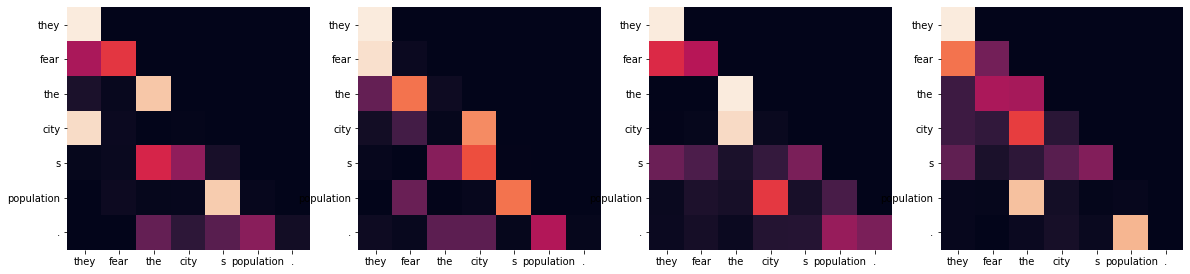

Decoder Src Layer 2


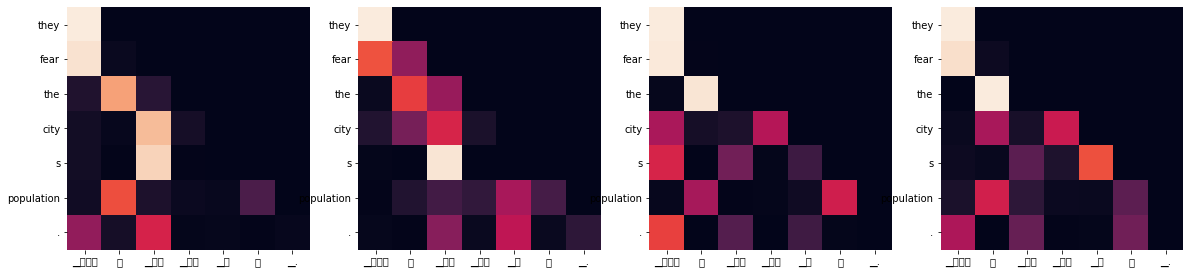

Input: 커피는 필요 없다.
Predicted translation: there is no reason for you .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_

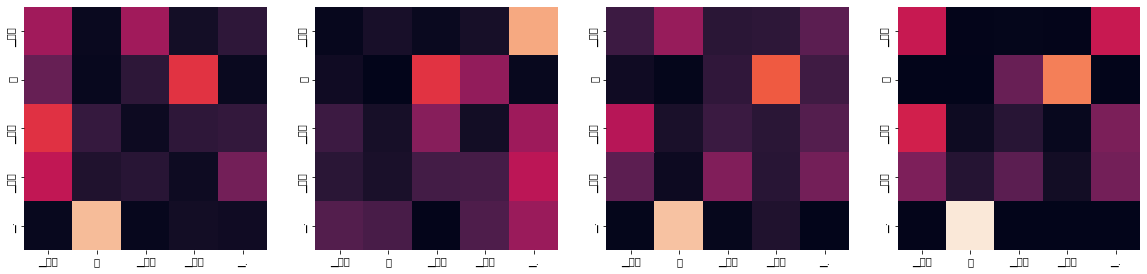

Encoder Layer 2


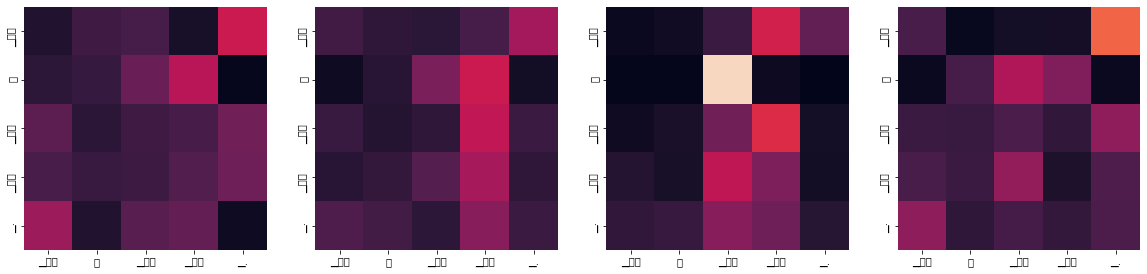

Decoder Self Layer 1


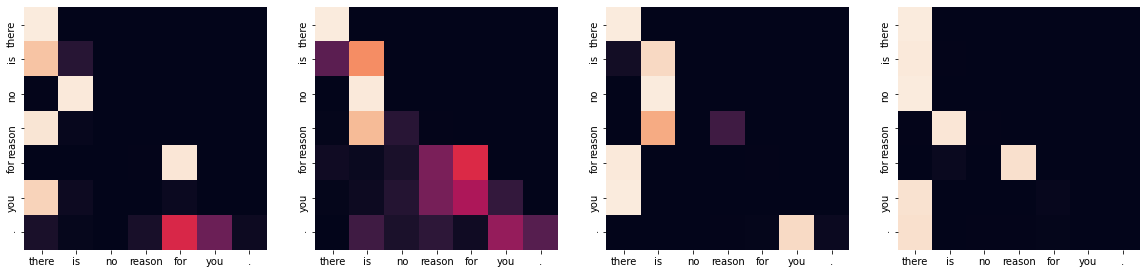

Decoder Src Layer 1


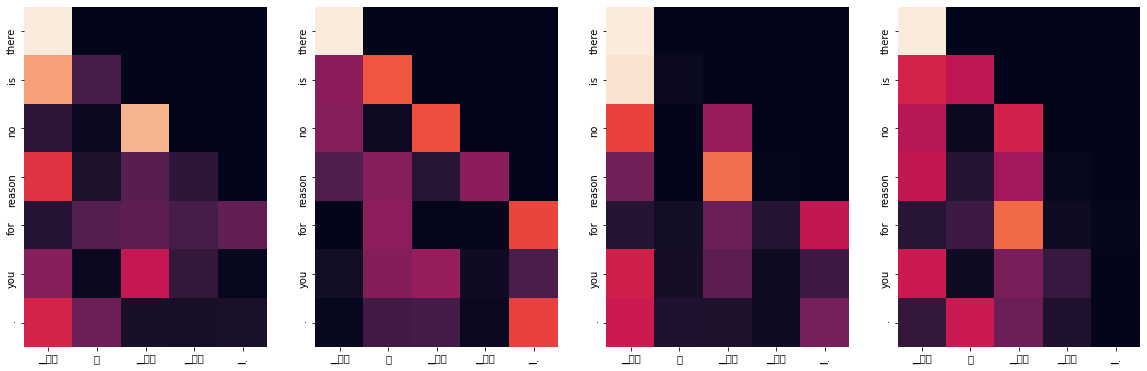

Decoder Self Layer 2


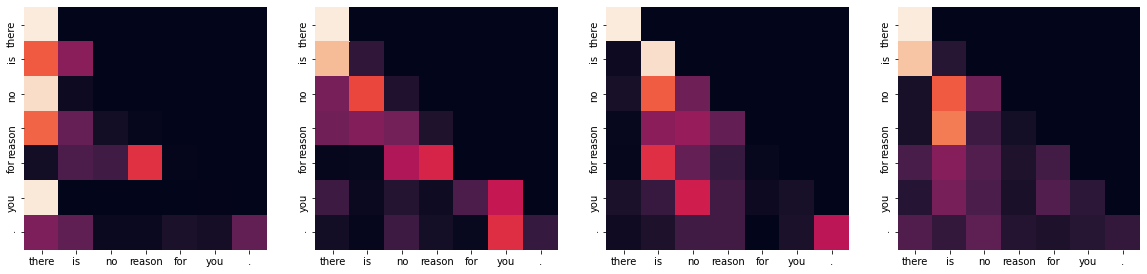

Decoder Src Layer 2


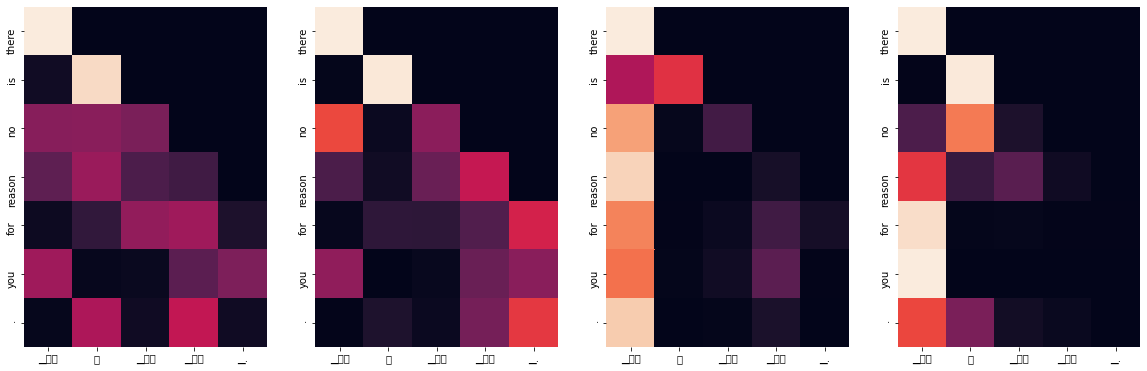

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll in the death toll in the deaths .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44273 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_

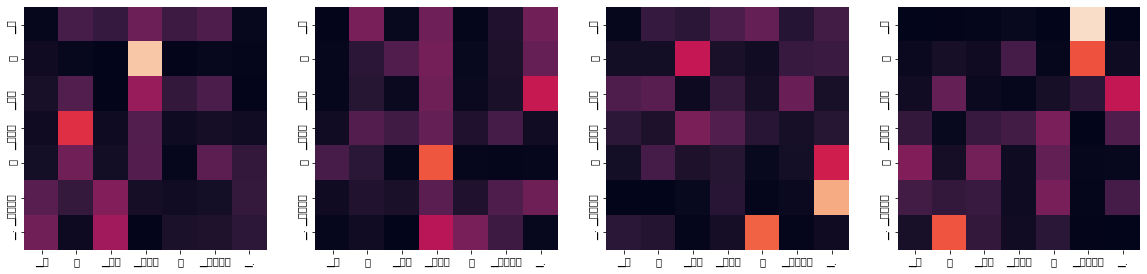

Encoder Layer 2


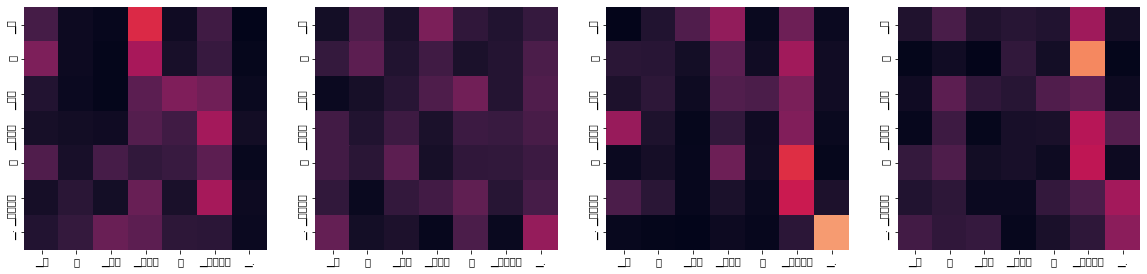

Decoder Self Layer 1


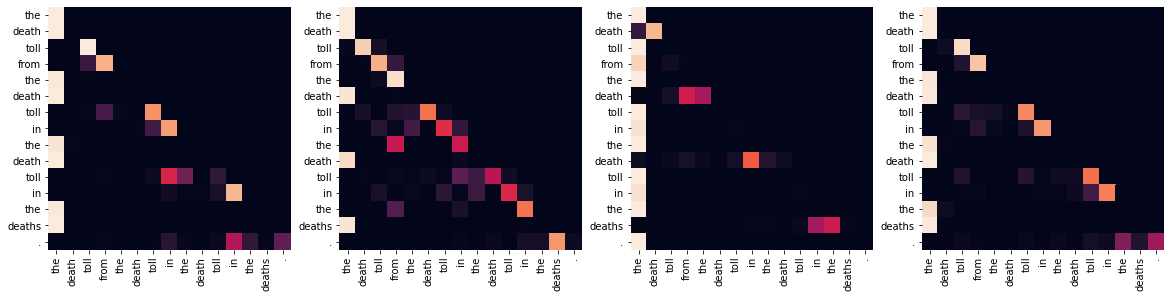

Decoder Src Layer 1


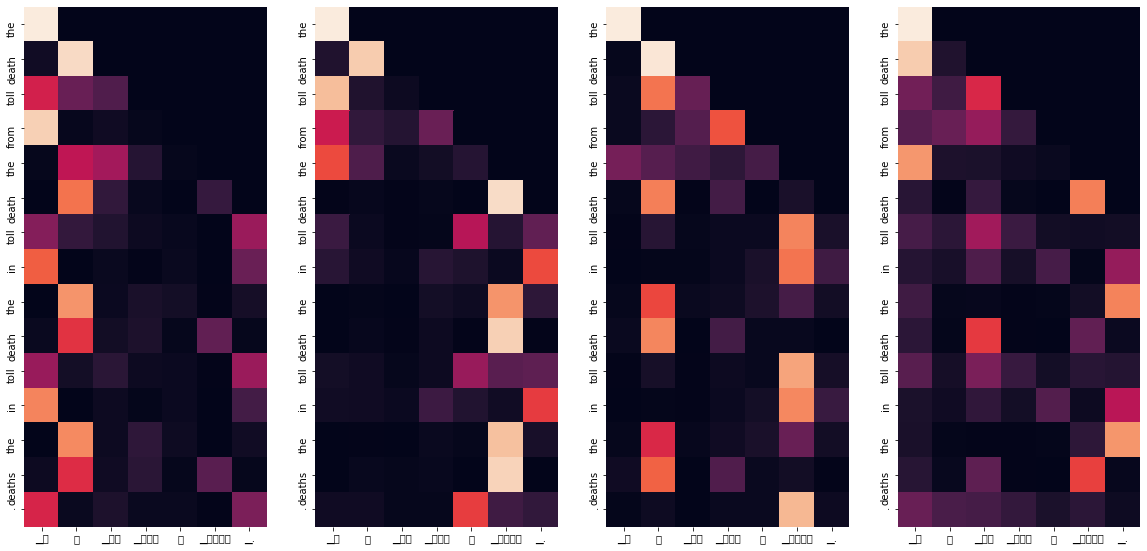

Decoder Self Layer 2


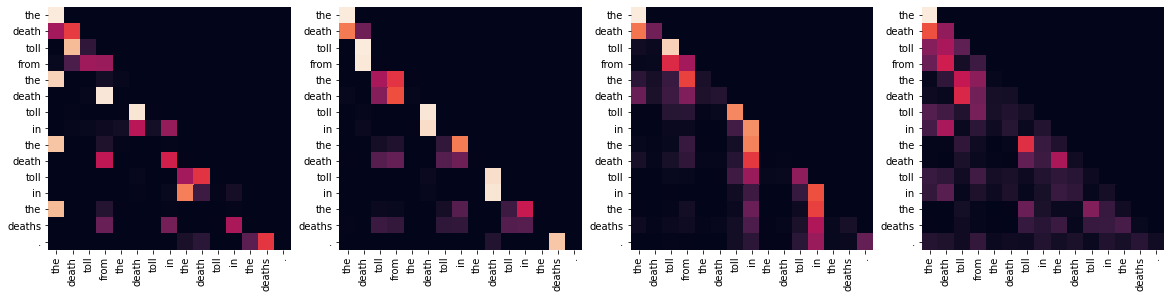

Decoder Src Layer 2


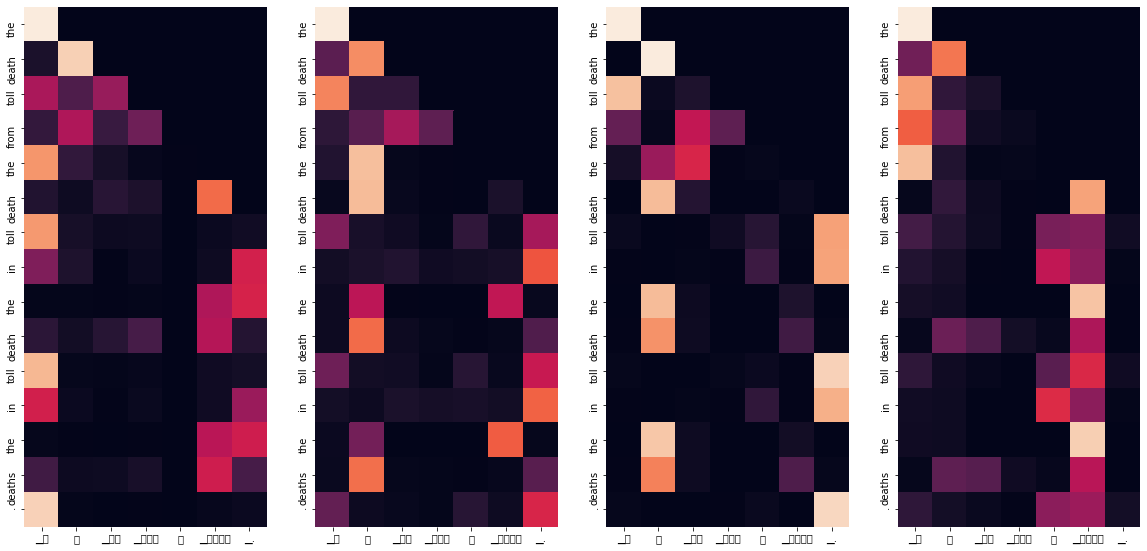

Epoch  2: 100%|██████████| 2127/2127 [08:05<00:00,  4.38it/s, Loss 3.4174]


Input: 오바마는 대통령이다.
Predicted translation: obama also is taking the president .
Encoder Layer 1


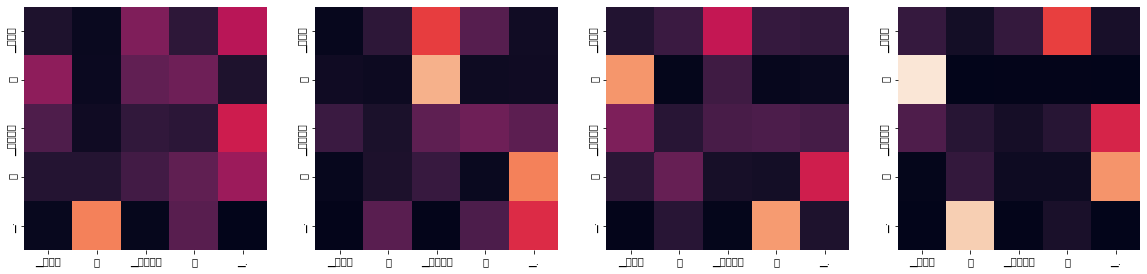

Encoder Layer 2


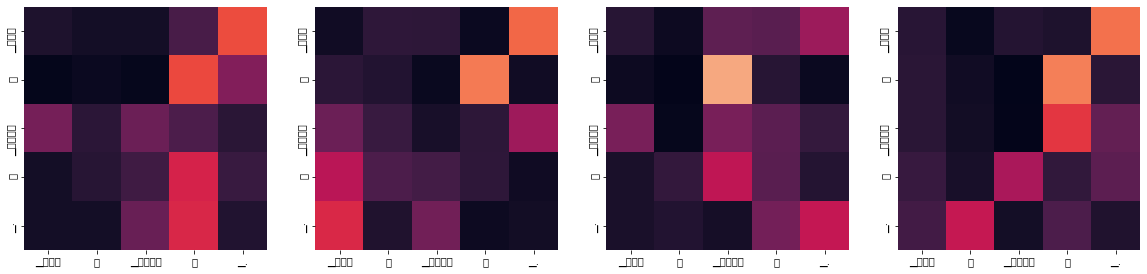

Decoder Self Layer 1


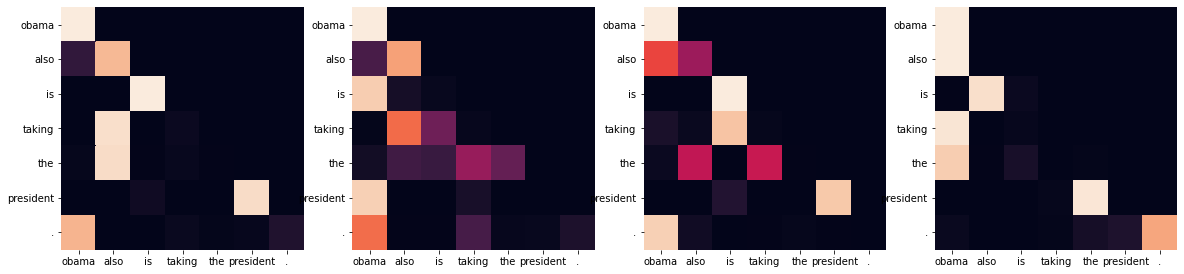

Decoder Src Layer 1


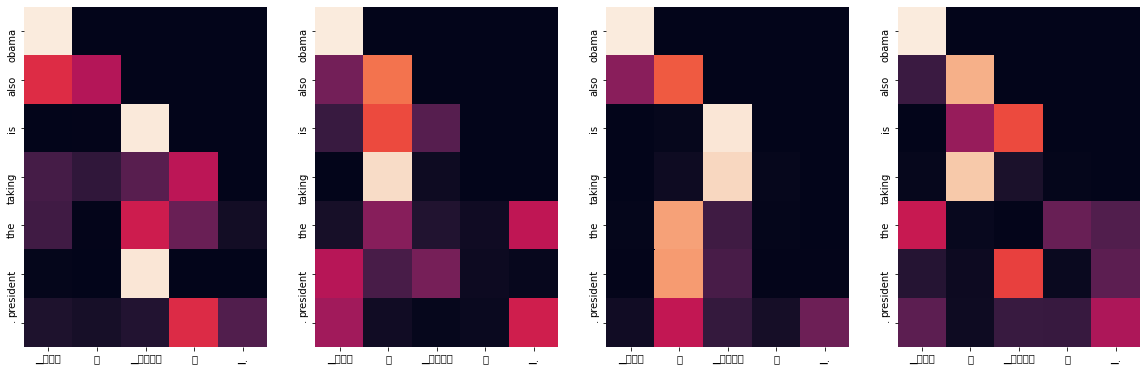

Decoder Self Layer 2


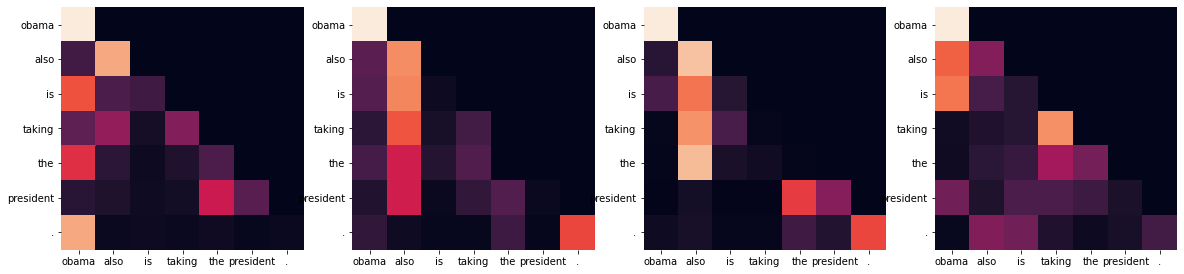

Decoder Src Layer 2


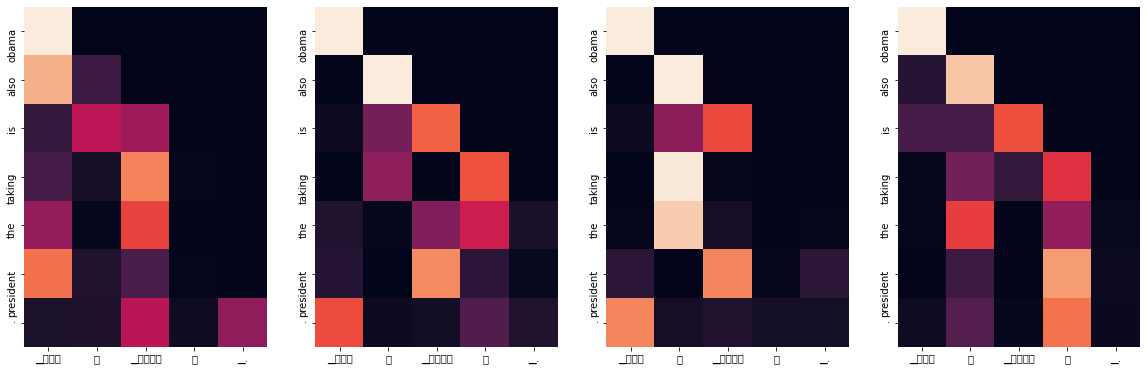

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s main city of mosul , is the city of , .
Encoder Layer 1


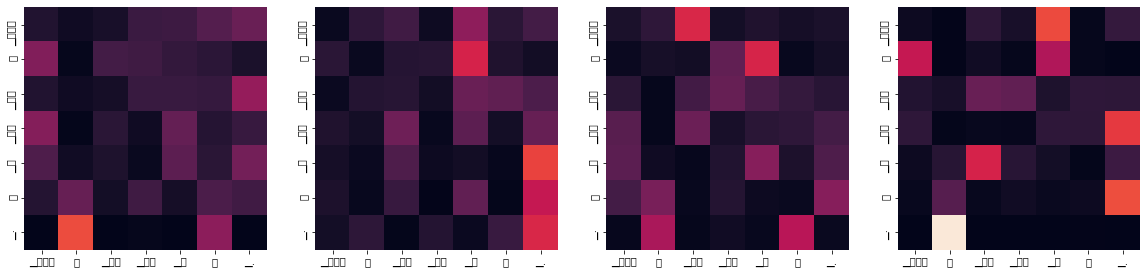

Encoder Layer 2


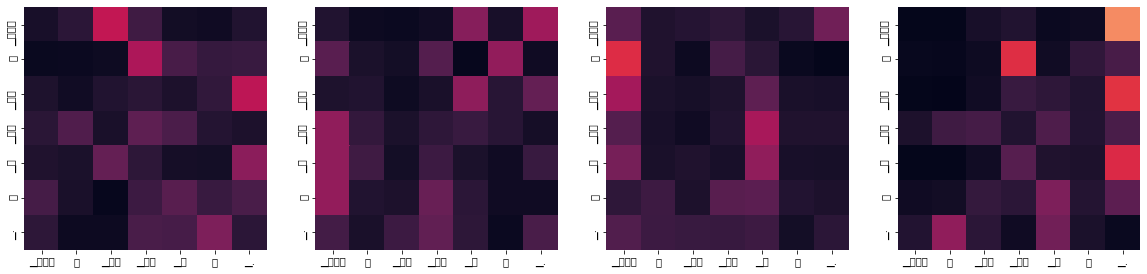

Decoder Self Layer 1


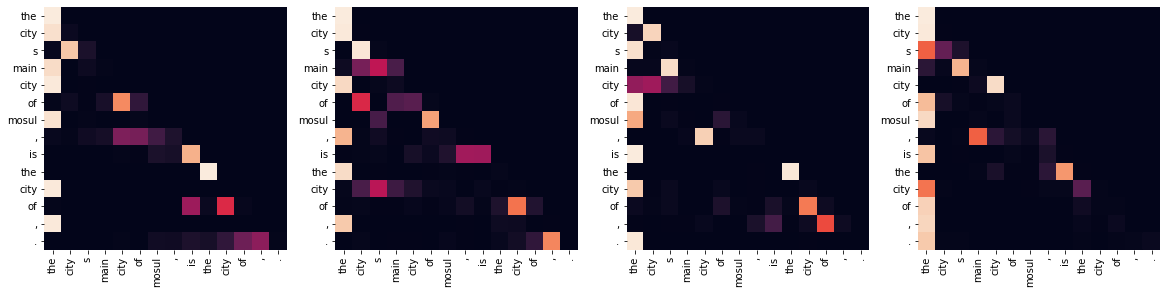

Decoder Src Layer 1


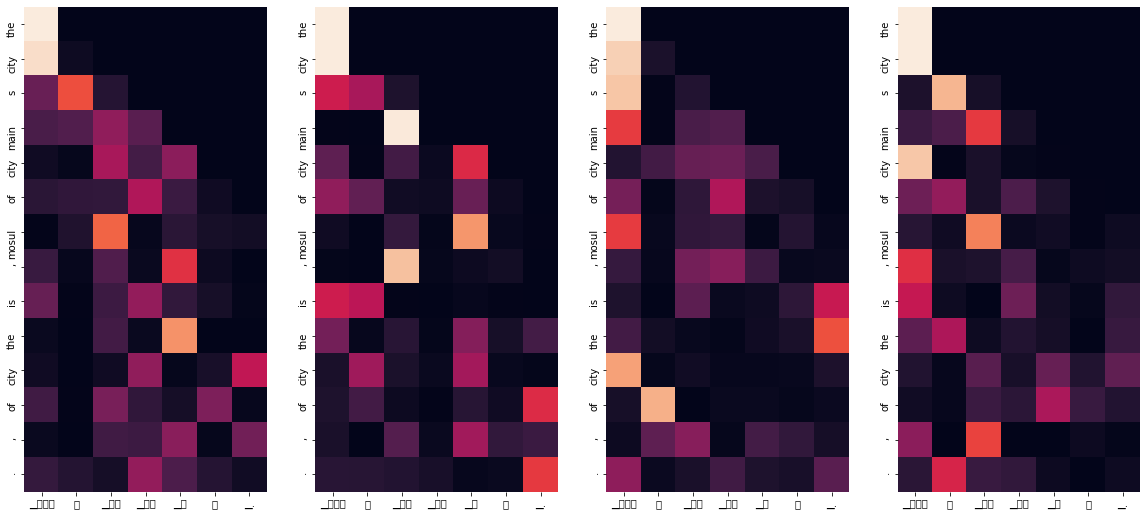

Decoder Self Layer 2


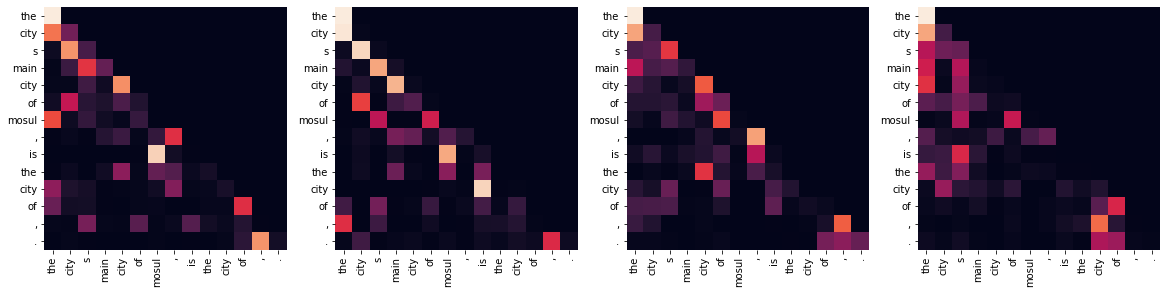

Decoder Src Layer 2


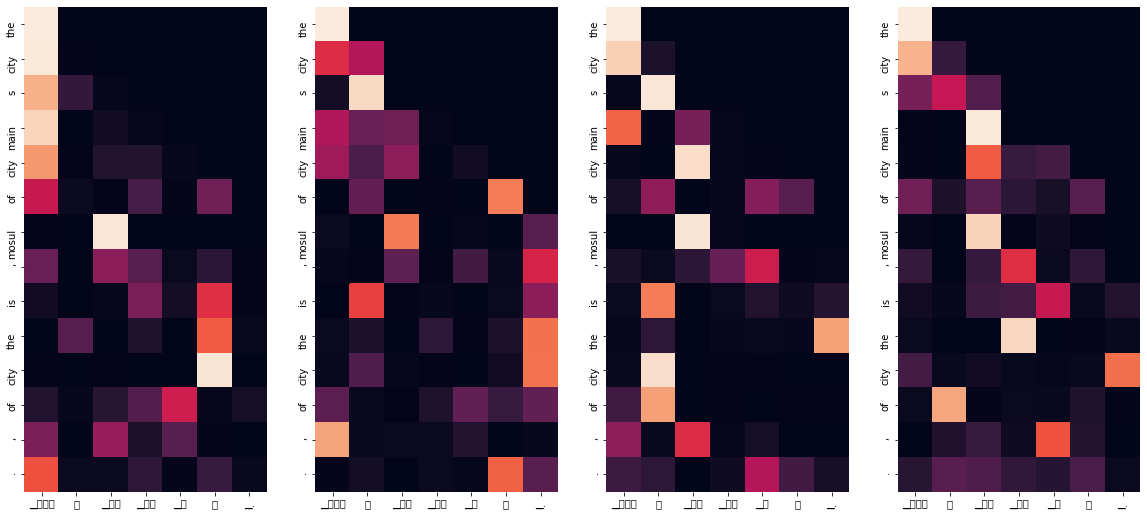

Input: 커피는 필요 없다.
Predicted translation: it s no longer , said .
Encoder Layer 1


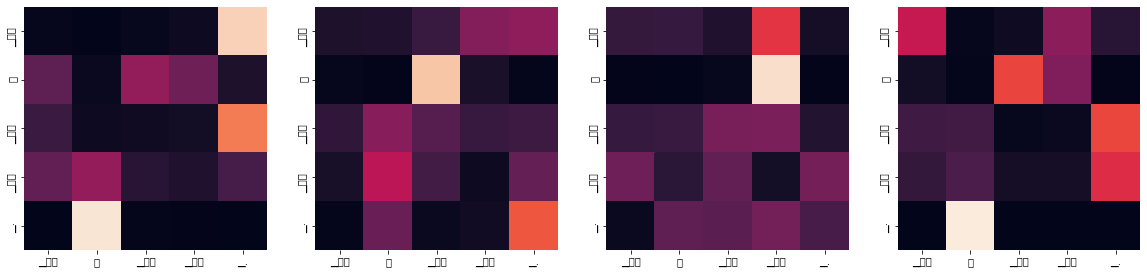

Encoder Layer 2


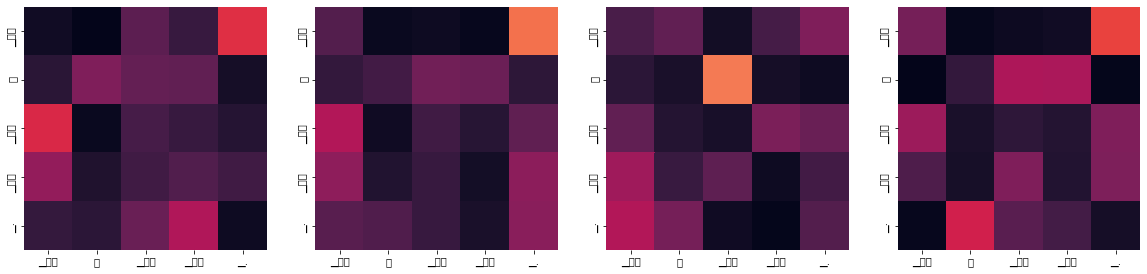

Decoder Self Layer 1


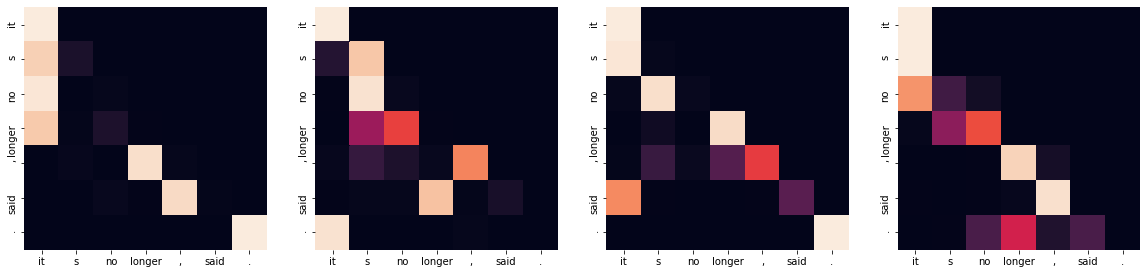

Decoder Src Layer 1


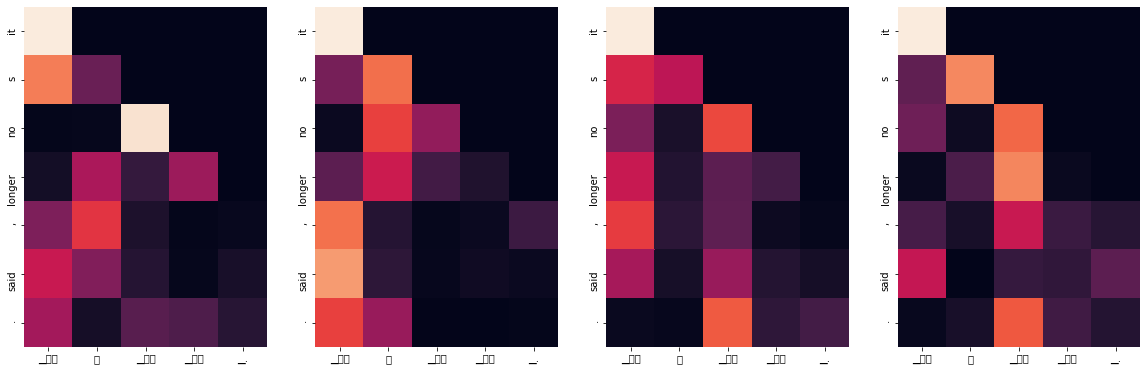

Decoder Self Layer 2


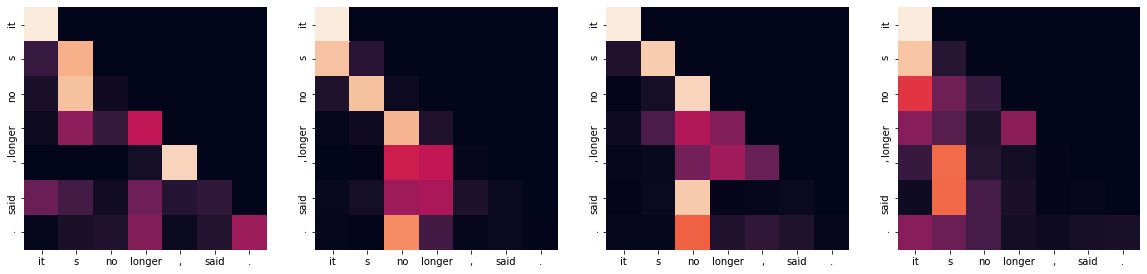

Decoder Src Layer 2


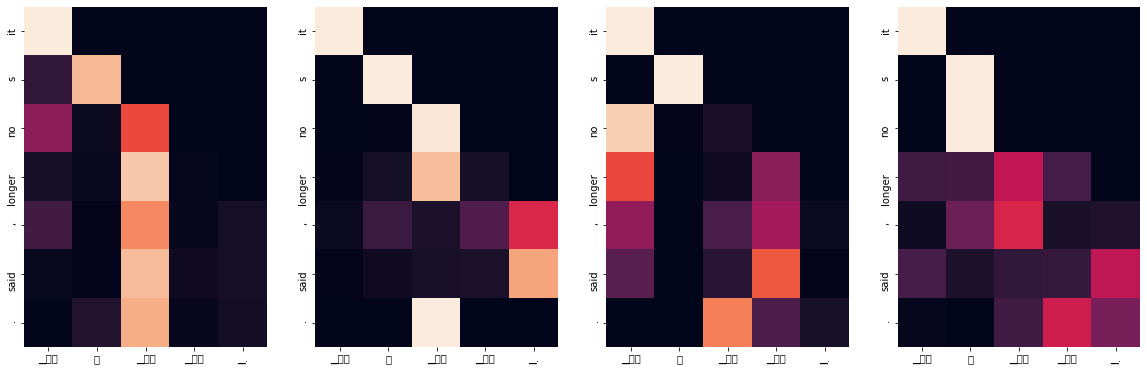

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine people died , seven people died .
Encoder Layer 1


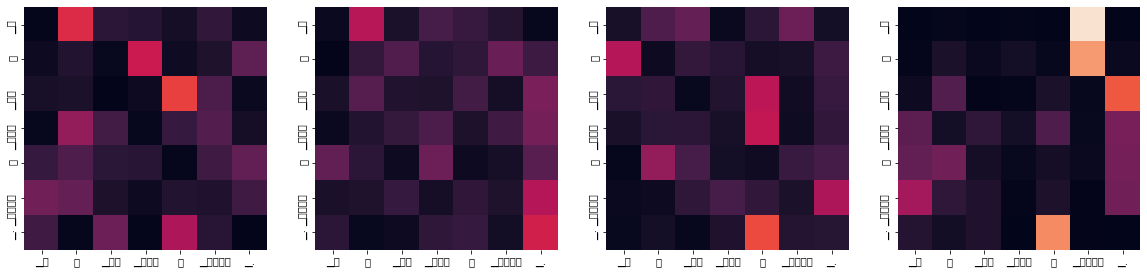

Encoder Layer 2


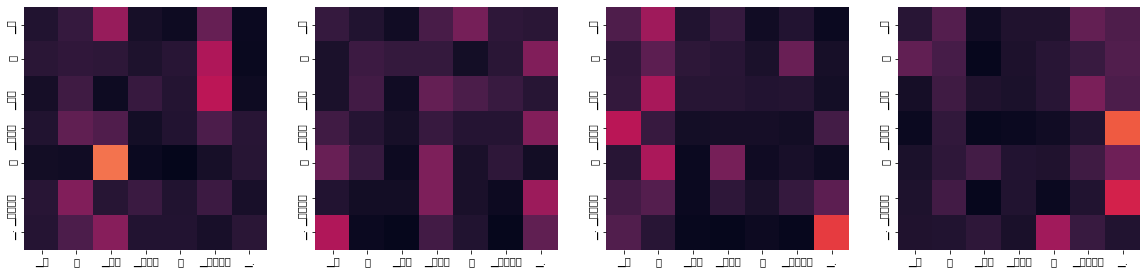

Decoder Self Layer 1


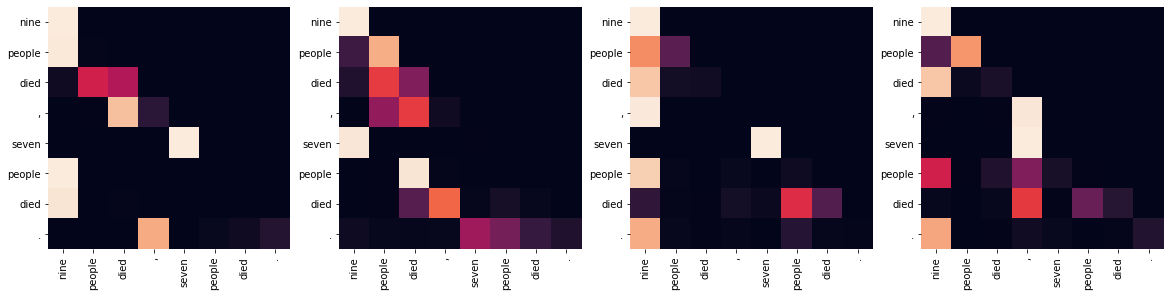

Decoder Src Layer 1


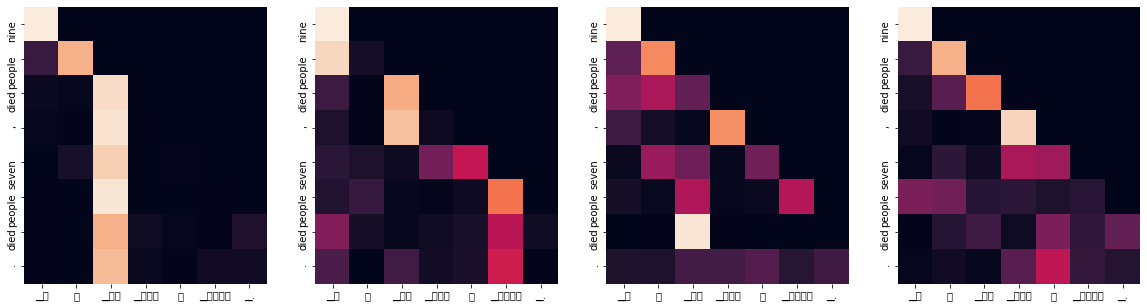

Decoder Self Layer 2


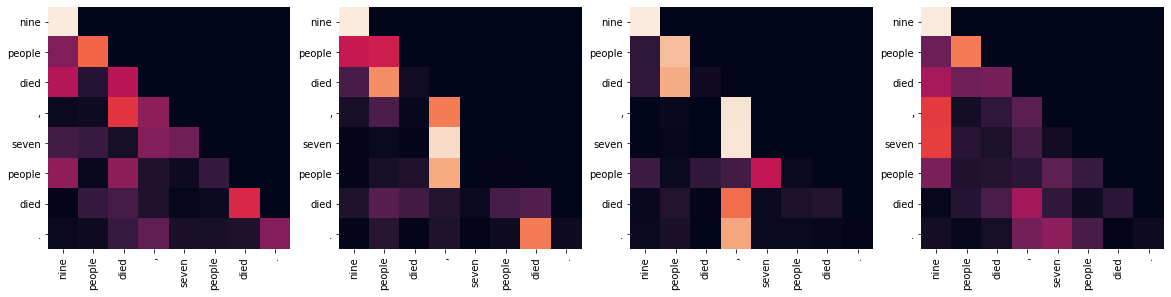

Decoder Src Layer 2


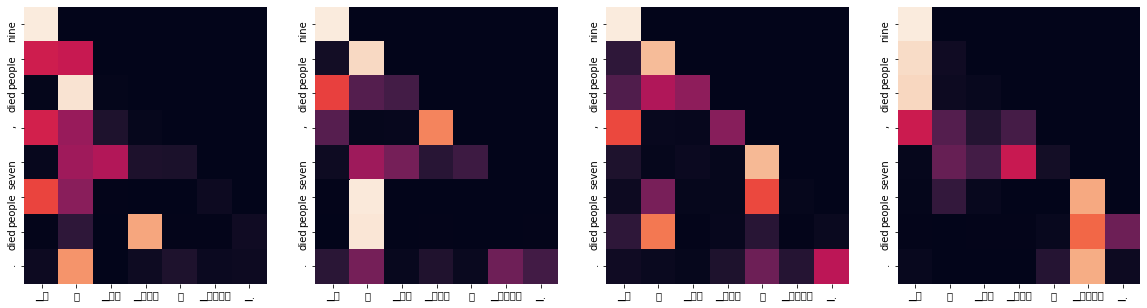

Epoch  3: 100%|██████████| 2127/2127 [08:05<00:00,  4.38it/s, Loss 2.8218]


Input: 오바마는 대통령이다.
Predicted translation: obama lost his presidential candidates .
Encoder Layer 1


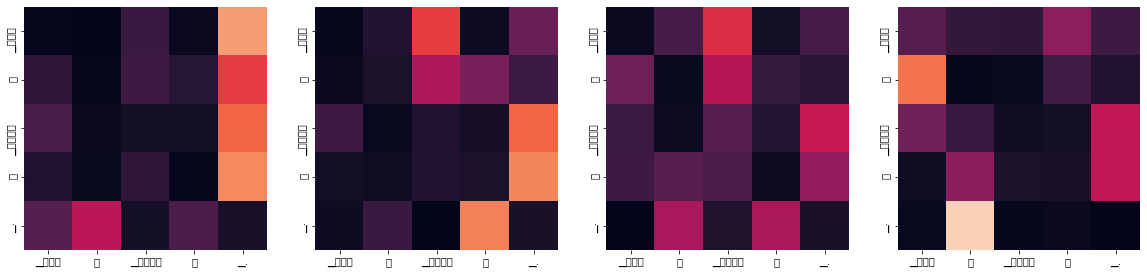

Encoder Layer 2


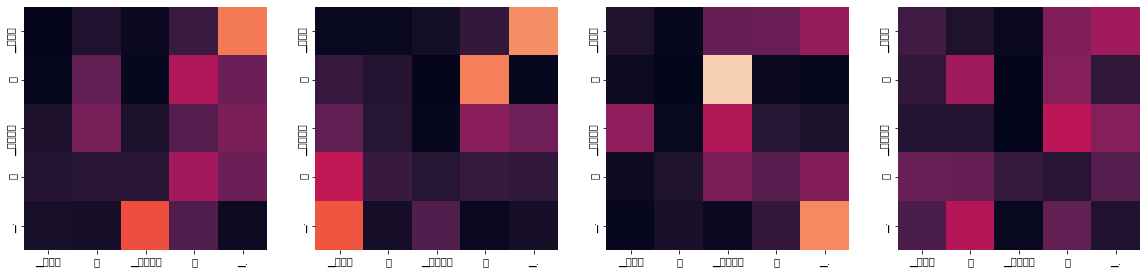

Decoder Self Layer 1


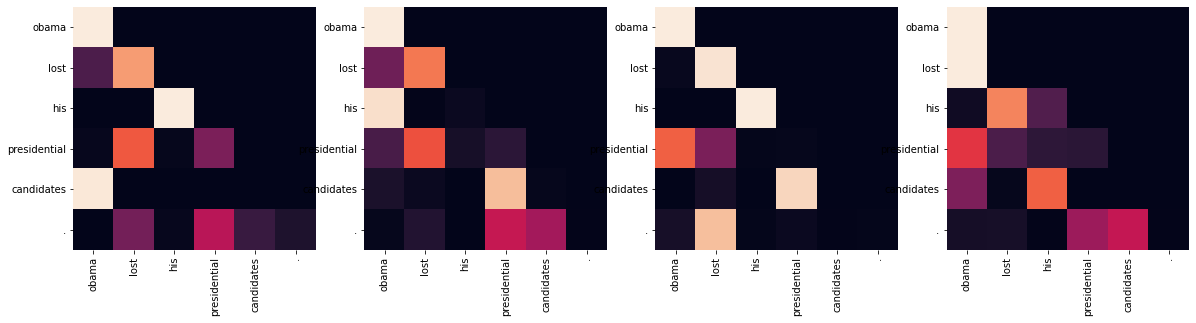

Decoder Src Layer 1


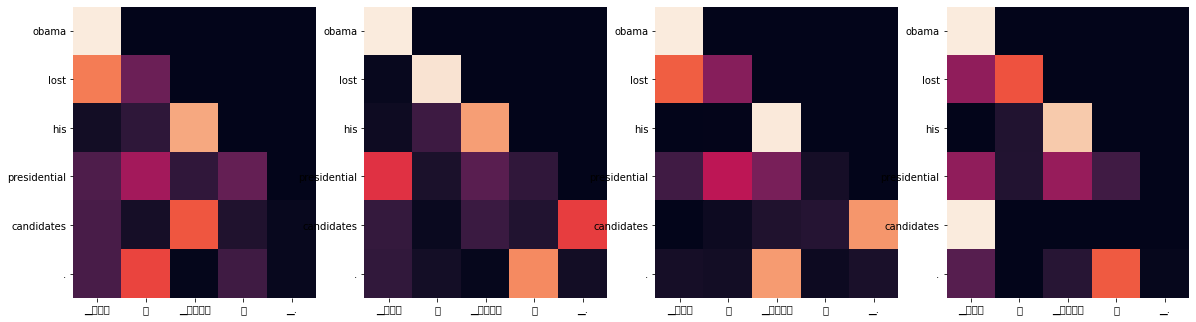

Decoder Self Layer 2


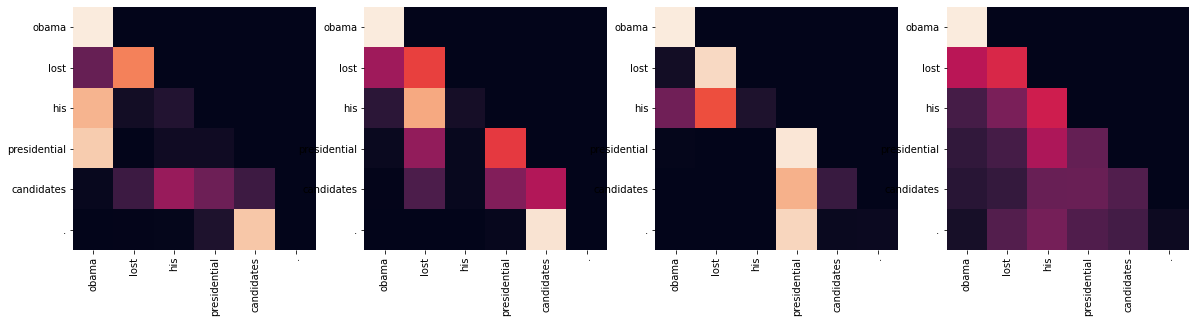

Decoder Src Layer 2


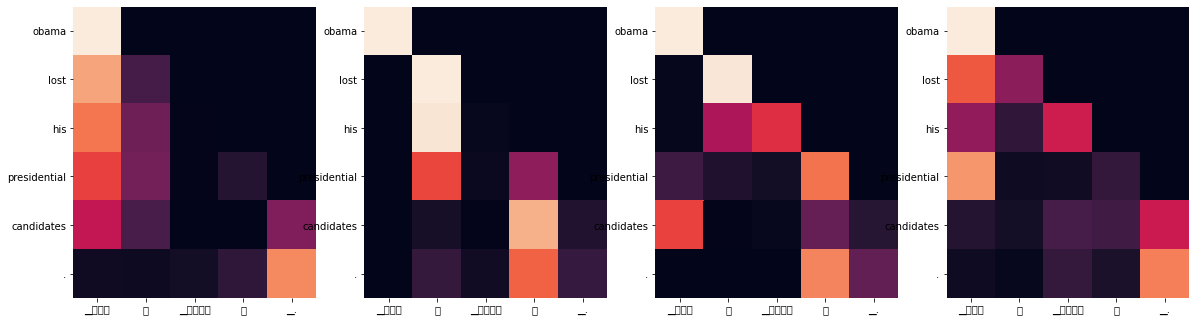

Input: 시민들은 도시 속에 산다.
Predicted translation: they are on the streets .
Encoder Layer 1


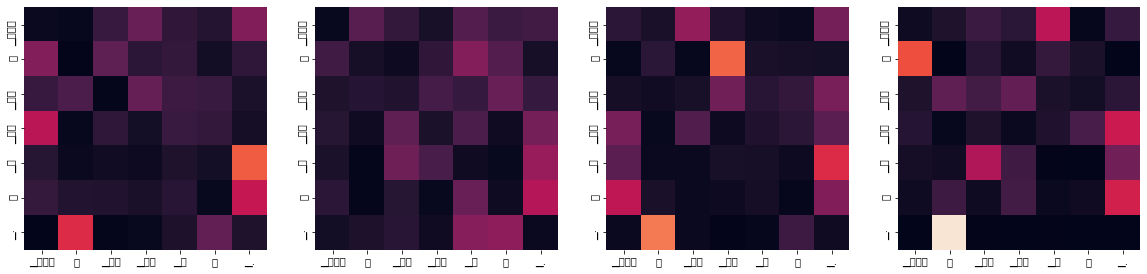

Encoder Layer 2


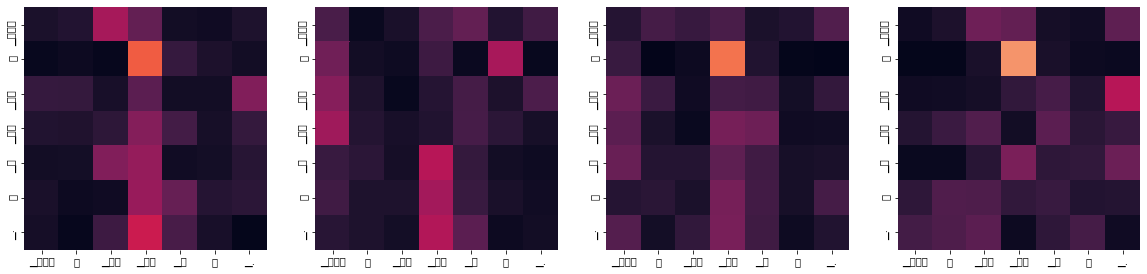

Decoder Self Layer 1


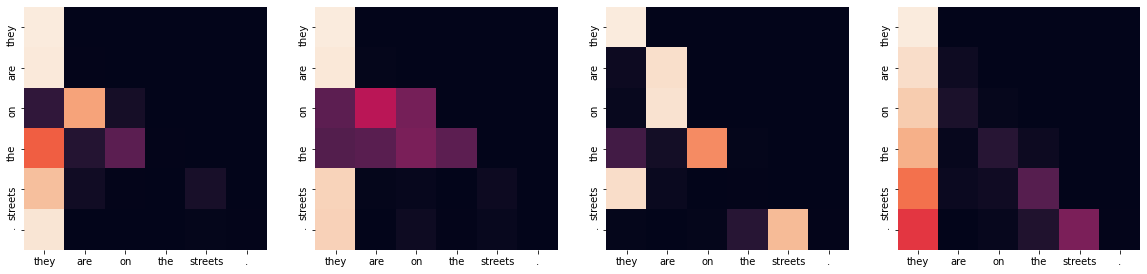

Decoder Src Layer 1


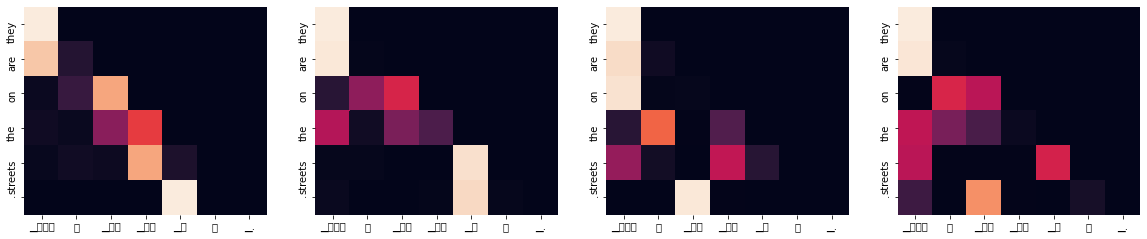

Decoder Self Layer 2


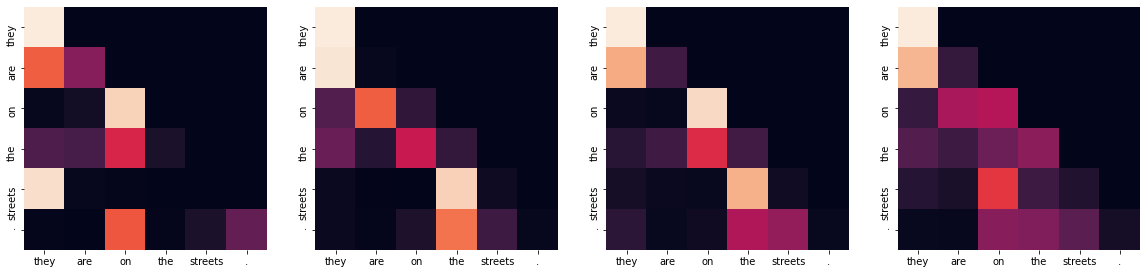

Decoder Src Layer 2


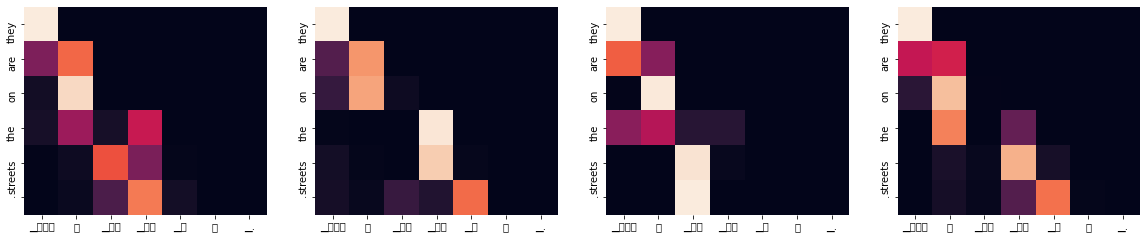

Input: 커피는 필요 없다.
Predicted translation: coffee
Encoder Layer 1


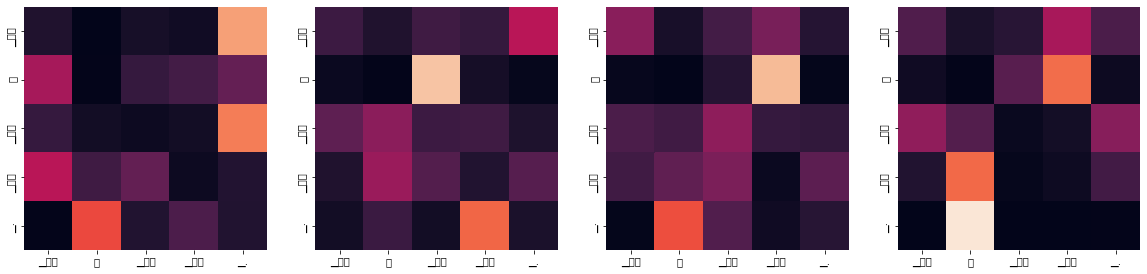

Encoder Layer 2


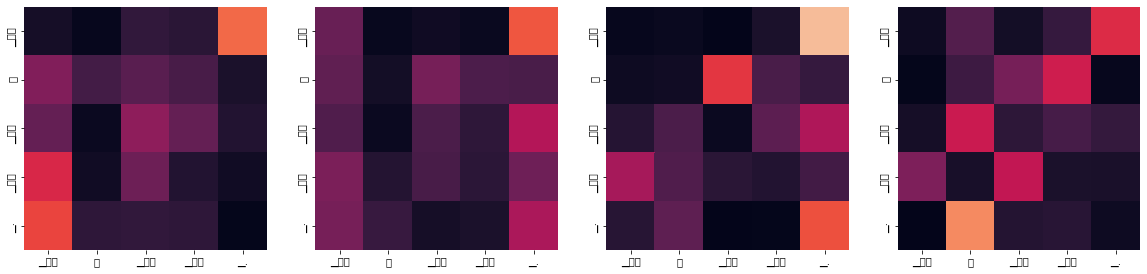

Decoder Self Layer 1


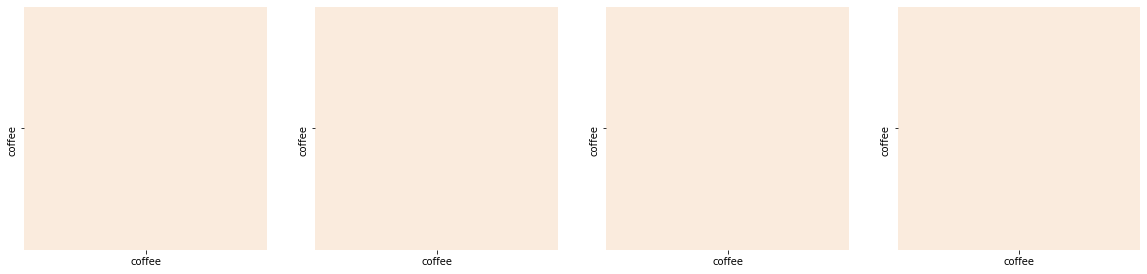

Decoder Src Layer 1


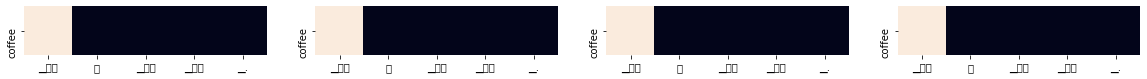

Decoder Self Layer 2


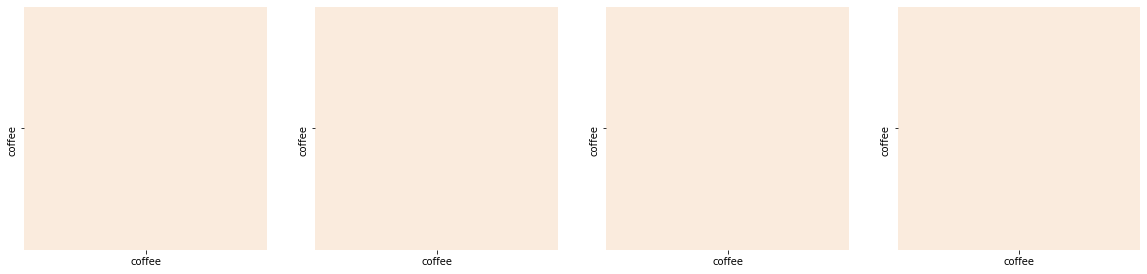

Decoder Src Layer 2


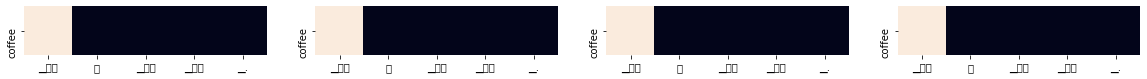

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on friday , people died in the death toll , the toll of the death toll , and the death toll was , according to the ministry of public affairs .
Encoder Layer 1


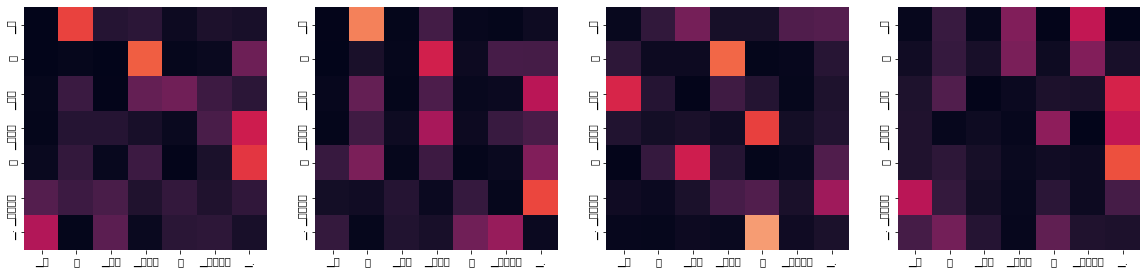

Encoder Layer 2


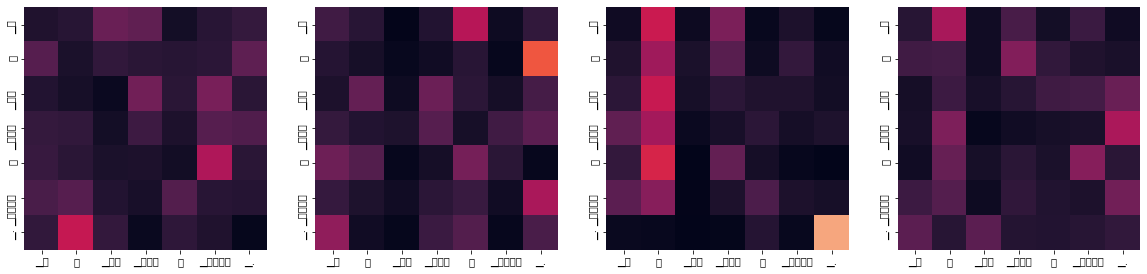

Decoder Self Layer 1


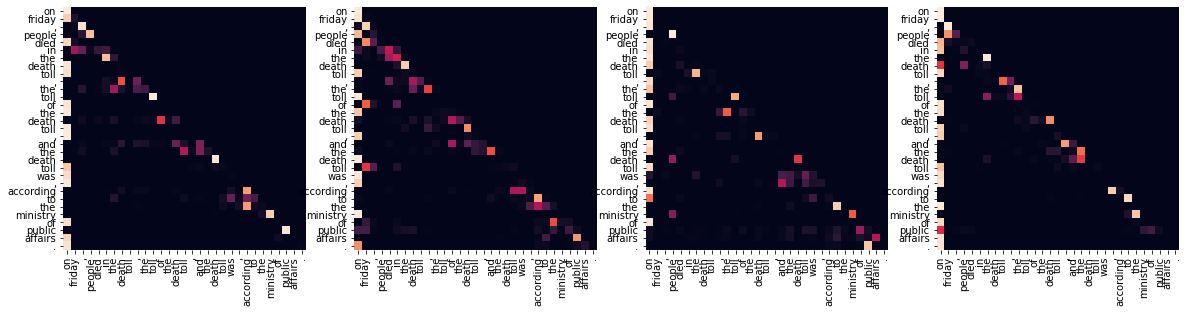

Decoder Src Layer 1


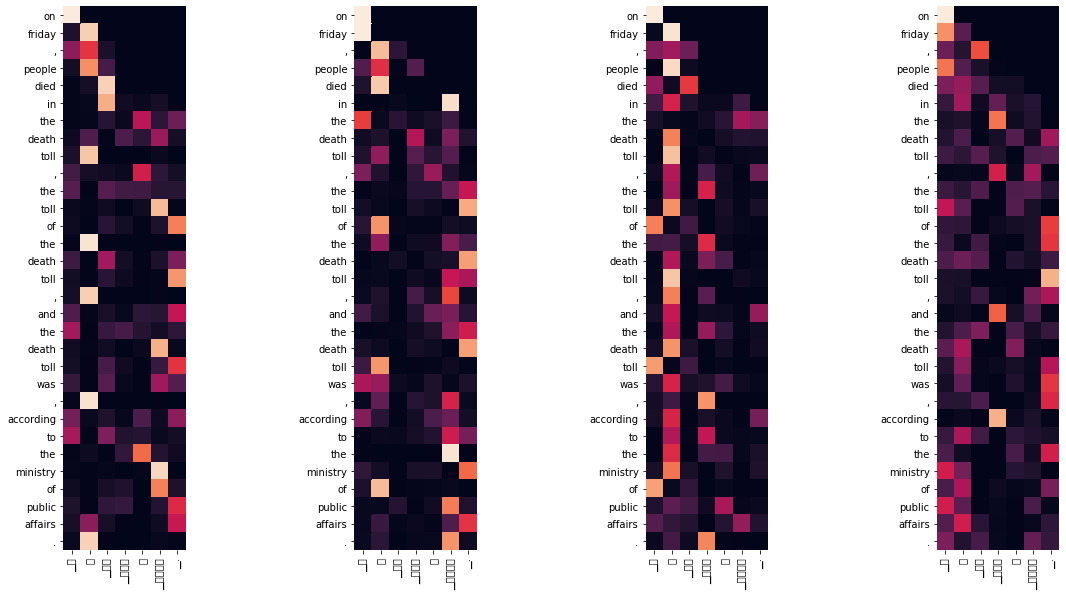

Decoder Self Layer 2


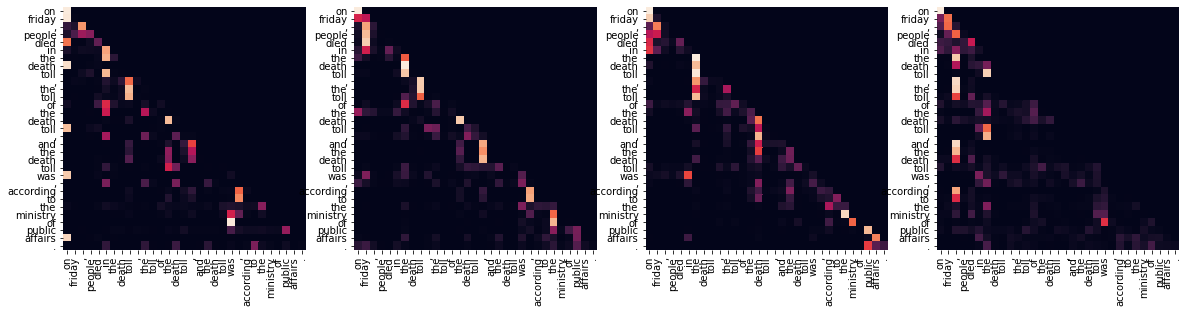

Decoder Src Layer 2


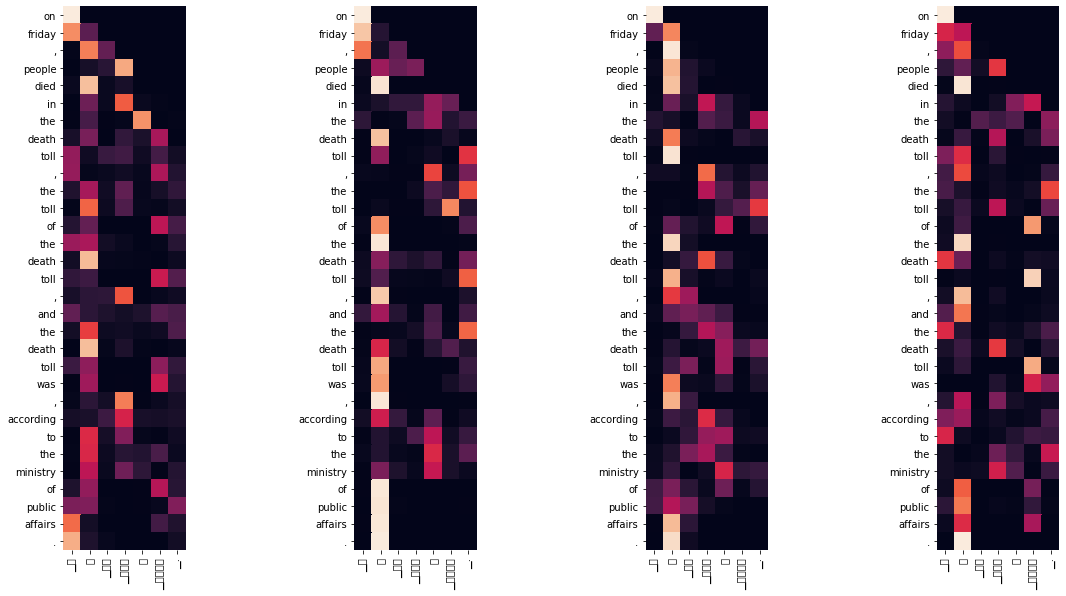

Epoch  4: 100%|██████████| 2127/2127 [07:58<00:00,  4.44it/s, Loss 2.2812]


Input: 오바마는 대통령이다.
Predicted translation: obama has picked up .
Encoder Layer 1


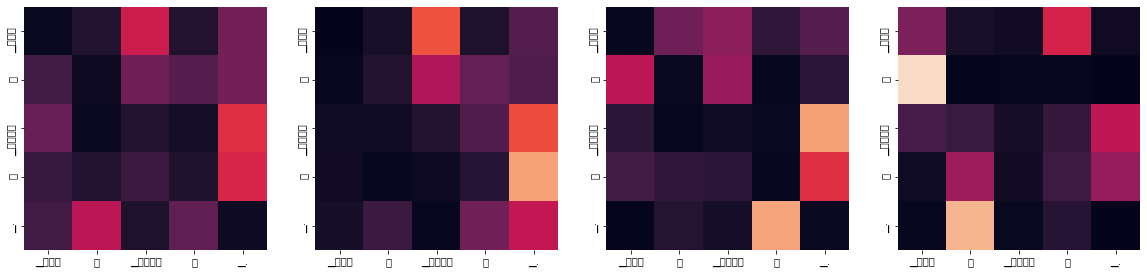

Encoder Layer 2


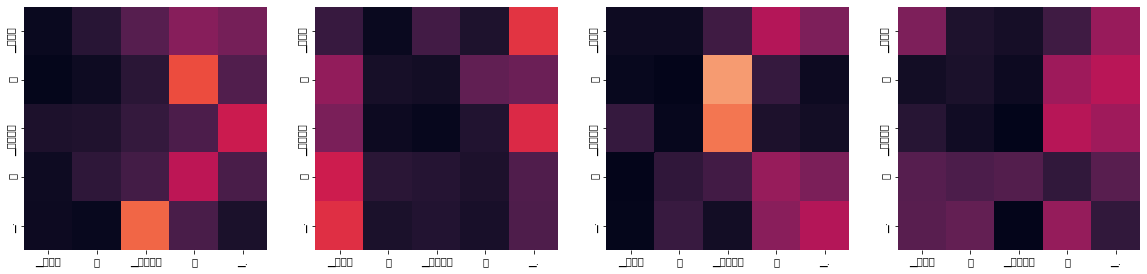

Decoder Self Layer 1


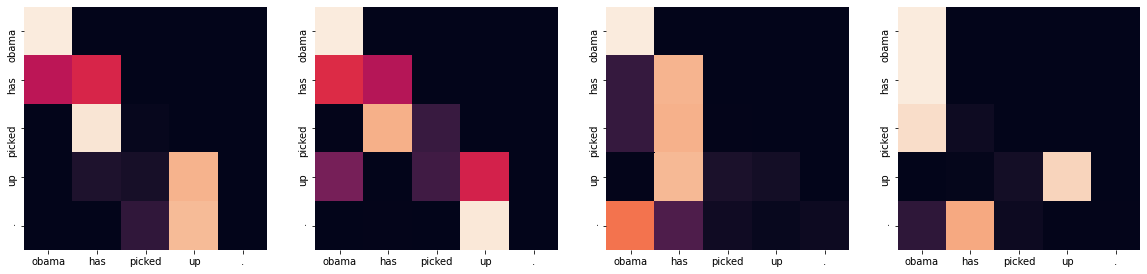

Decoder Src Layer 1


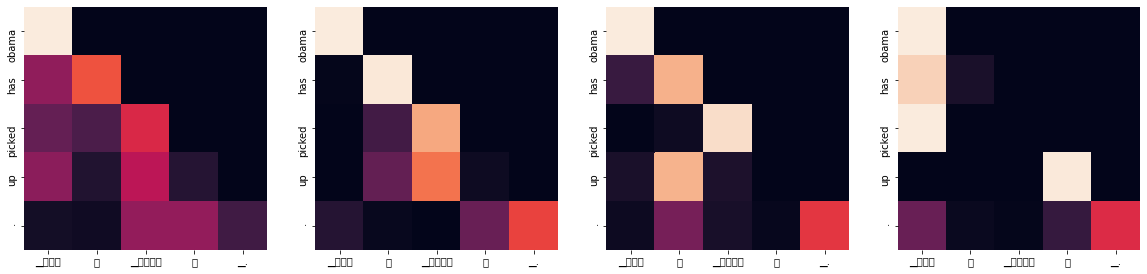

Decoder Self Layer 2


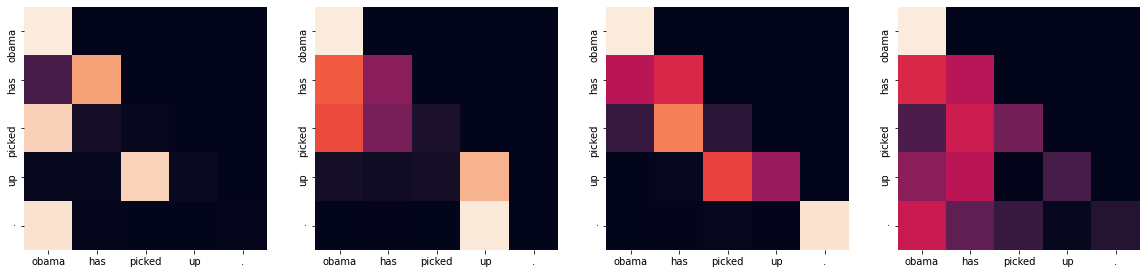

Decoder Src Layer 2


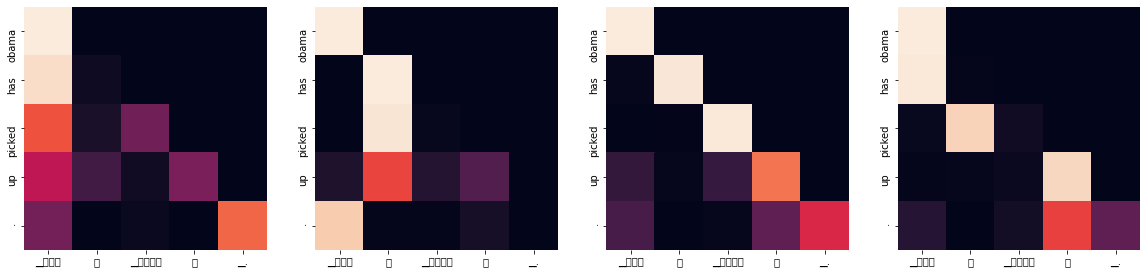

Input: 시민들은 도시 속에 산다.
Predicted translation: they called the town of , .
Encoder Layer 1


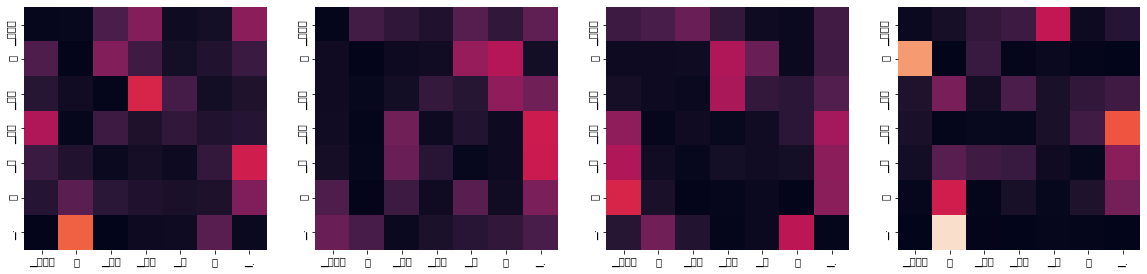

Encoder Layer 2


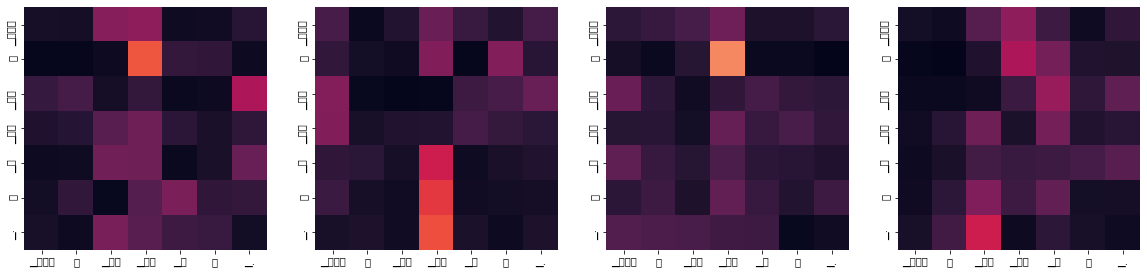

Decoder Self Layer 1


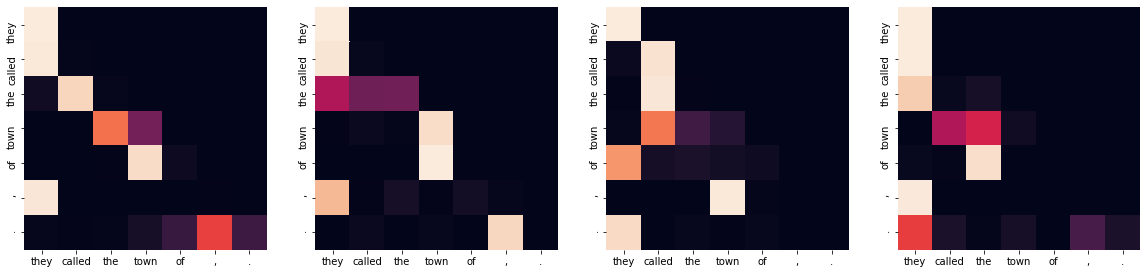

Decoder Src Layer 1


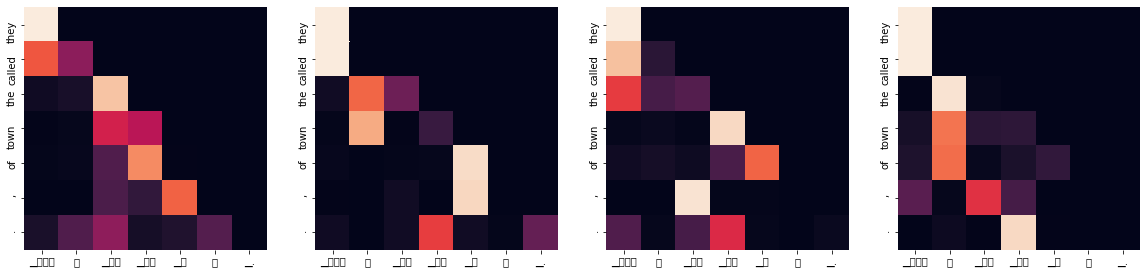

Decoder Self Layer 2


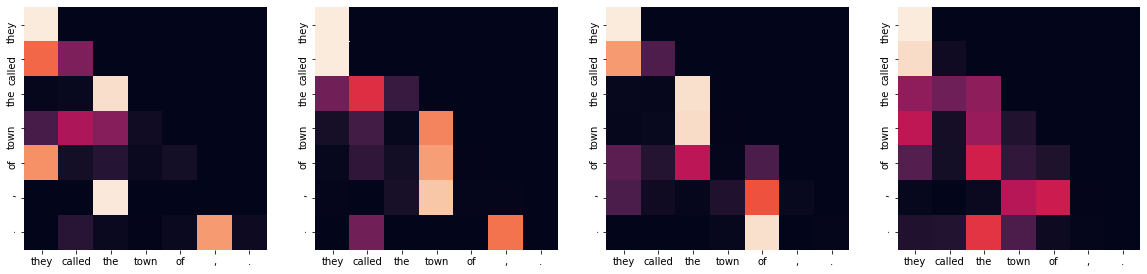

Decoder Src Layer 2


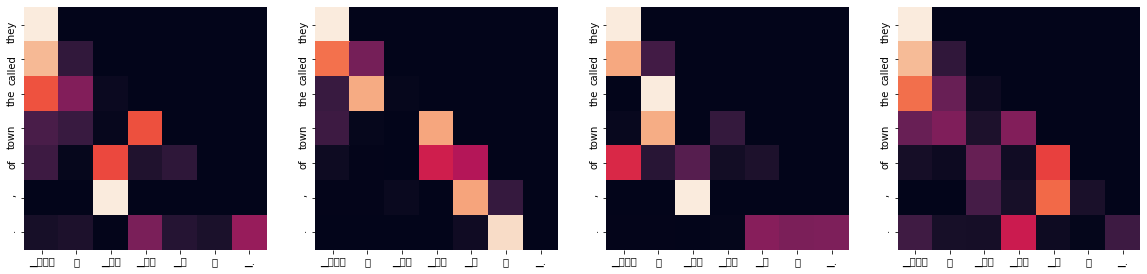

Input: 커피는 필요 없다.
Predicted translation: i need to do .
Encoder Layer 1


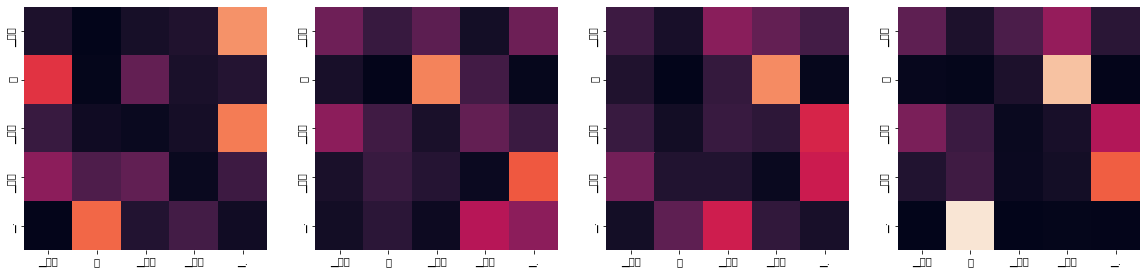

Encoder Layer 2


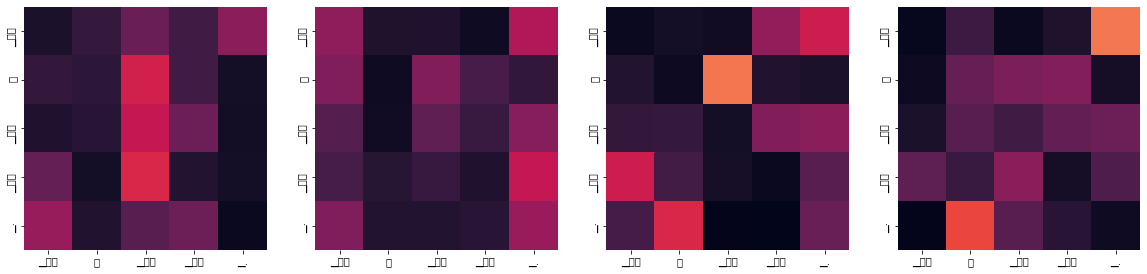

Decoder Self Layer 1


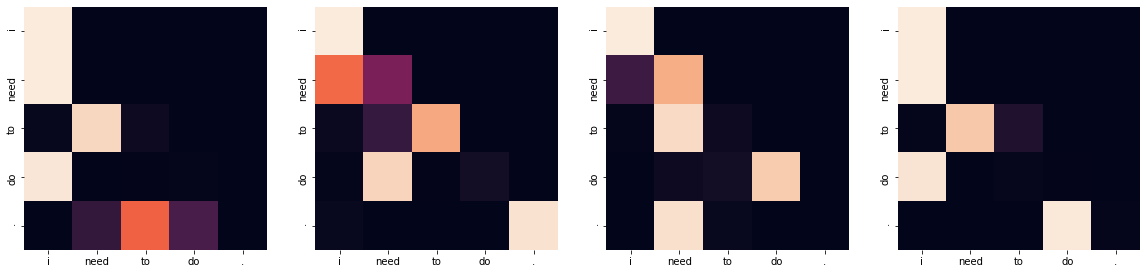

Decoder Src Layer 1


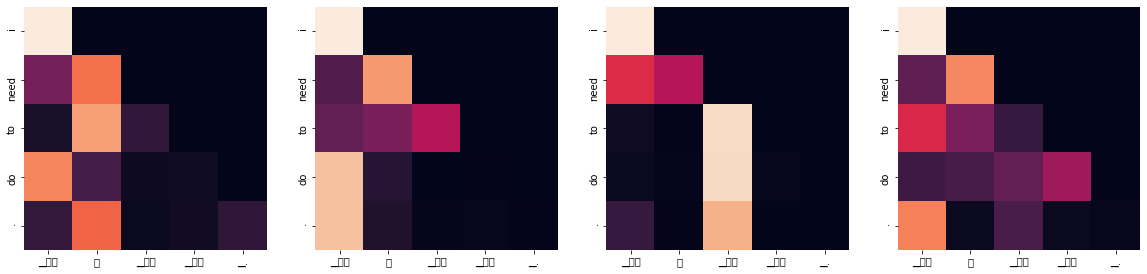

Decoder Self Layer 2


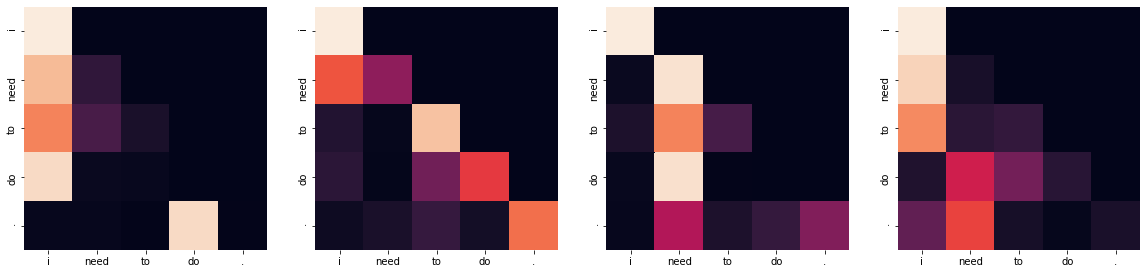

Decoder Src Layer 2


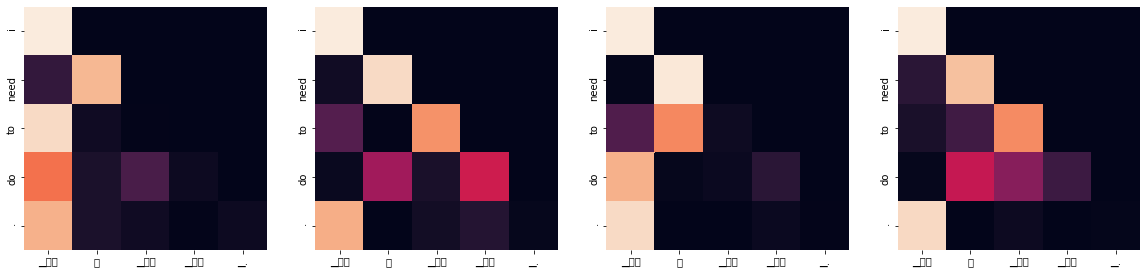

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Encoder Layer 1


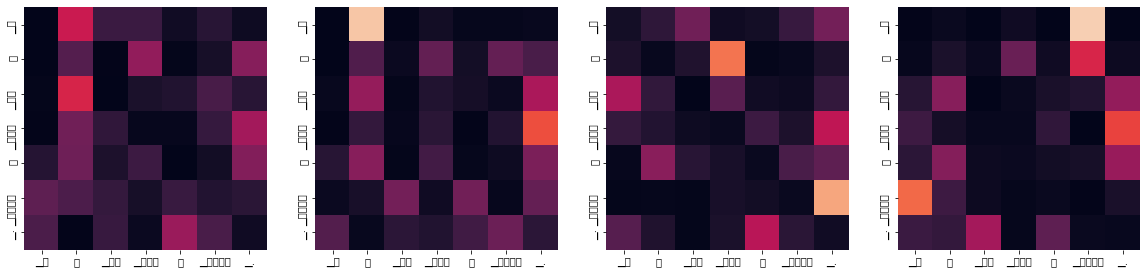

Encoder Layer 2


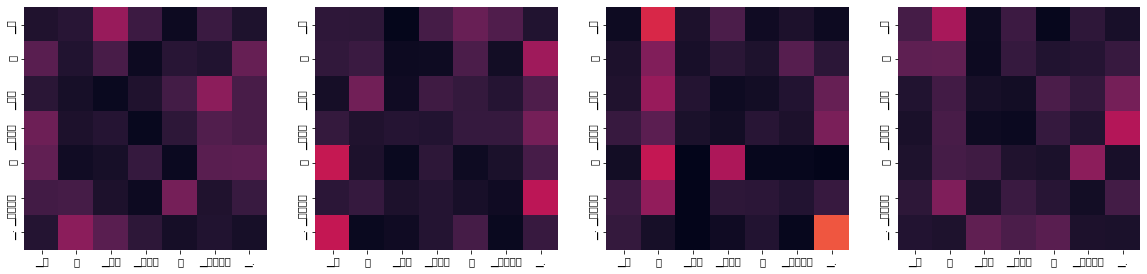

Decoder Self Layer 1


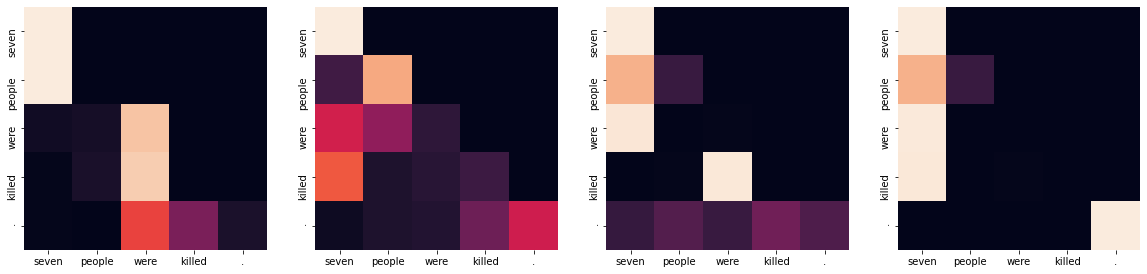

Decoder Src Layer 1


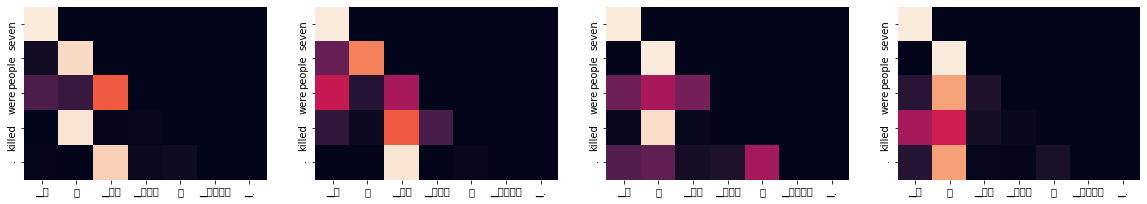

Decoder Self Layer 2


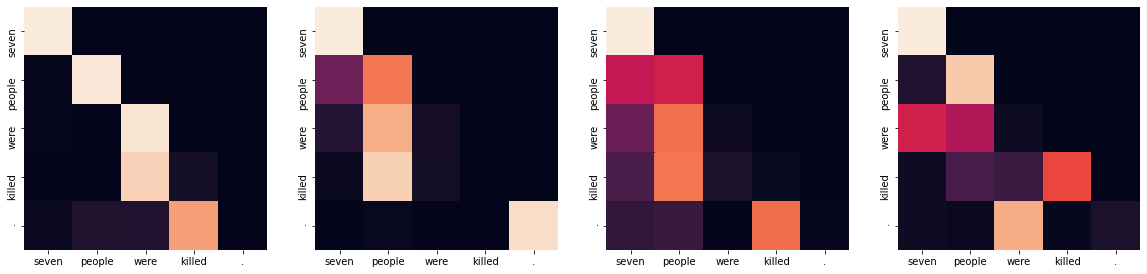

Decoder Src Layer 2


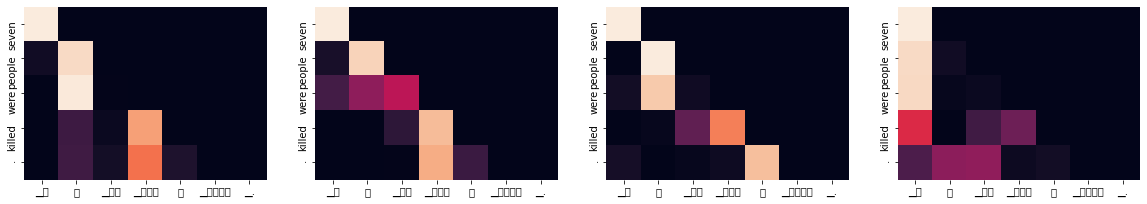

Epoch  5: 100%|██████████| 2127/2127 [07:59<00:00,  4.44it/s, Loss 1.8039]


Input: 오바마는 대통령이다.
Predicted translation: obama is acting president .
Encoder Layer 1


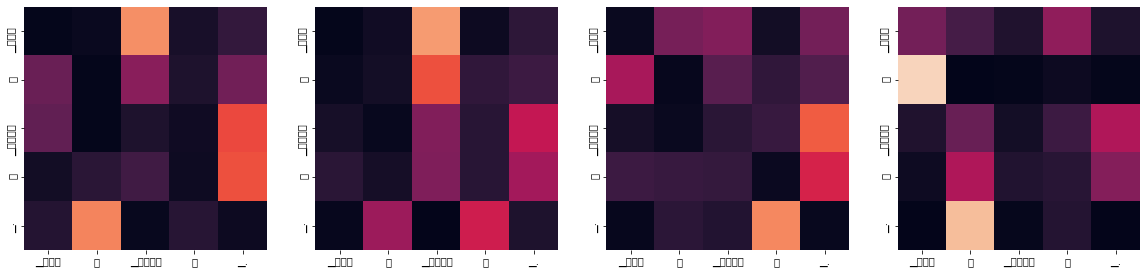

Encoder Layer 2


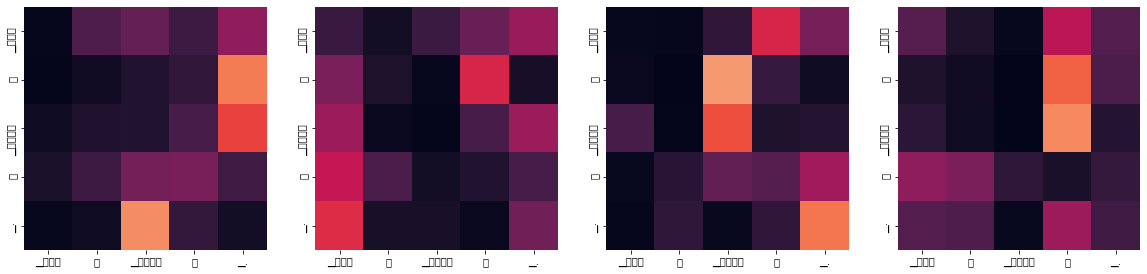

Decoder Self Layer 1


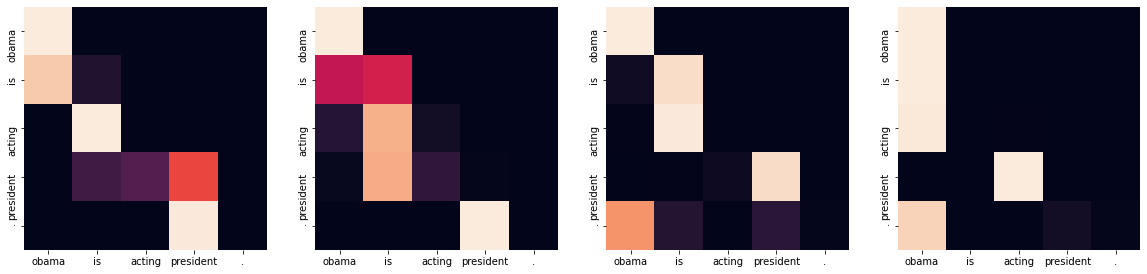

Decoder Src Layer 1


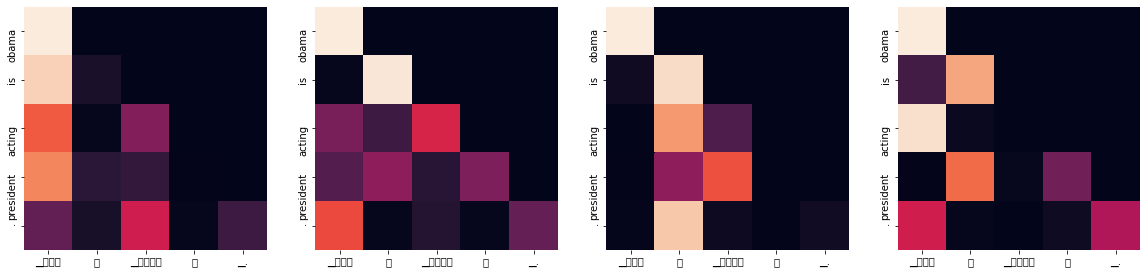

Decoder Self Layer 2


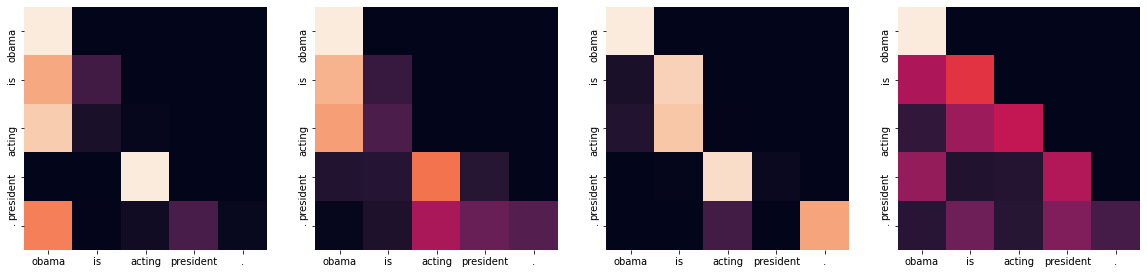

Decoder Src Layer 2


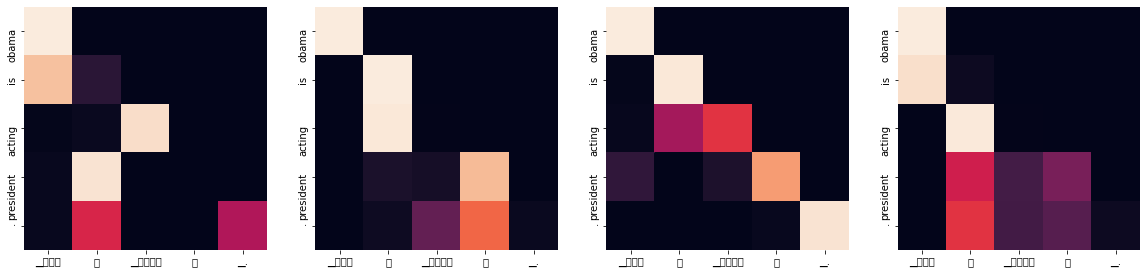

Input: 시민들은 도시 속에 산다.
Predicted translation: they bring down the city to the second violence .
Encoder Layer 1


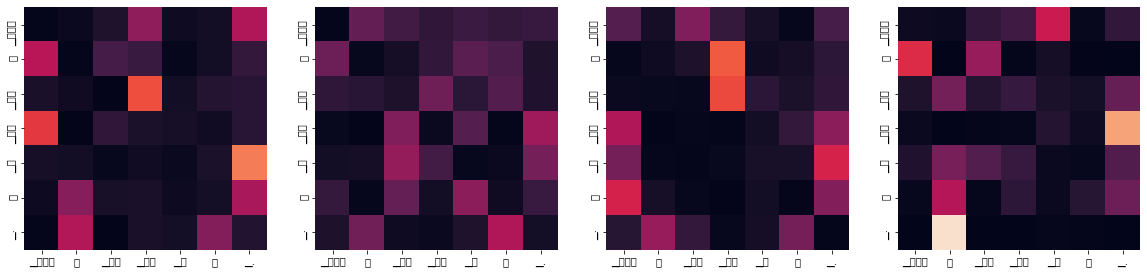

Encoder Layer 2


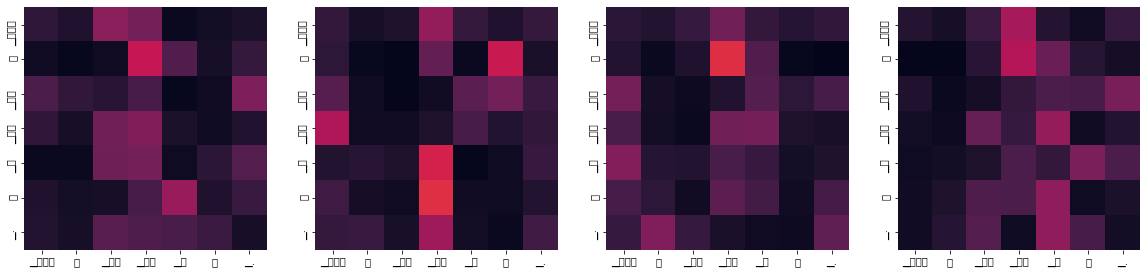

Decoder Self Layer 1


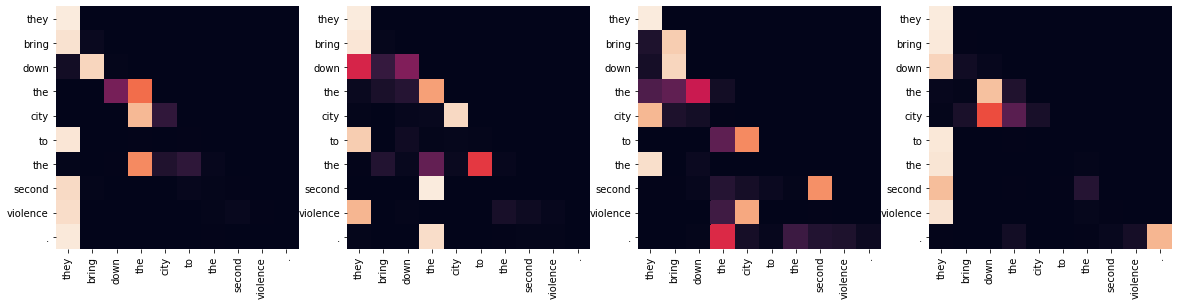

Decoder Src Layer 1


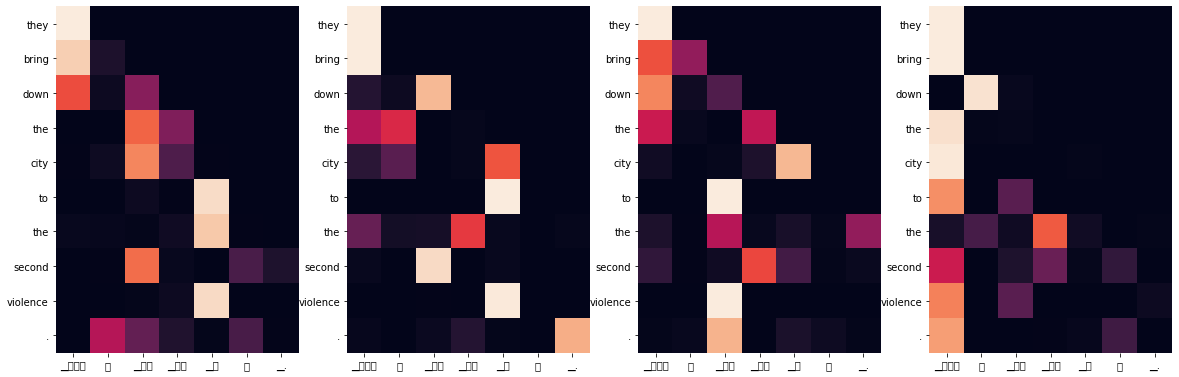

Decoder Self Layer 2


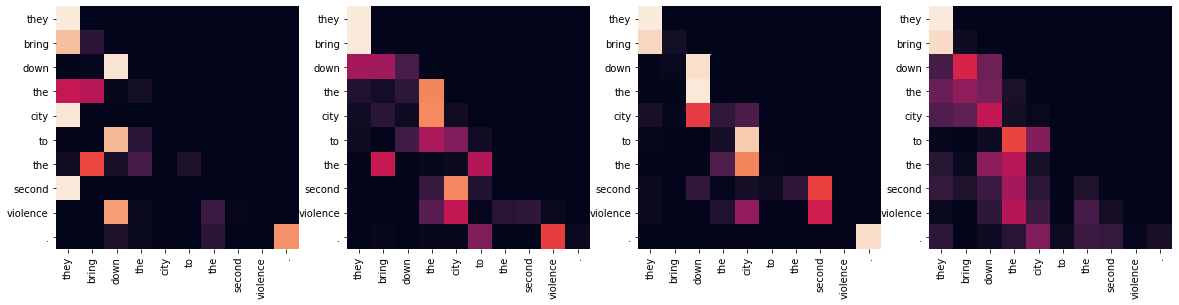

Decoder Src Layer 2


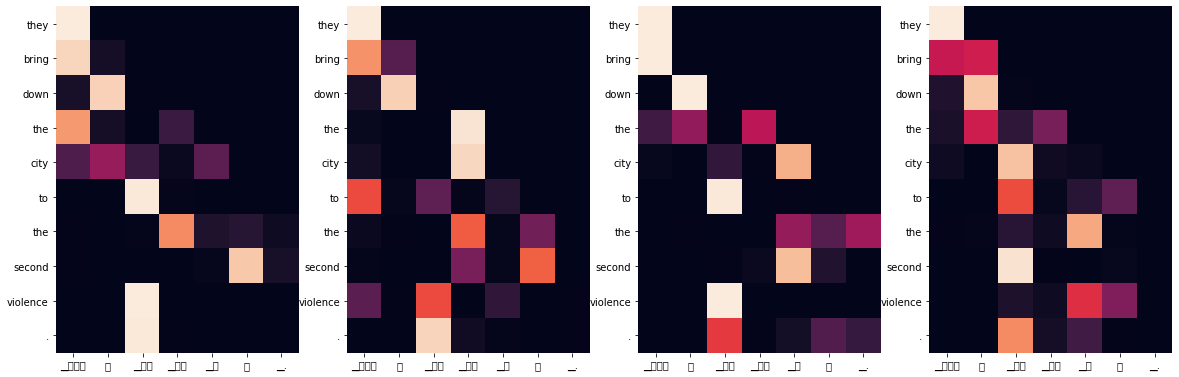

Input: 커피는 필요 없다.
Predicted translation: i don t need to be don t need to be coffee .
Encoder Layer 1


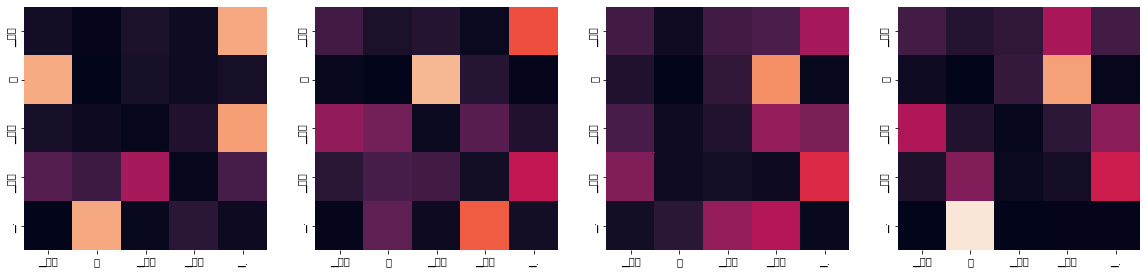

Encoder Layer 2


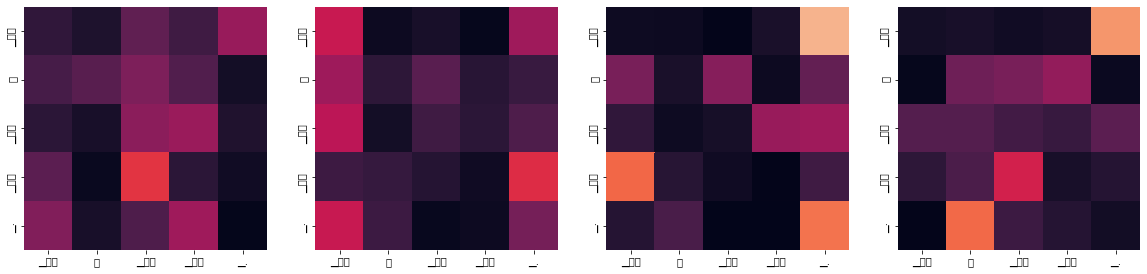

Decoder Self Layer 1


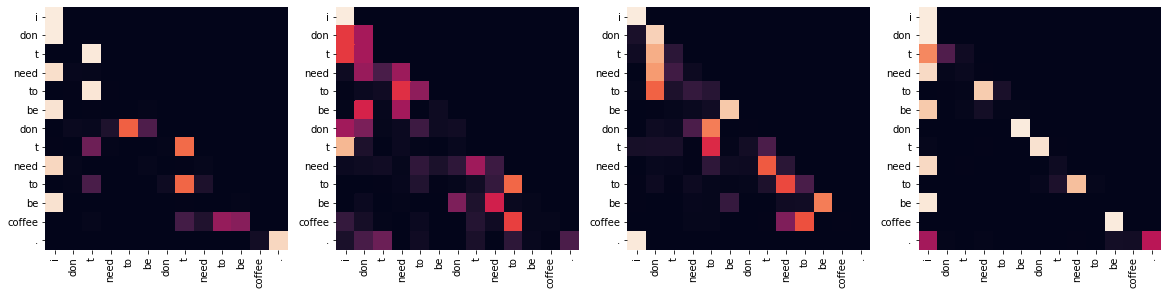

Decoder Src Layer 1


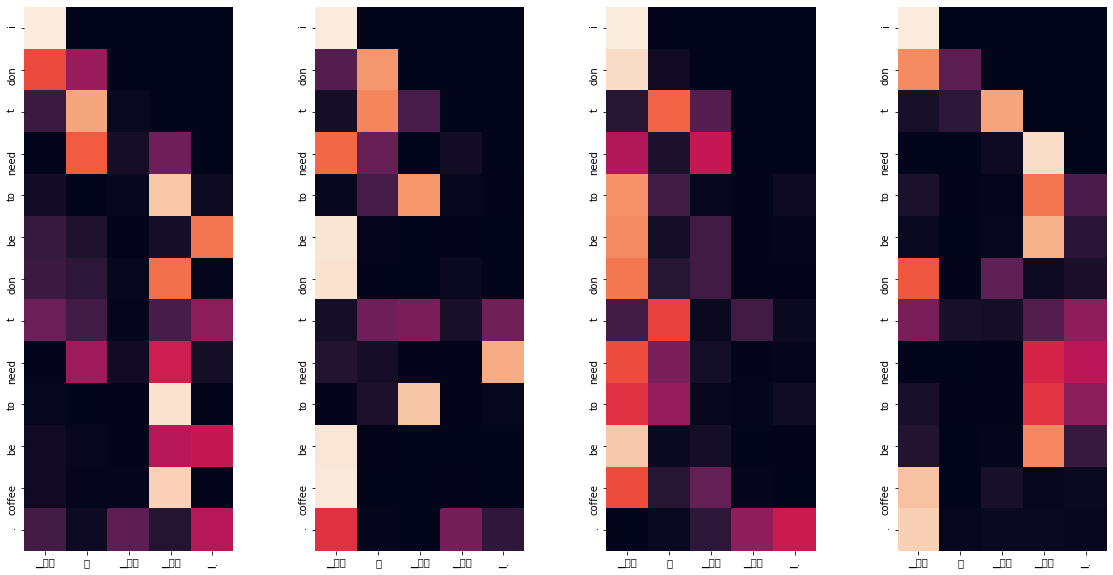

Decoder Self Layer 2


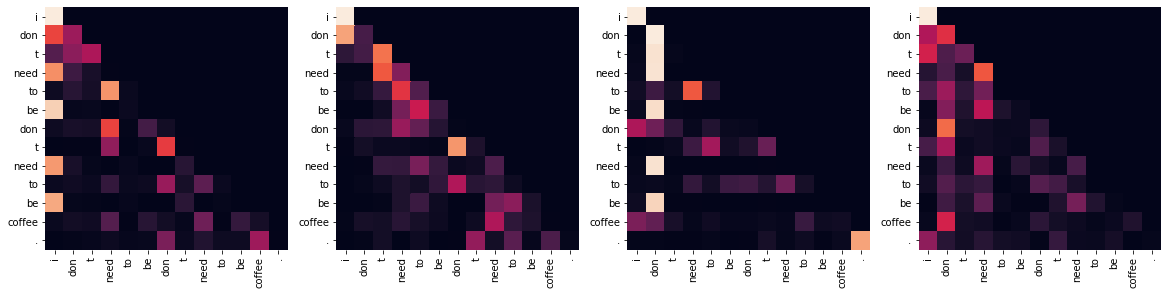

Decoder Src Layer 2


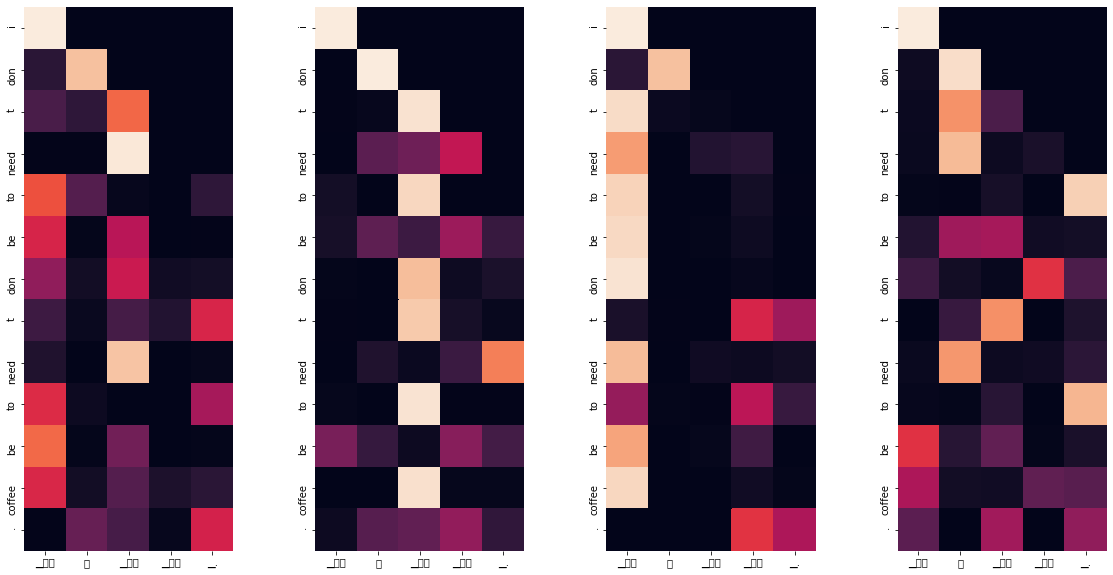

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilians were killed wednesday night .
Encoder Layer 1


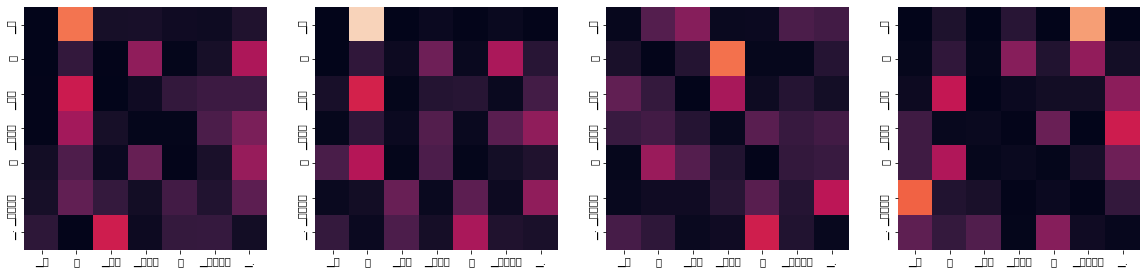

Encoder Layer 2


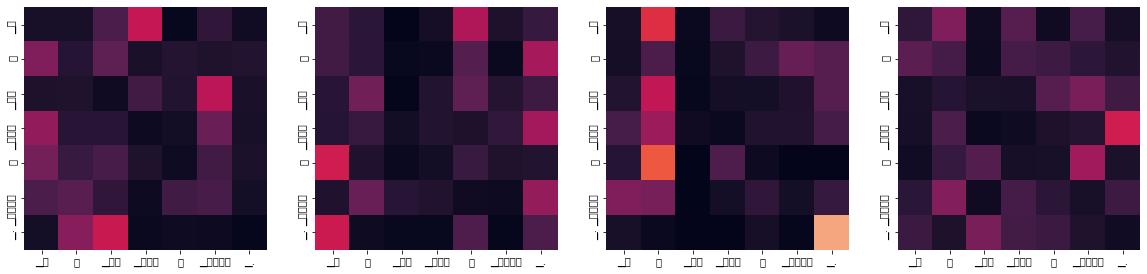

Decoder Self Layer 1


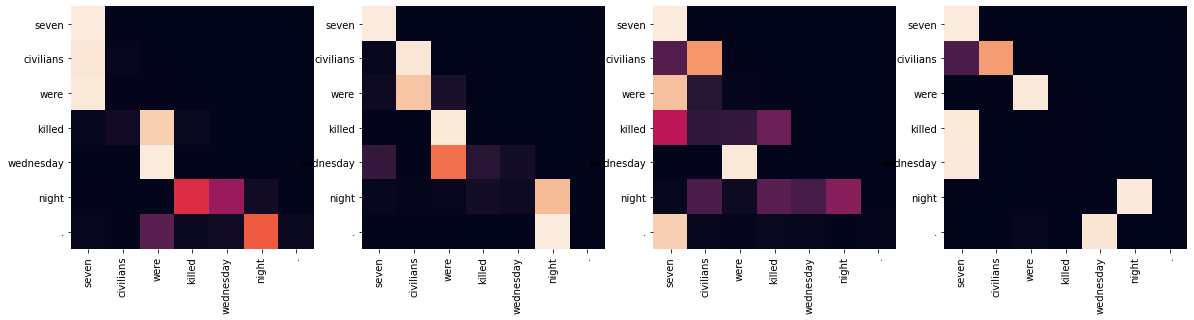

Decoder Src Layer 1


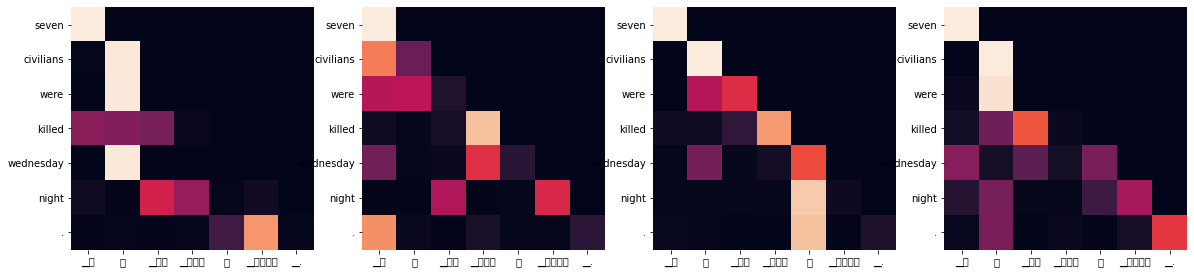

Decoder Self Layer 2


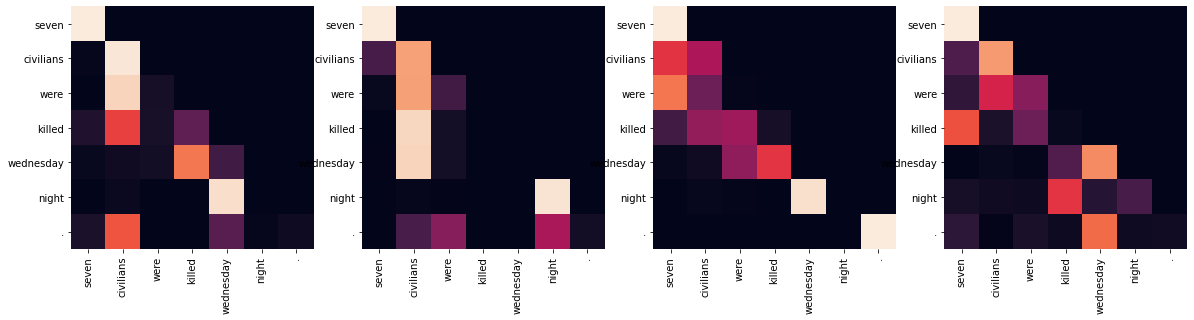

Decoder Src Layer 2


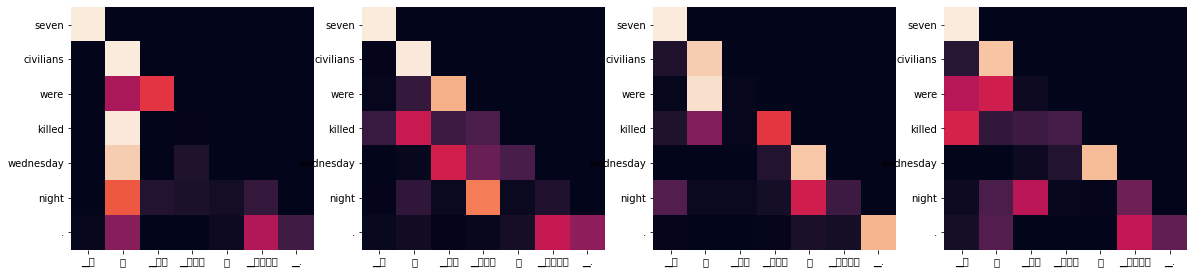

Epoch  6: 100%|██████████| 2127/2127 [08:06<00:00,  4.37it/s, Loss 1.3962]


Input: 오바마는 대통령이다.
Predicted translation: obama is poised to become .
Encoder Layer 1


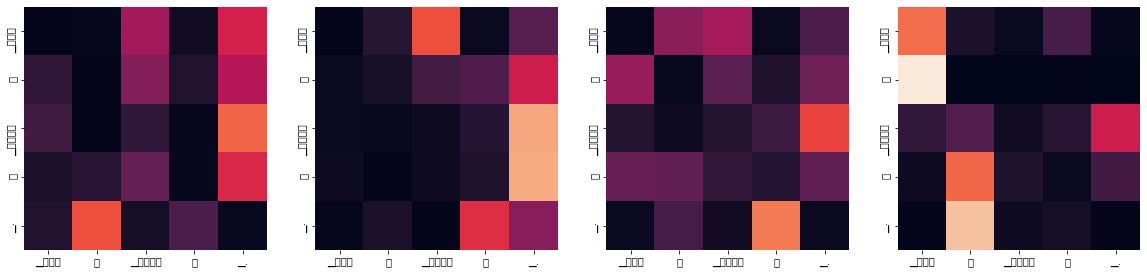

Encoder Layer 2


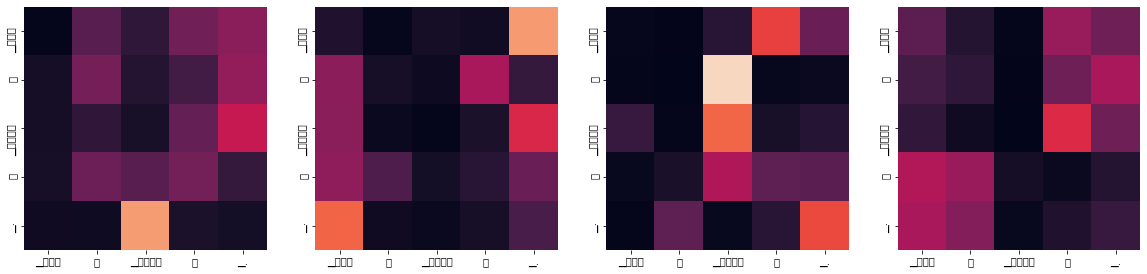

Decoder Self Layer 1


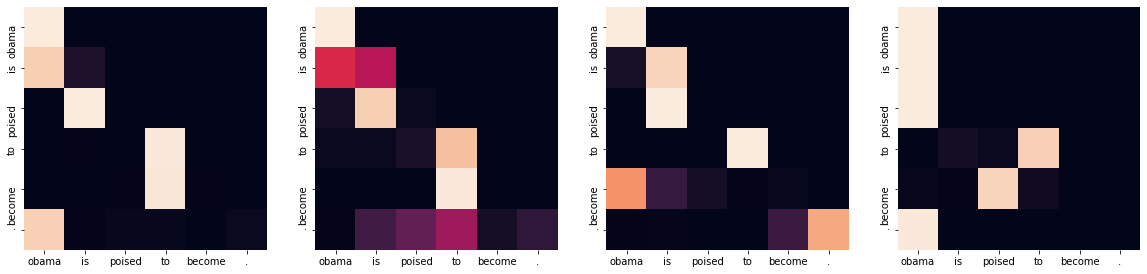

Decoder Src Layer 1


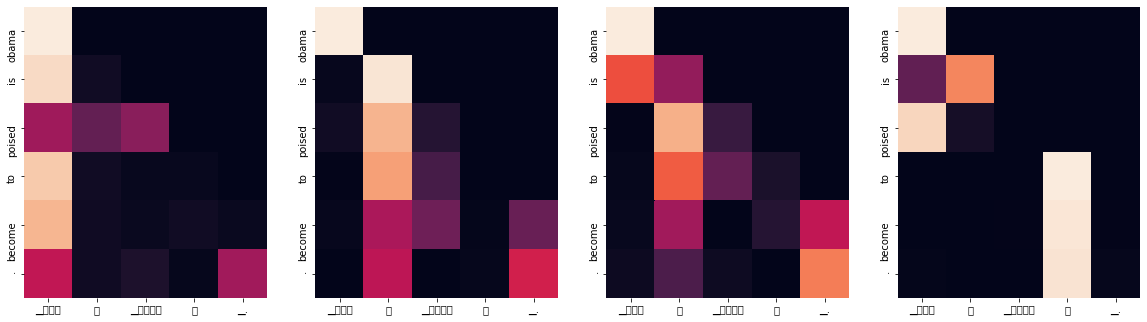

Decoder Self Layer 2


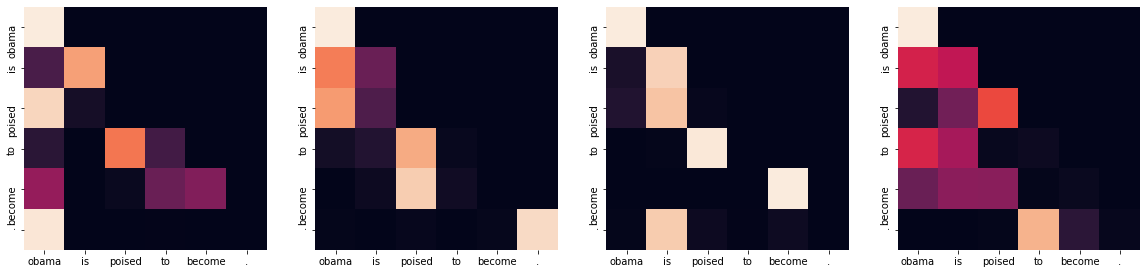

Decoder Src Layer 2


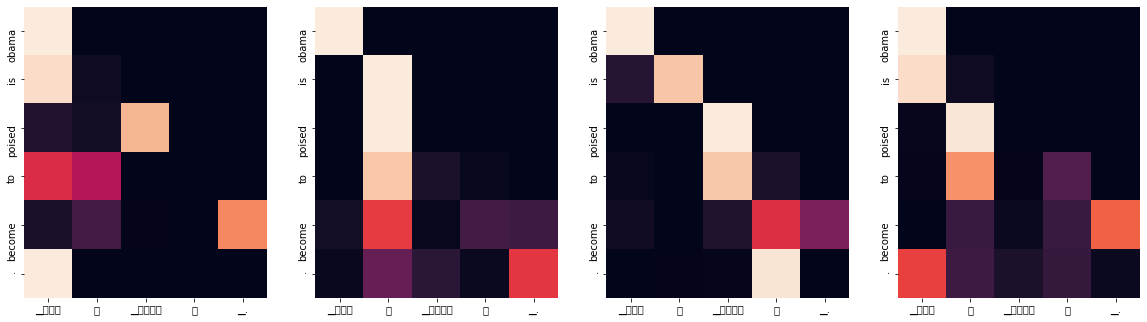

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is centered in the second city .
Encoder Layer 1


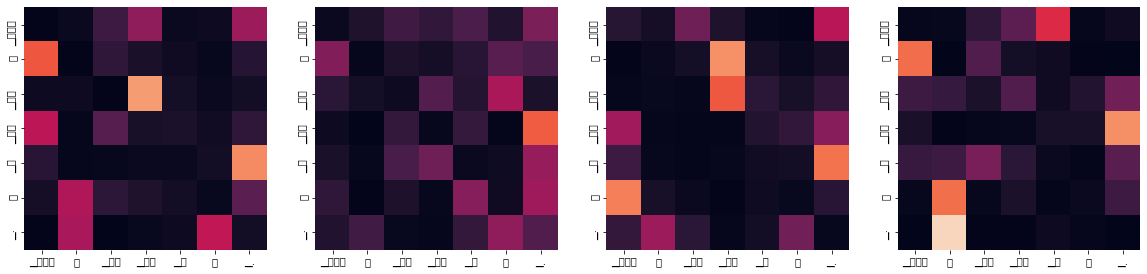

Encoder Layer 2


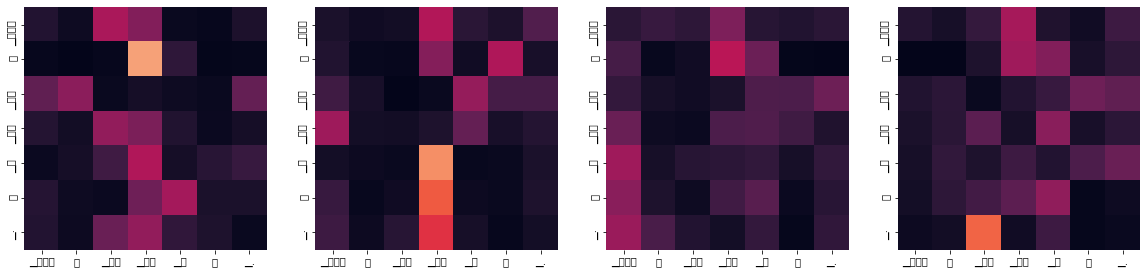

Decoder Self Layer 1


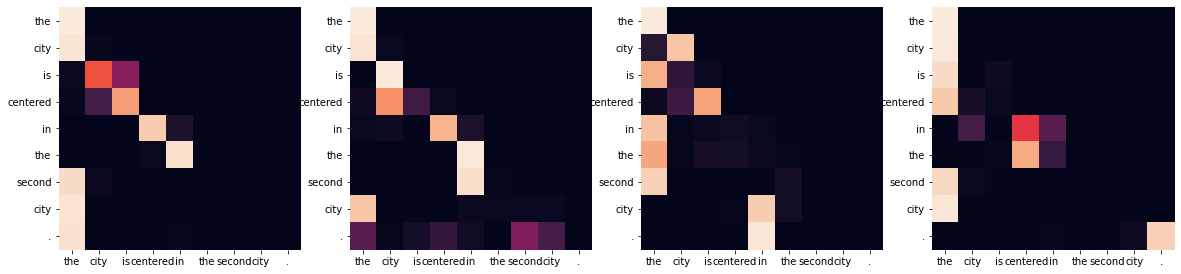

Decoder Src Layer 1


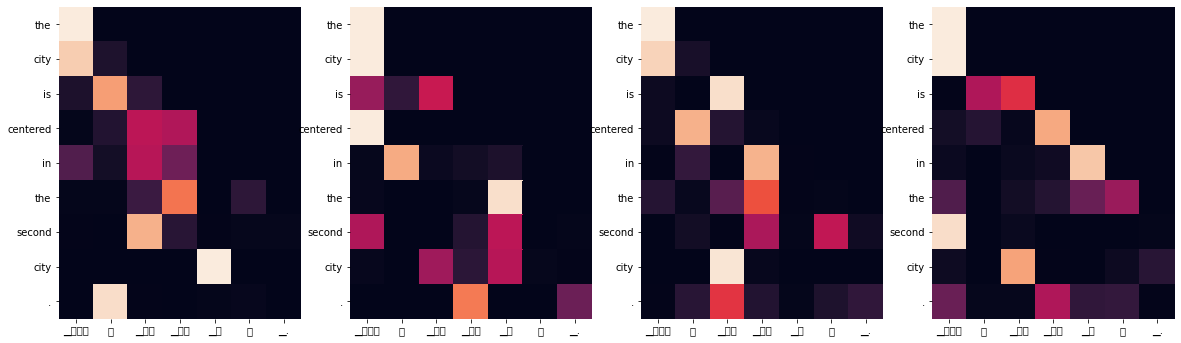

Decoder Self Layer 2


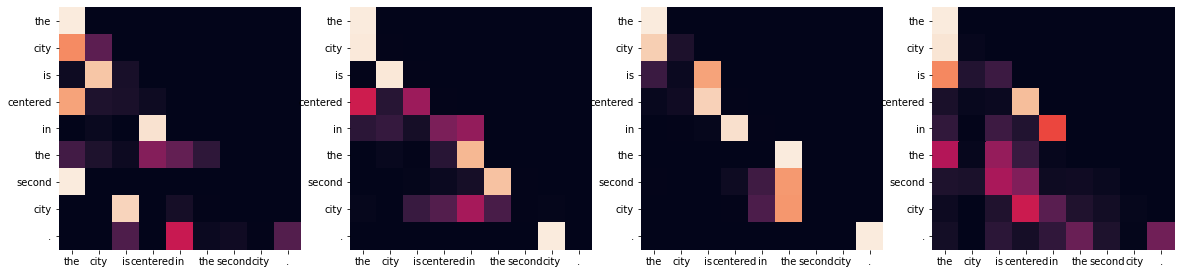

Decoder Src Layer 2


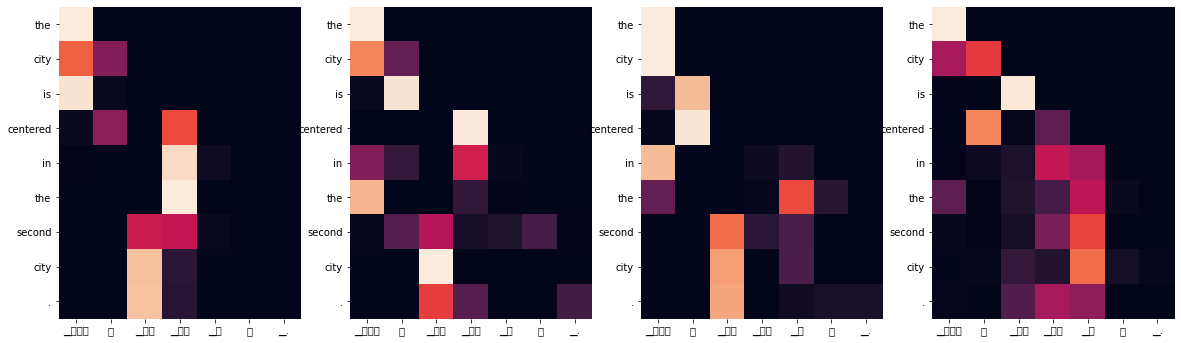

Input: 커피는 필요 없다.
Predicted translation: so we need to make no music .
Encoder Layer 1


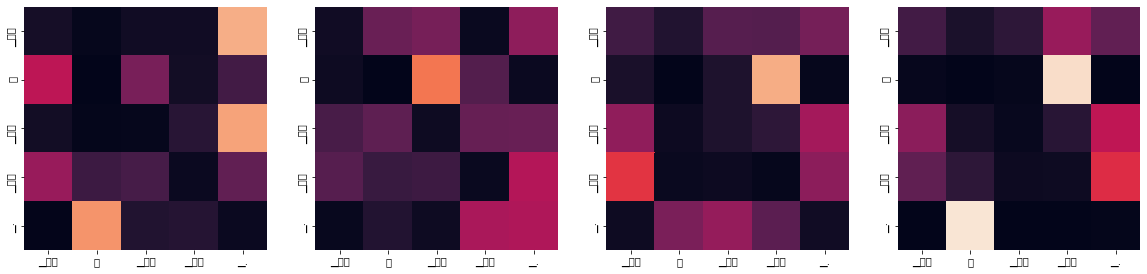

Encoder Layer 2


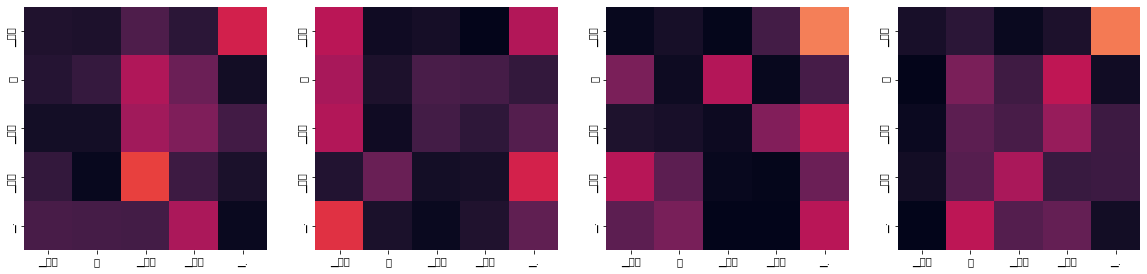

Decoder Self Layer 1


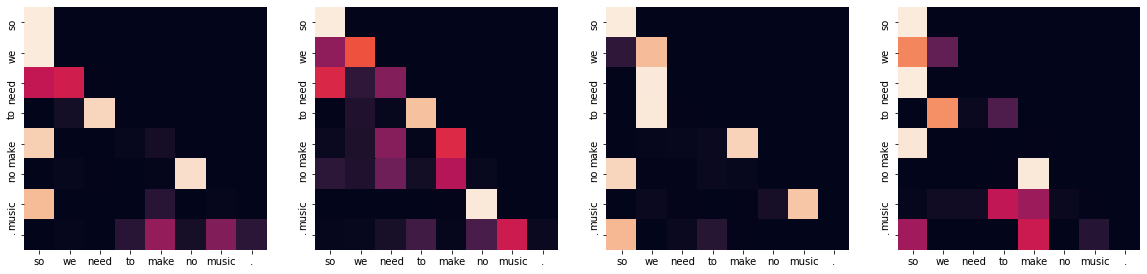

Decoder Src Layer 1


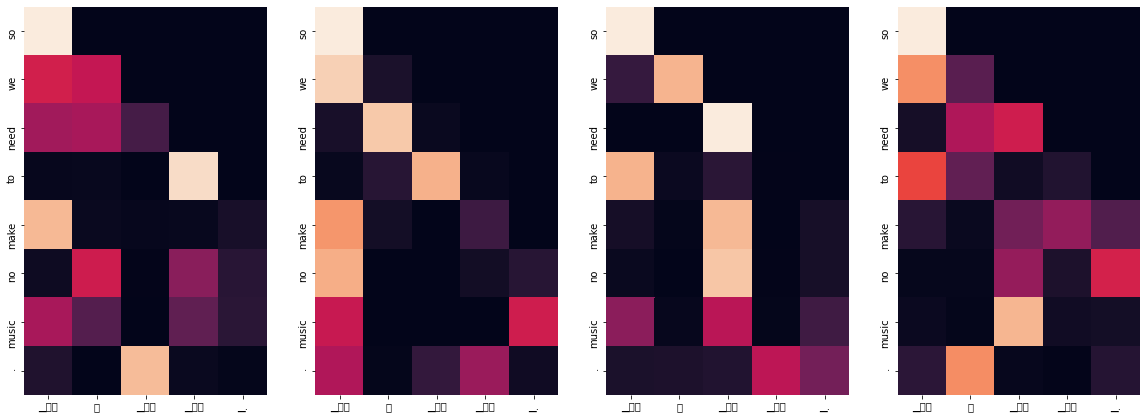

Decoder Self Layer 2


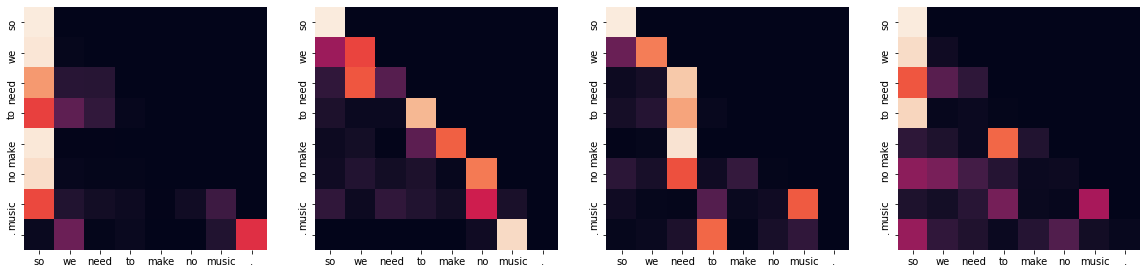

Decoder Src Layer 2


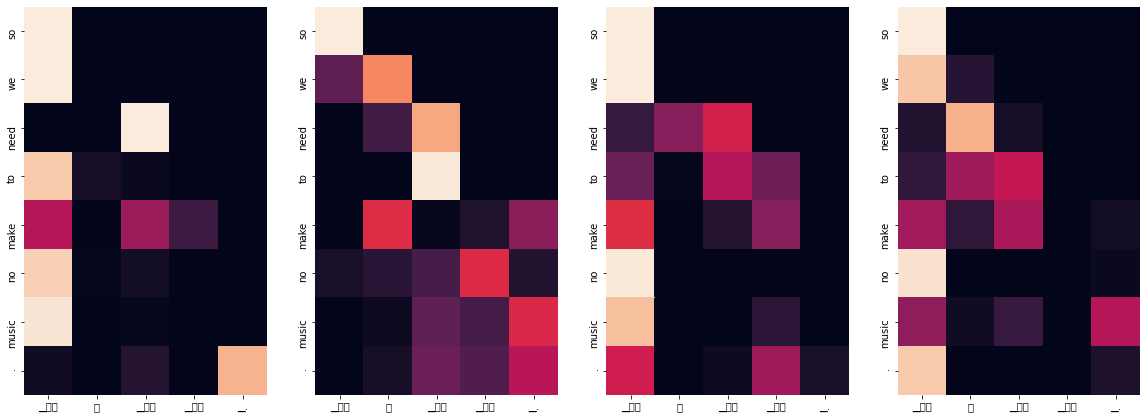

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead sunday , but the seven were wounded .
Encoder Layer 1


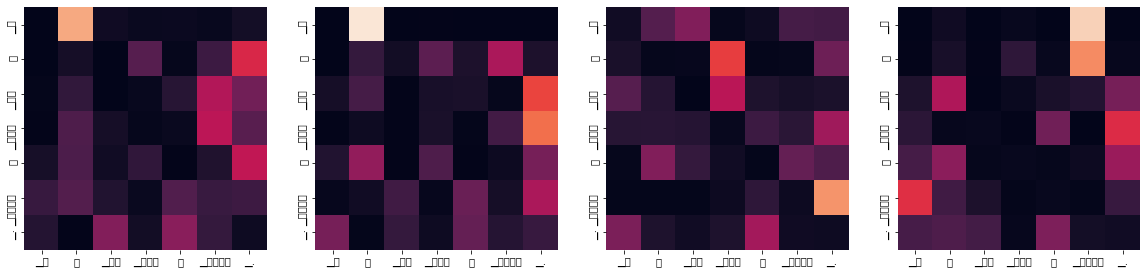

Encoder Layer 2


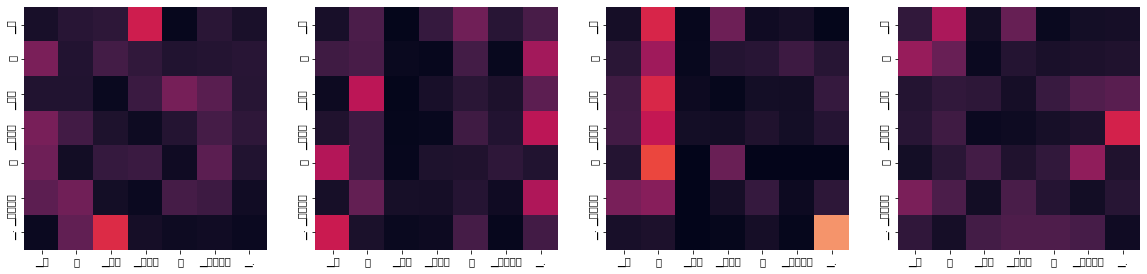

Decoder Self Layer 1


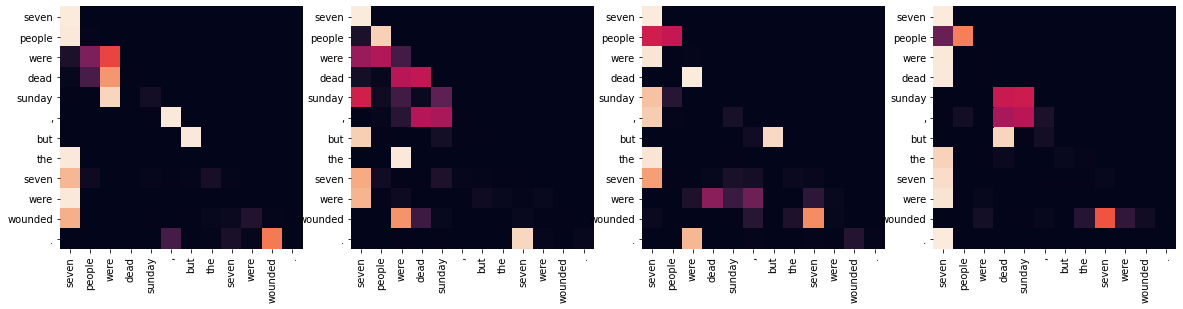

Decoder Src Layer 1


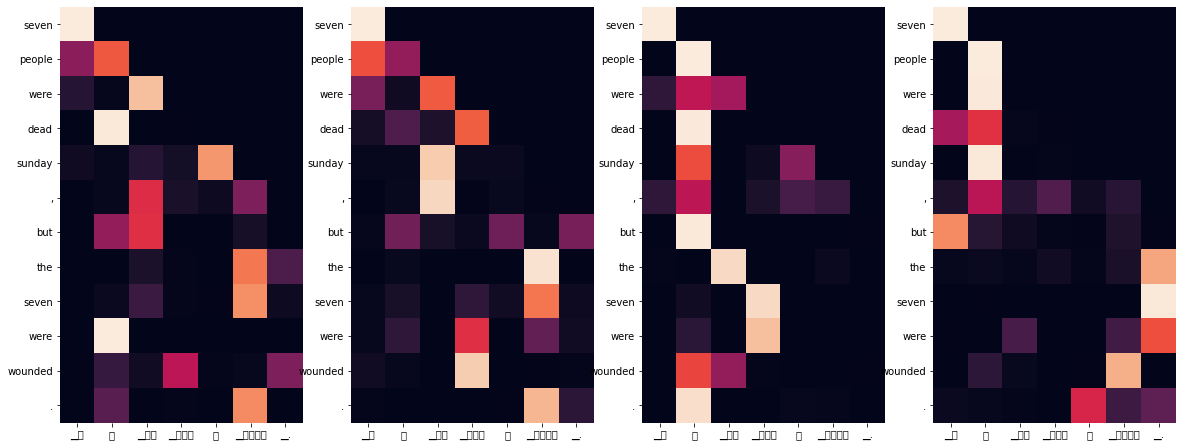

Decoder Self Layer 2


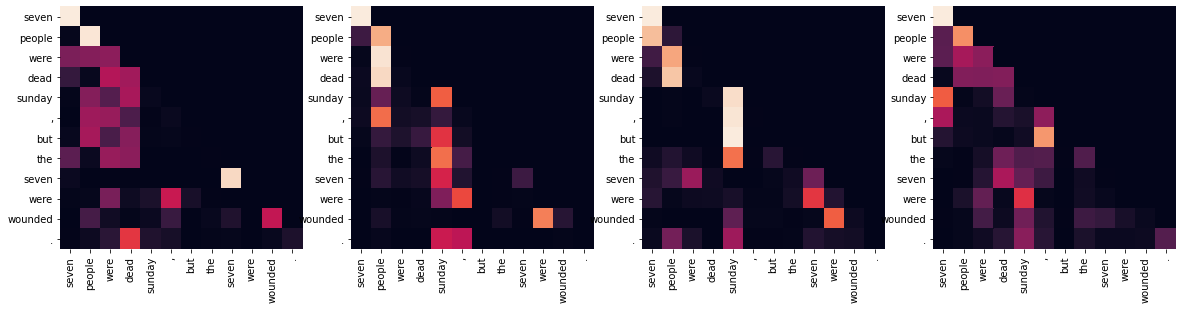

Decoder Src Layer 2


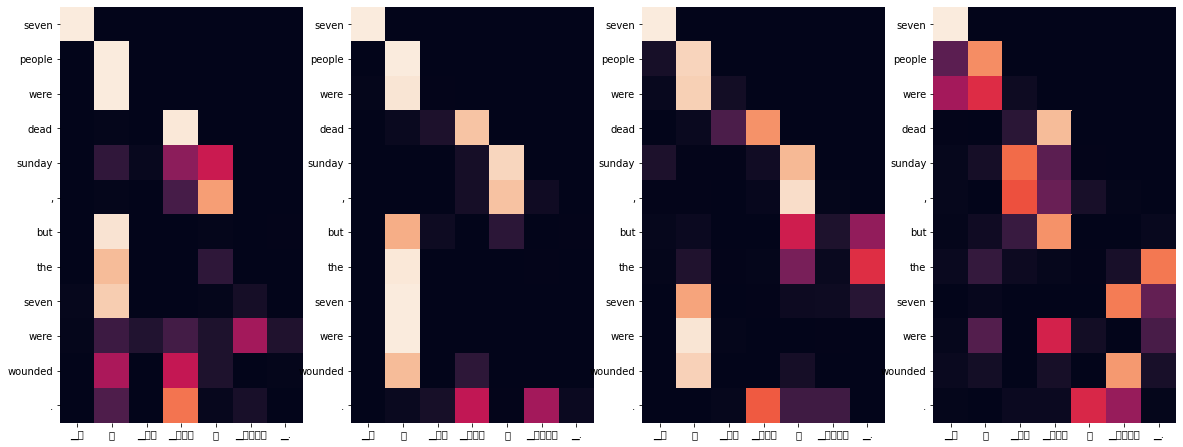

Epoch  7: 100%|██████████| 2127/2127 [07:58<00:00,  4.45it/s, Loss 1.0661]


Input: 오바마는 대통령이다.
Predicted translation: obama is hoping he can become
Encoder Layer 1


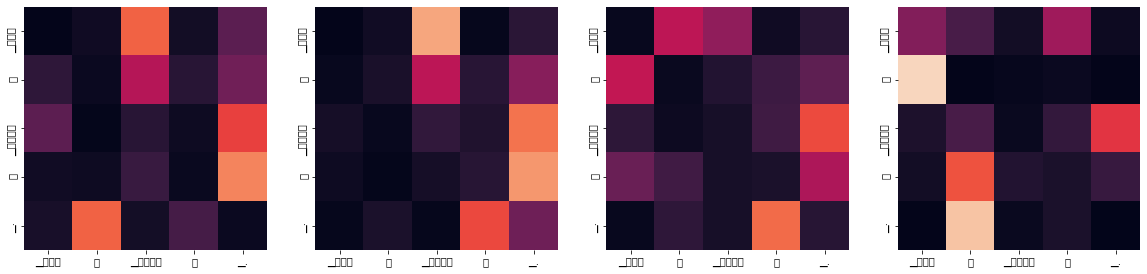

Encoder Layer 2


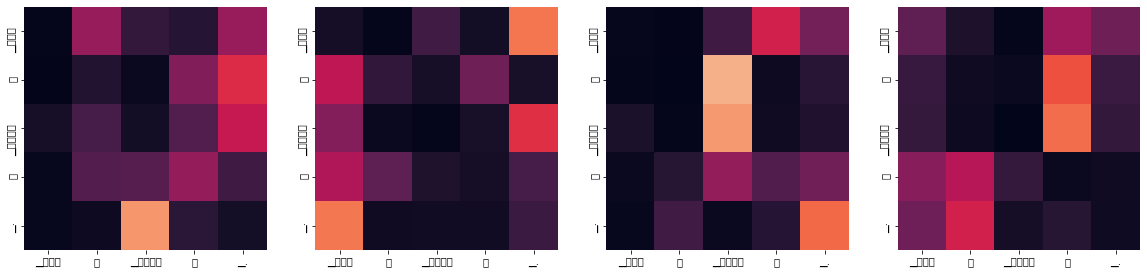

Decoder Self Layer 1


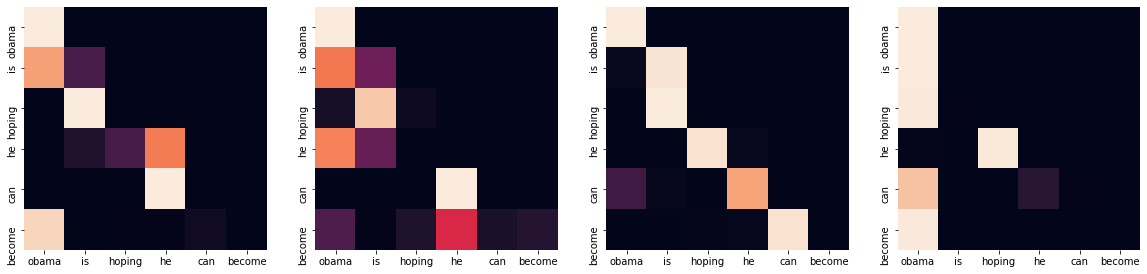

Decoder Src Layer 1


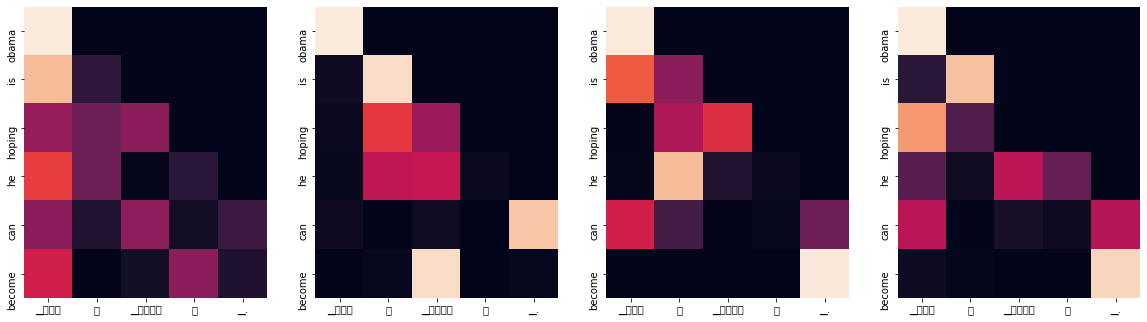

Decoder Self Layer 2


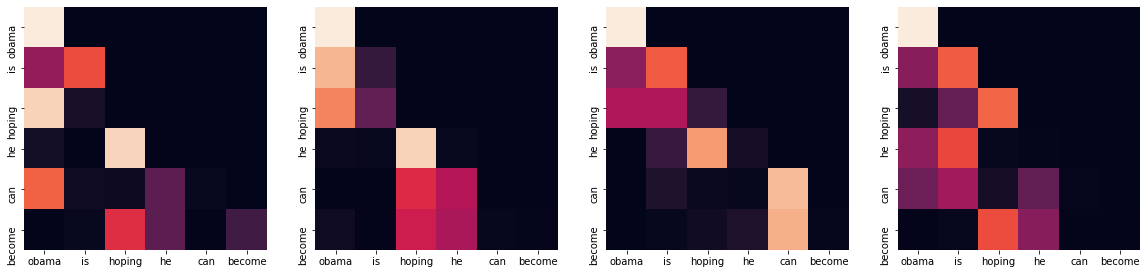

Decoder Src Layer 2


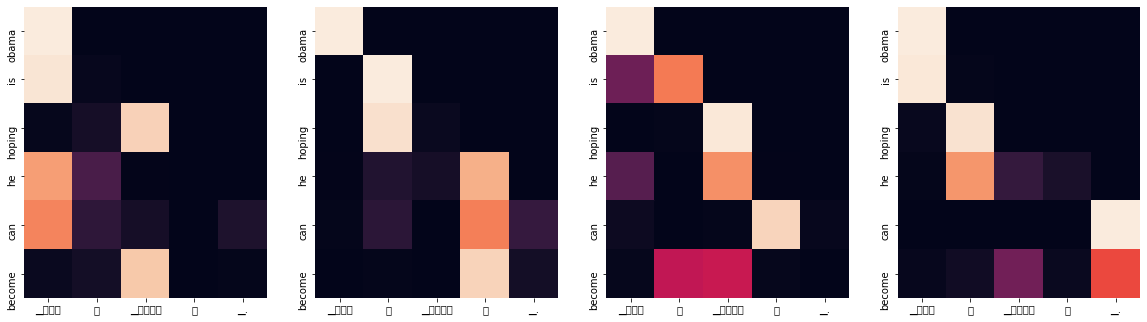

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the second kind of bies .
Encoder Layer 1


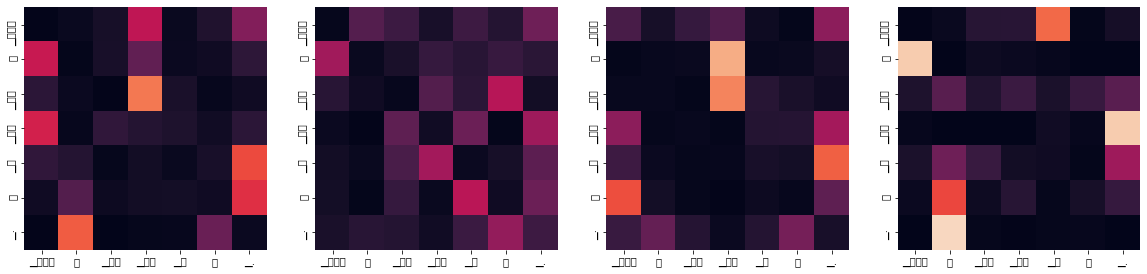

Encoder Layer 2


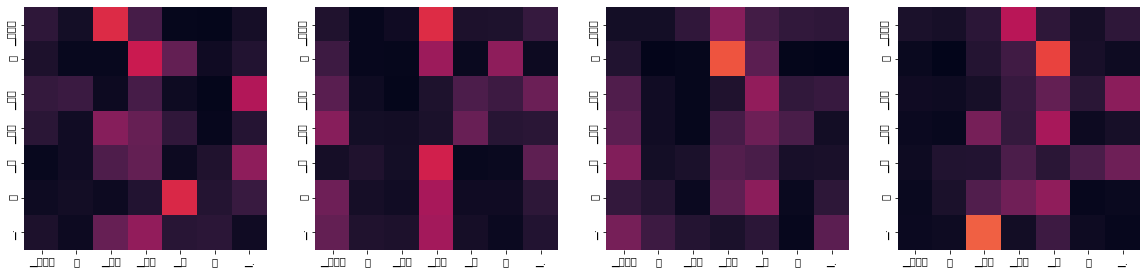

Decoder Self Layer 1


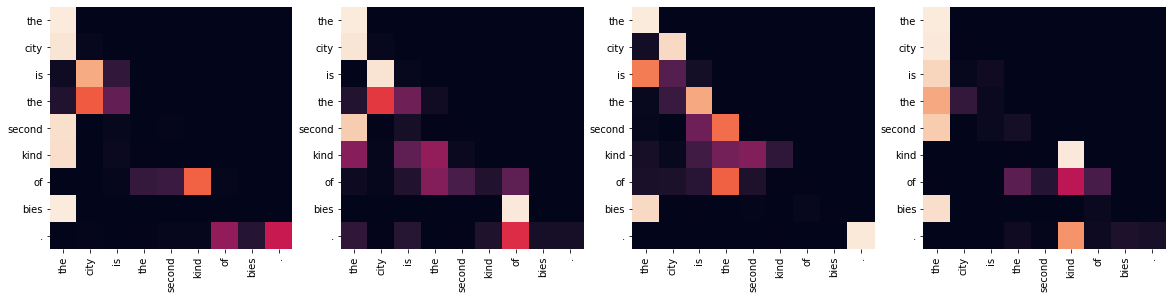

Decoder Src Layer 1


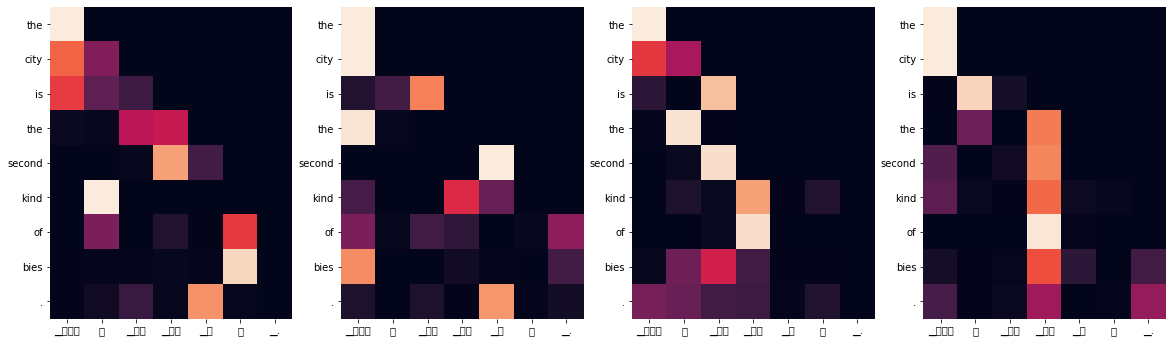

Decoder Self Layer 2


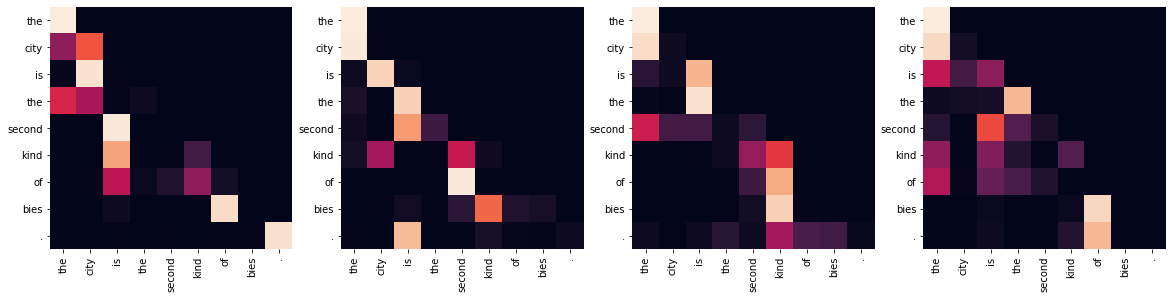

Decoder Src Layer 2


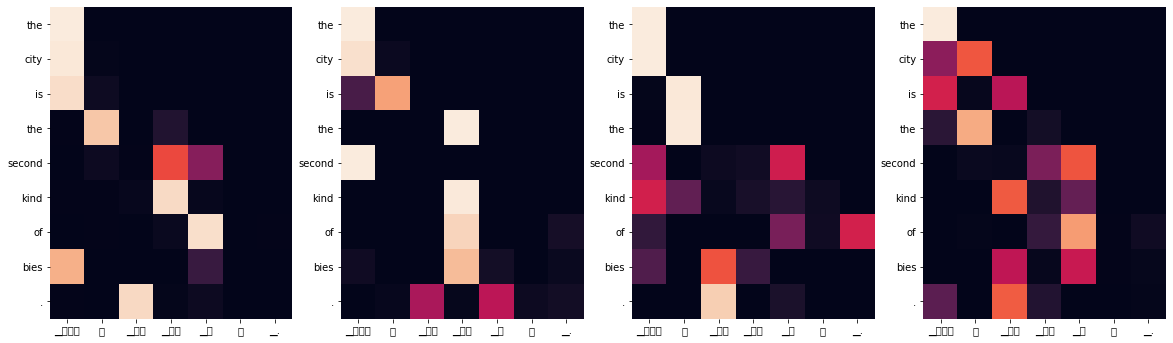

Input: 커피는 필요 없다.
Predicted translation: don t need coffee is necessar .
Encoder Layer 1


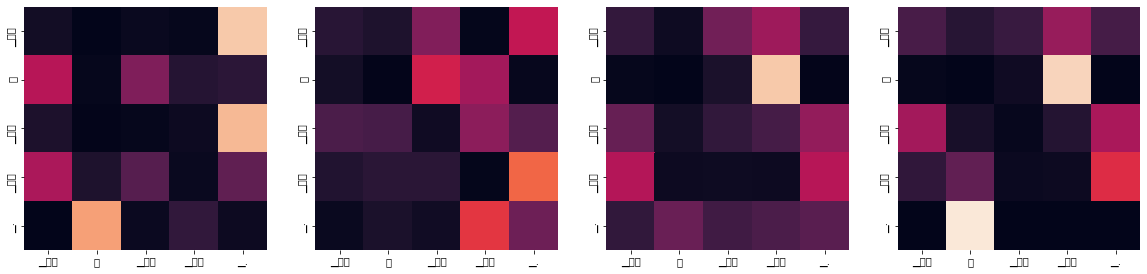

Encoder Layer 2


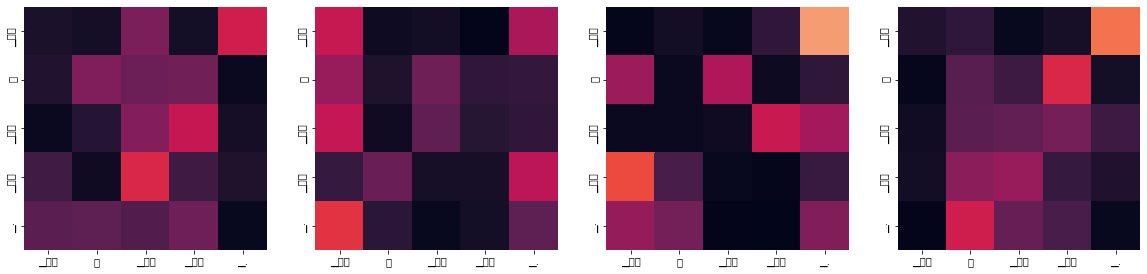

Decoder Self Layer 1


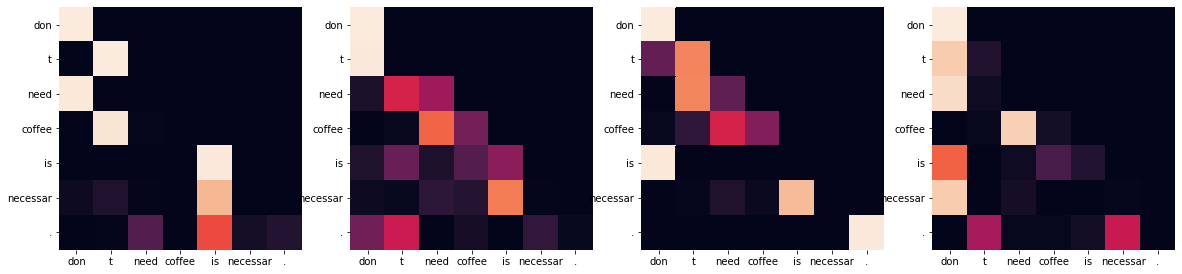

Decoder Src Layer 1


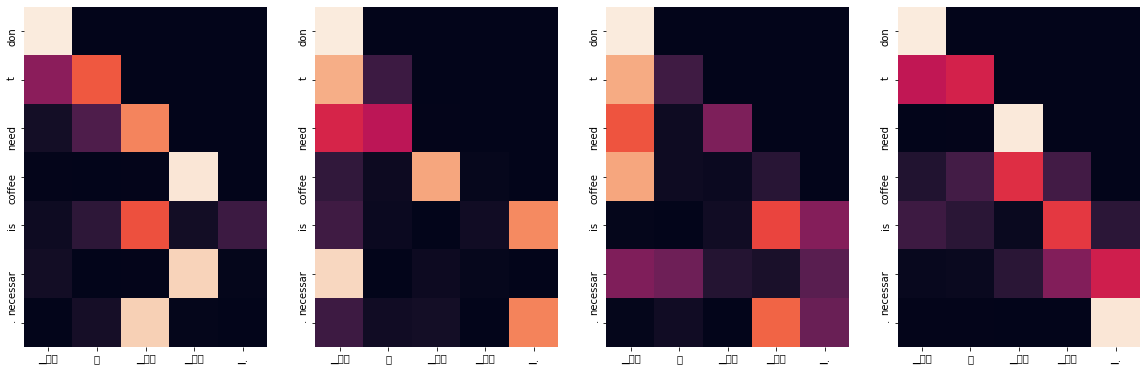

Decoder Self Layer 2


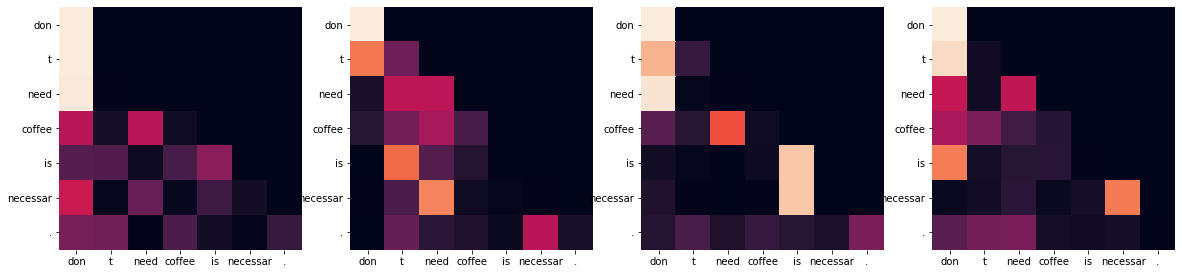

Decoder Src Layer 2


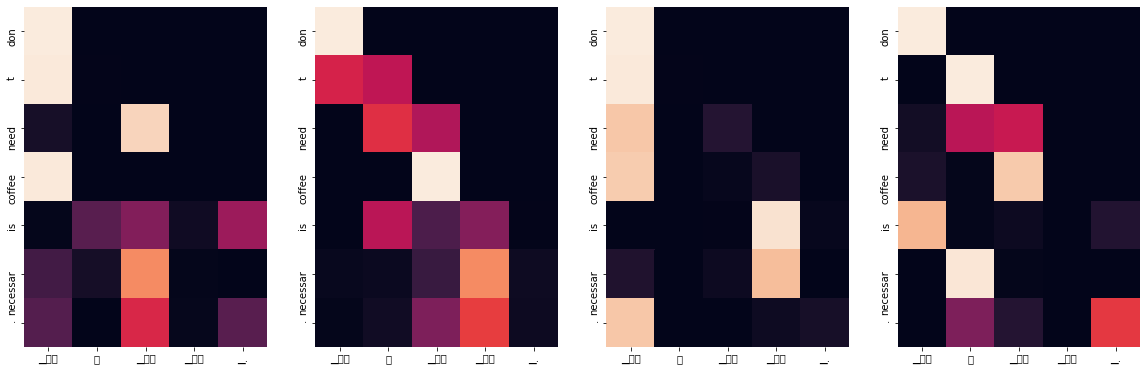

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead monday , with the seven deaths .
Encoder Layer 1


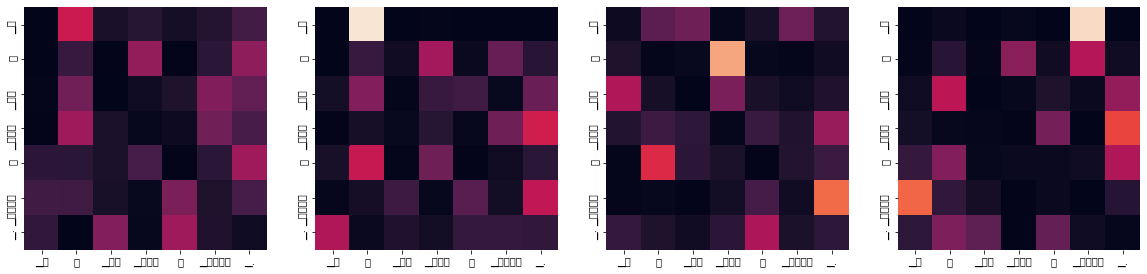

Encoder Layer 2


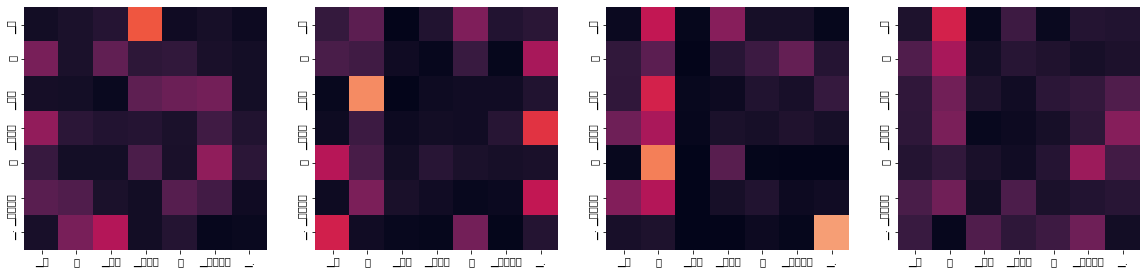

Decoder Self Layer 1


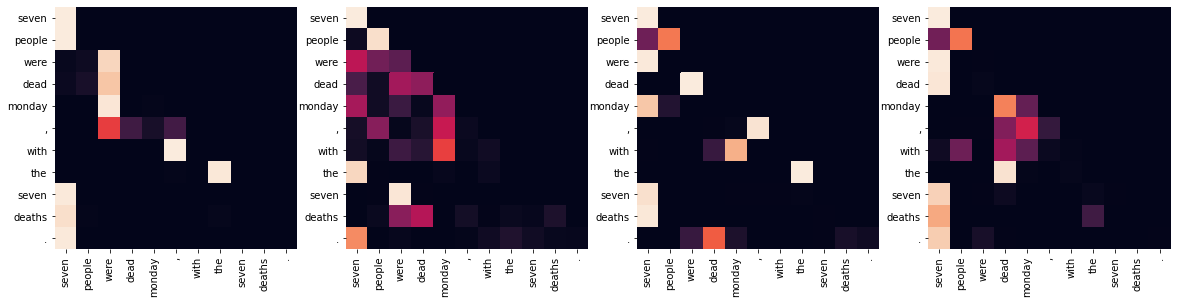

Decoder Src Layer 1


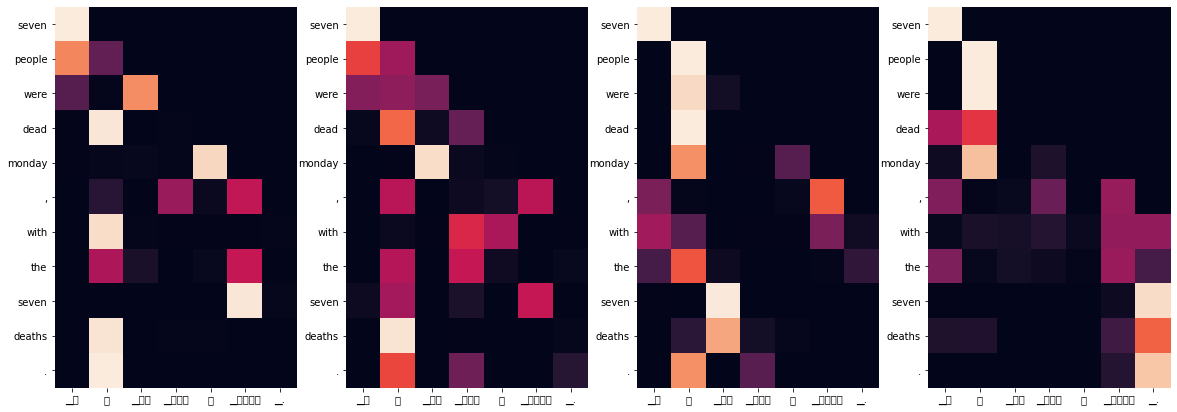

Decoder Self Layer 2


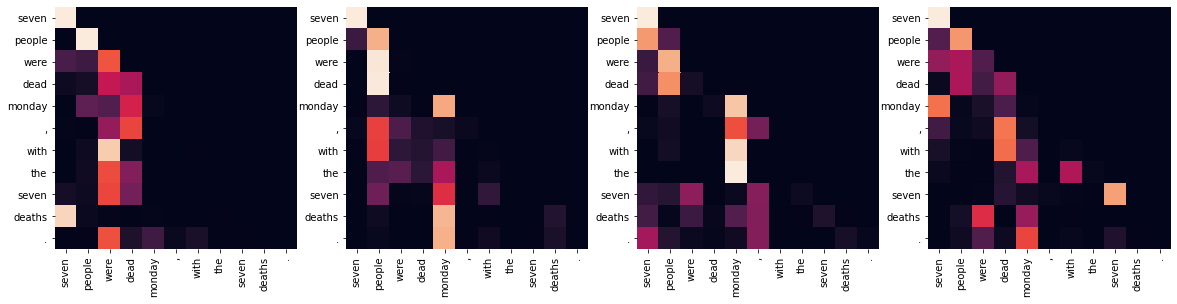

Decoder Src Layer 2


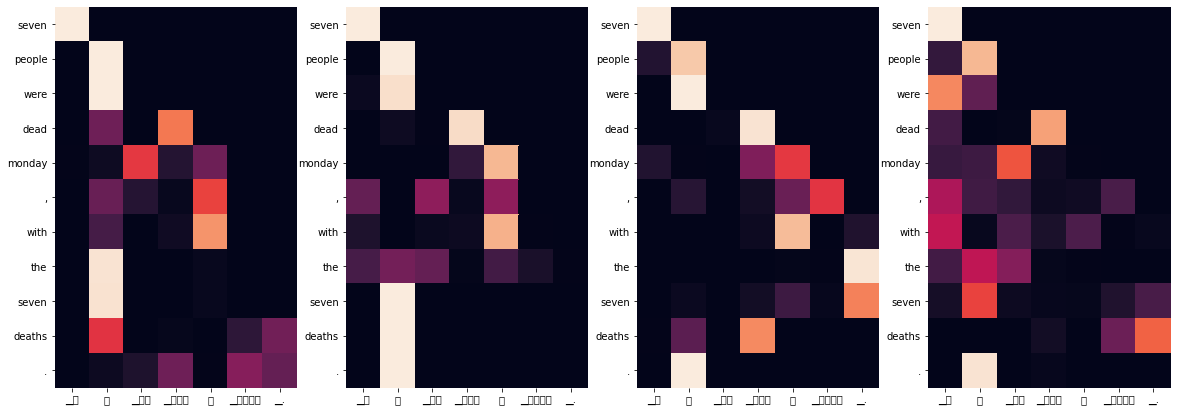

Epoch  8: 100%|██████████| 2127/2127 [08:05<00:00,  4.38it/s, Loss 0.8325]


Input: 오바마는 대통령이다.
Predicted translation: obama is coming president .
Encoder Layer 1


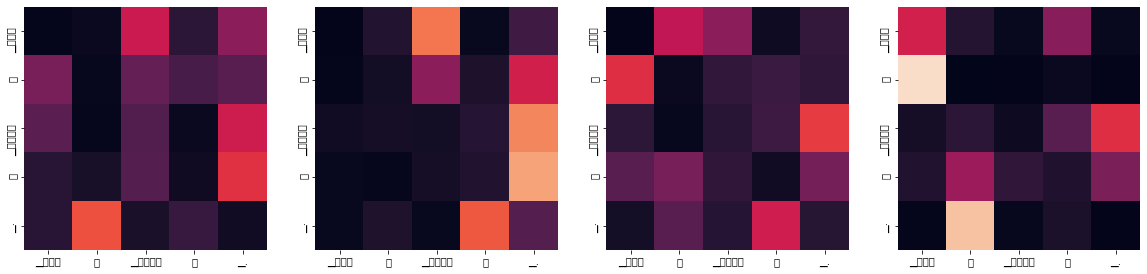

Encoder Layer 2


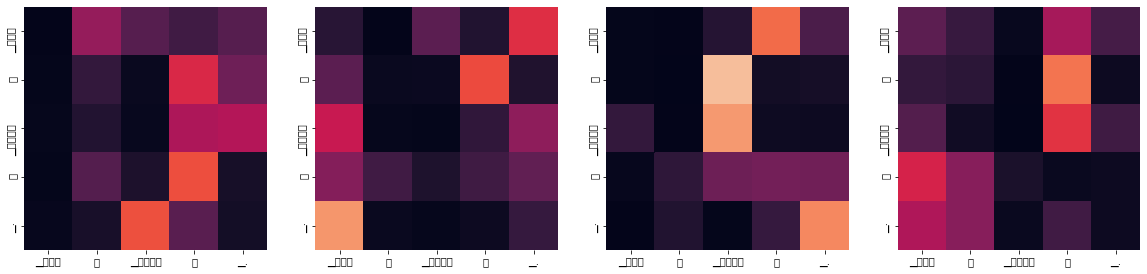

Decoder Self Layer 1


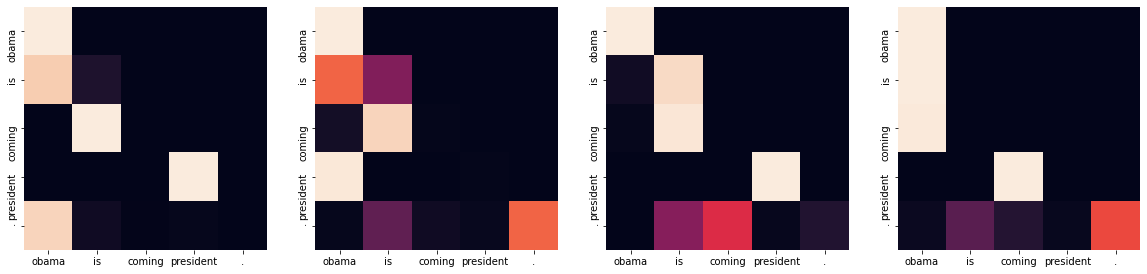

Decoder Src Layer 1


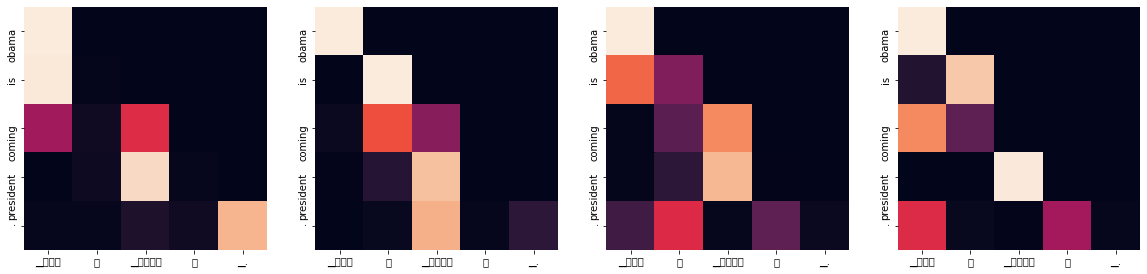

Decoder Self Layer 2


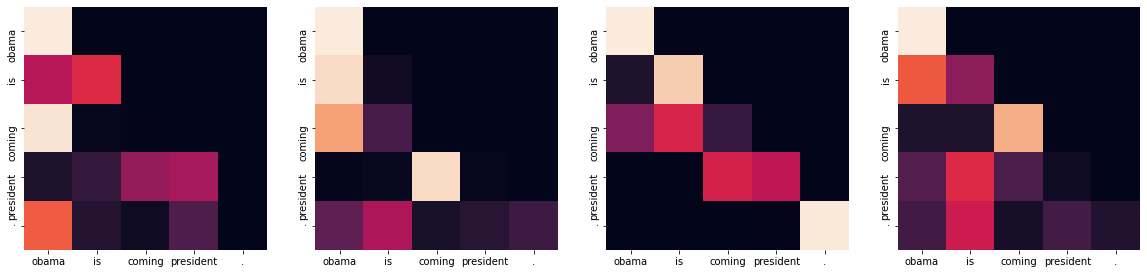

Decoder Src Layer 2


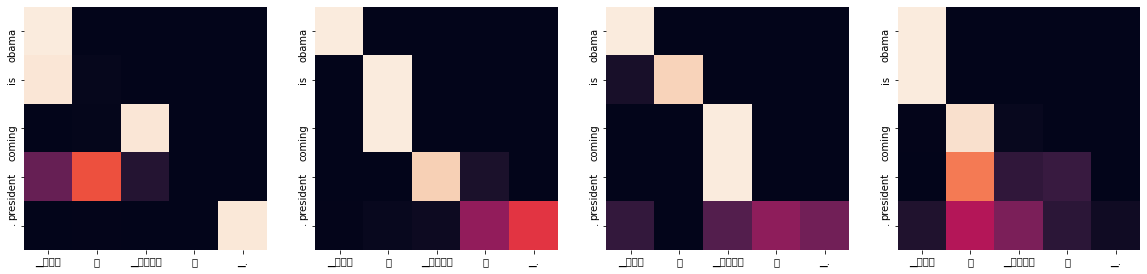

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the only second part of the cities .
Encoder Layer 1


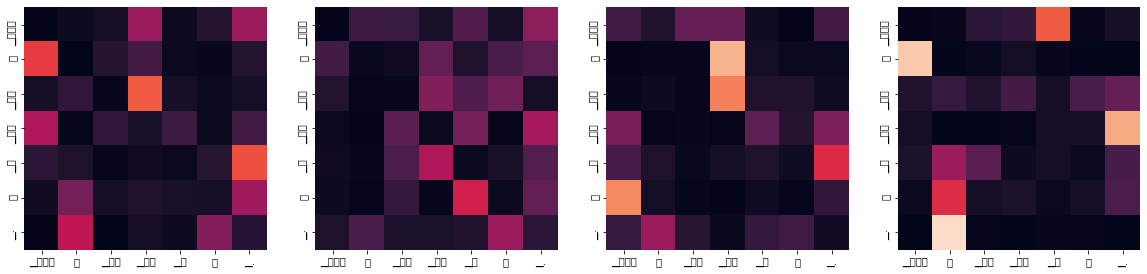

Encoder Layer 2


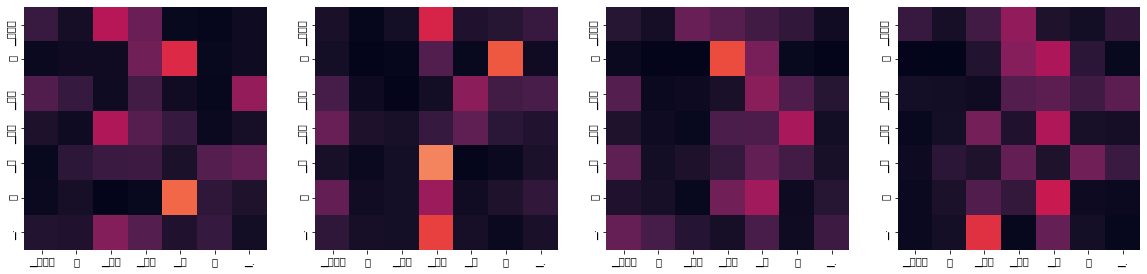

Decoder Self Layer 1


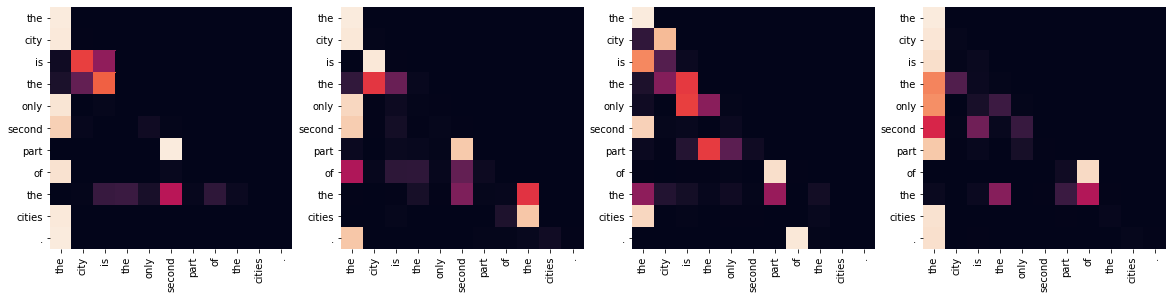

Decoder Src Layer 1


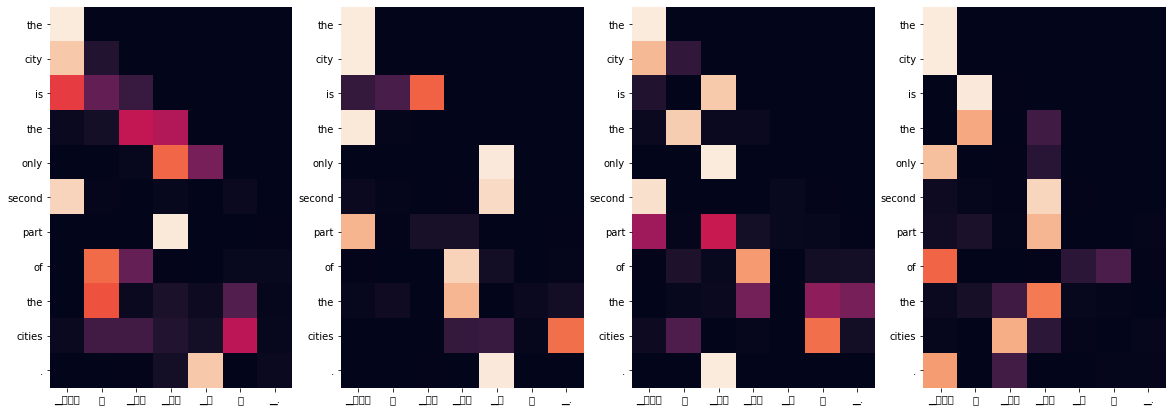

Decoder Self Layer 2


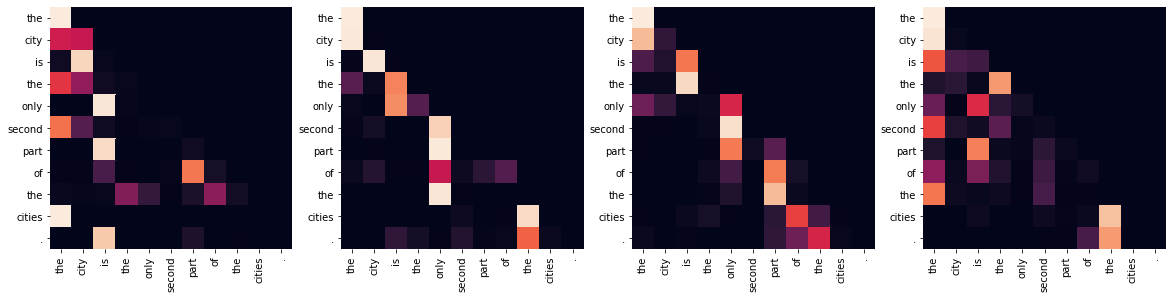

Decoder Src Layer 2


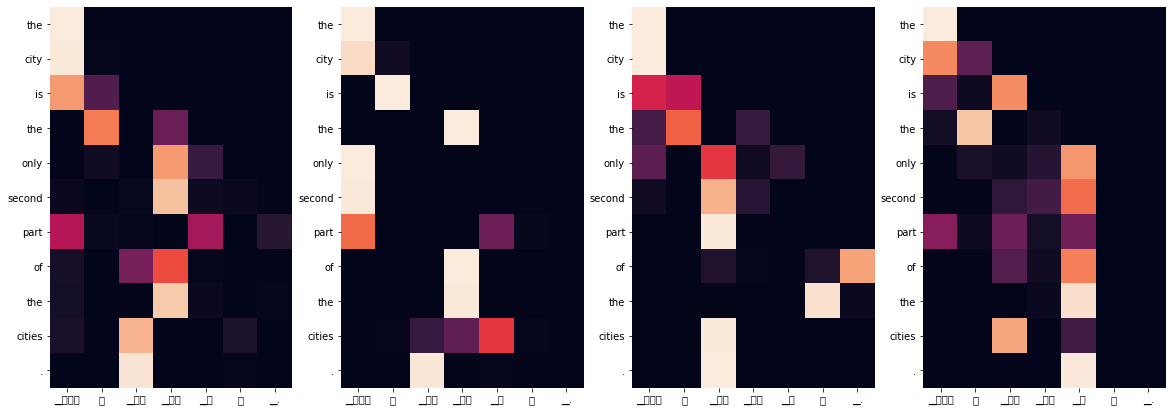

Input: 커피는 필요 없다.
Predicted translation: you don t need to speak for coffee .
Encoder Layer 1


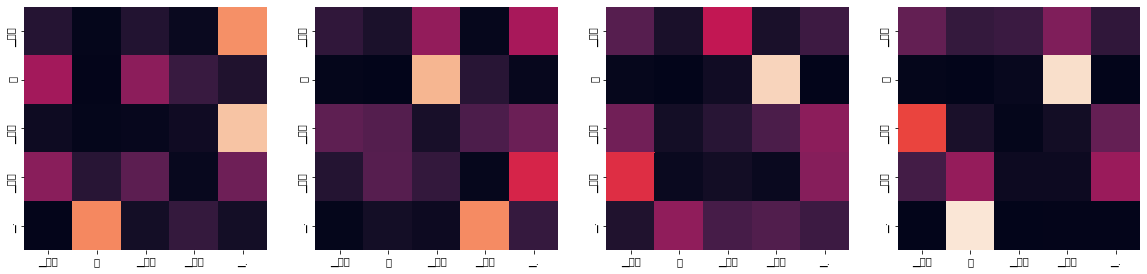

Encoder Layer 2


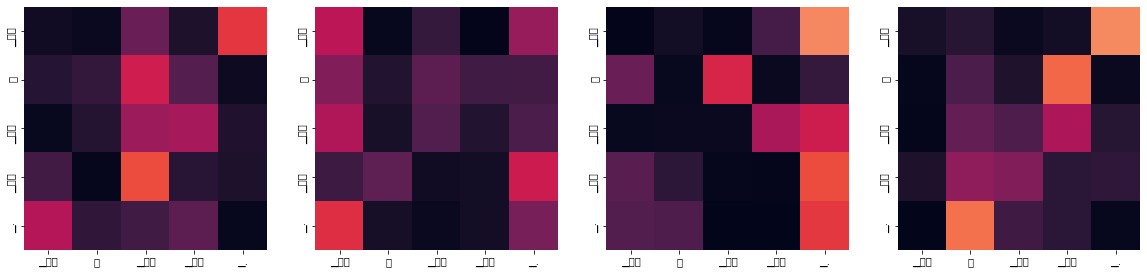

Decoder Self Layer 1


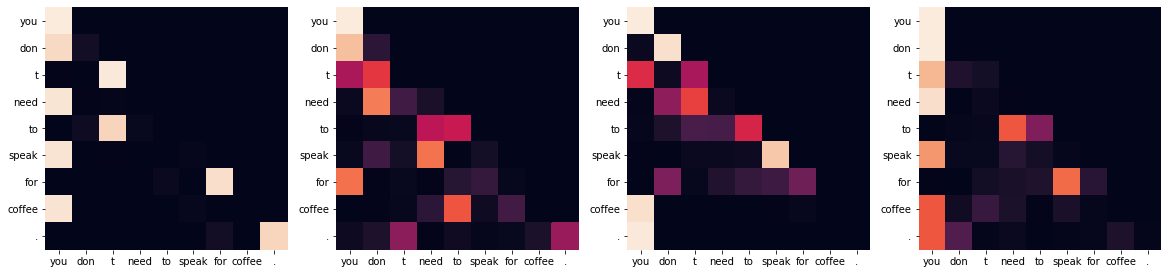

Decoder Src Layer 1


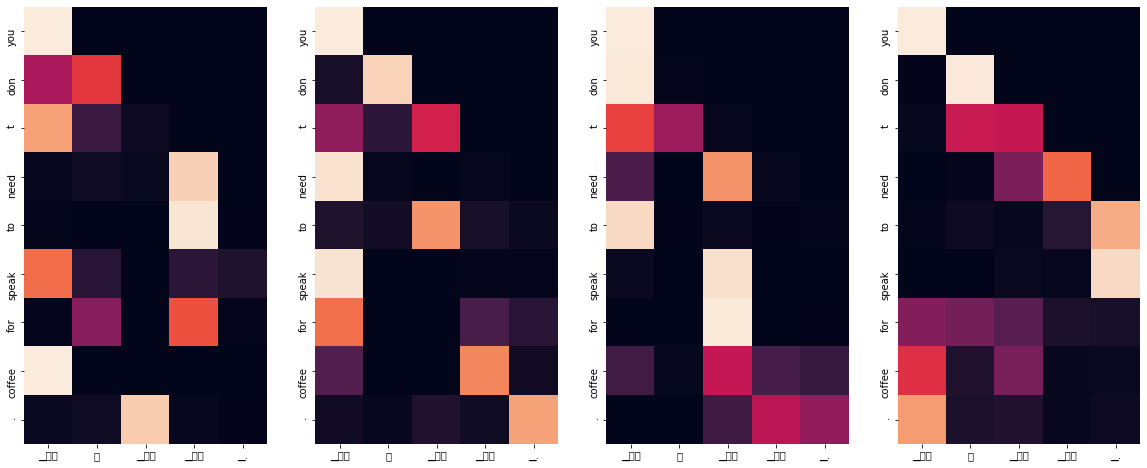

Decoder Self Layer 2


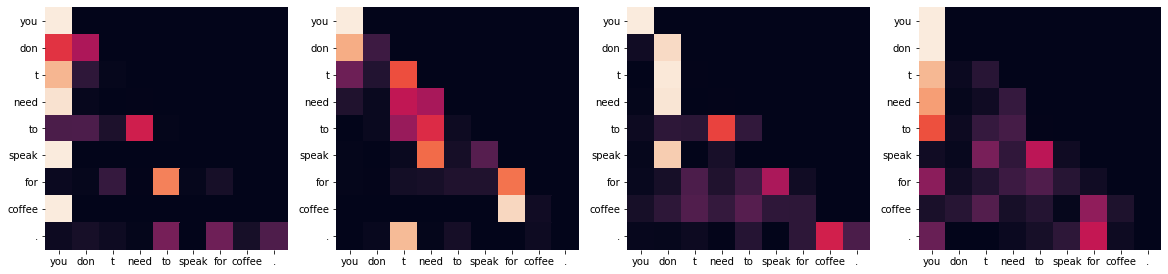

Decoder Src Layer 2


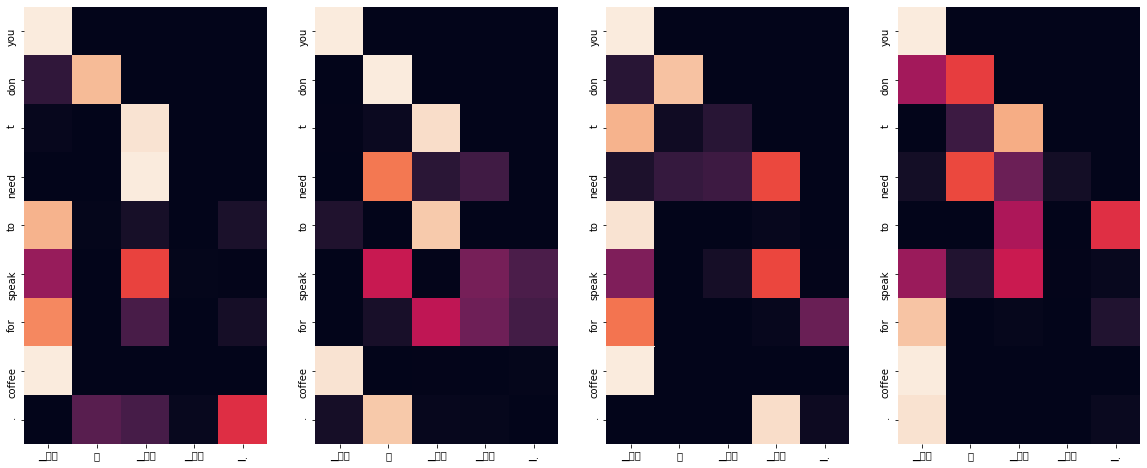

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven people were dead .
Encoder Layer 1


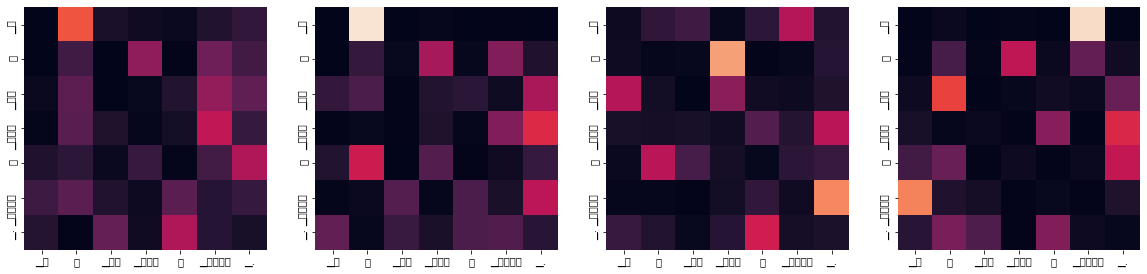

Encoder Layer 2


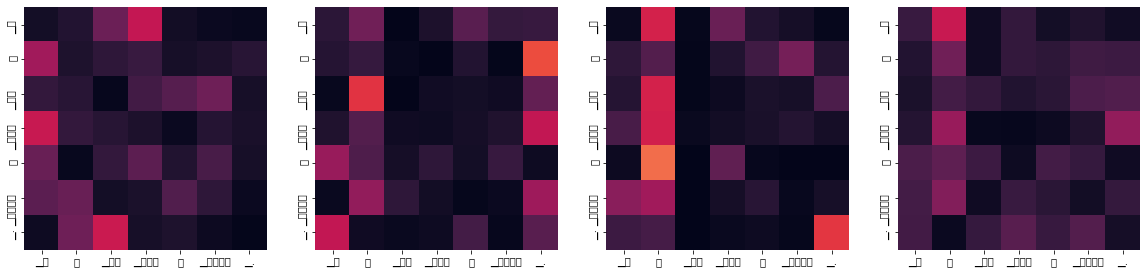

Decoder Self Layer 1


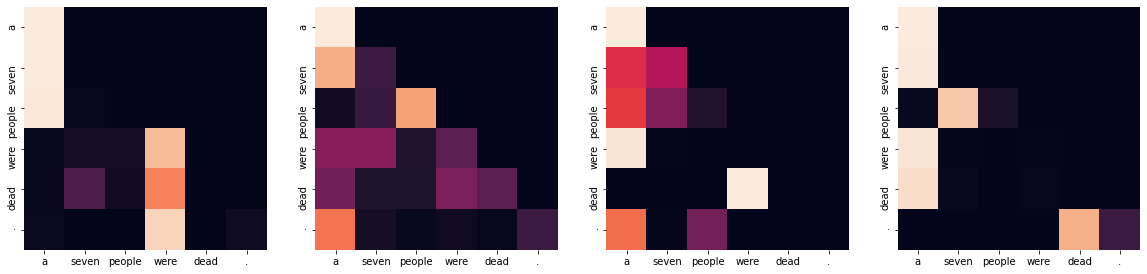

Decoder Src Layer 1


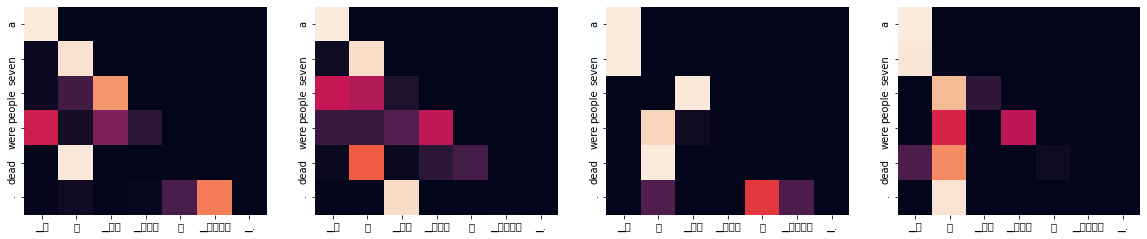

Decoder Self Layer 2


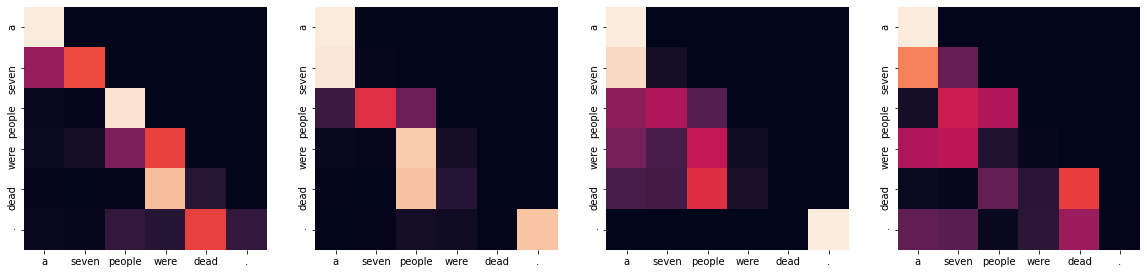

Decoder Src Layer 2


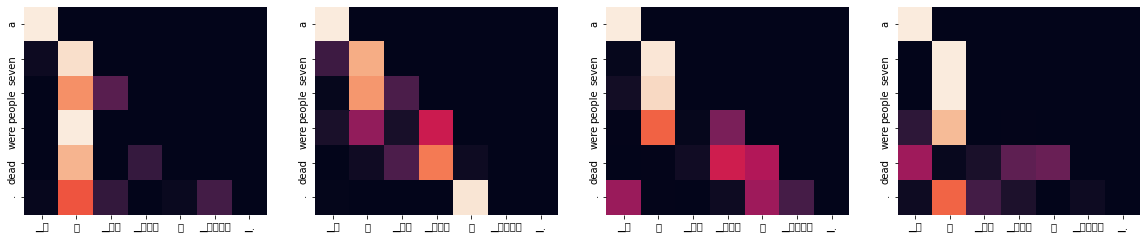

Epoch  9: 100%|██████████| 2127/2127 [07:57<00:00,  4.45it/s, Loss 0.6731]


Input: 오바마는 대통령이다.
Predicted translation: obama much she can address the nation sen .
Encoder Layer 1


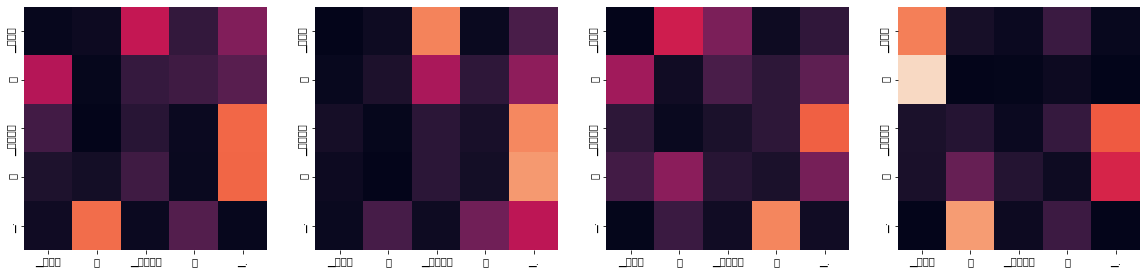

Encoder Layer 2


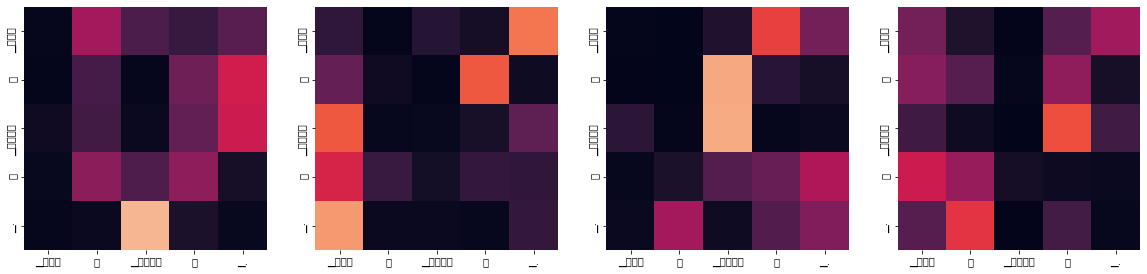

Decoder Self Layer 1


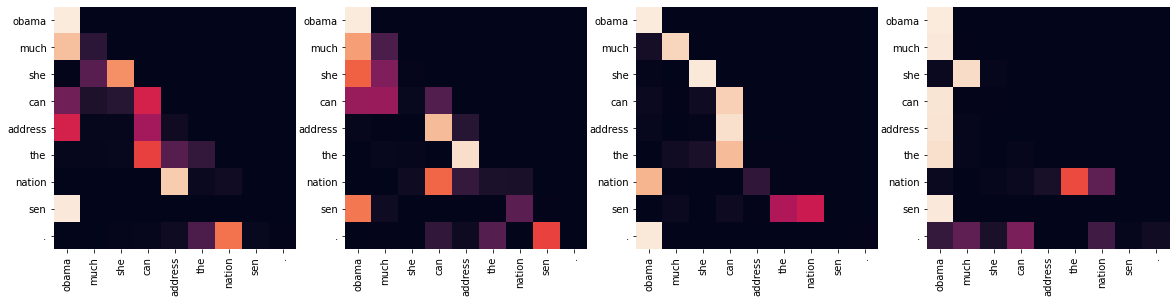

Decoder Src Layer 1


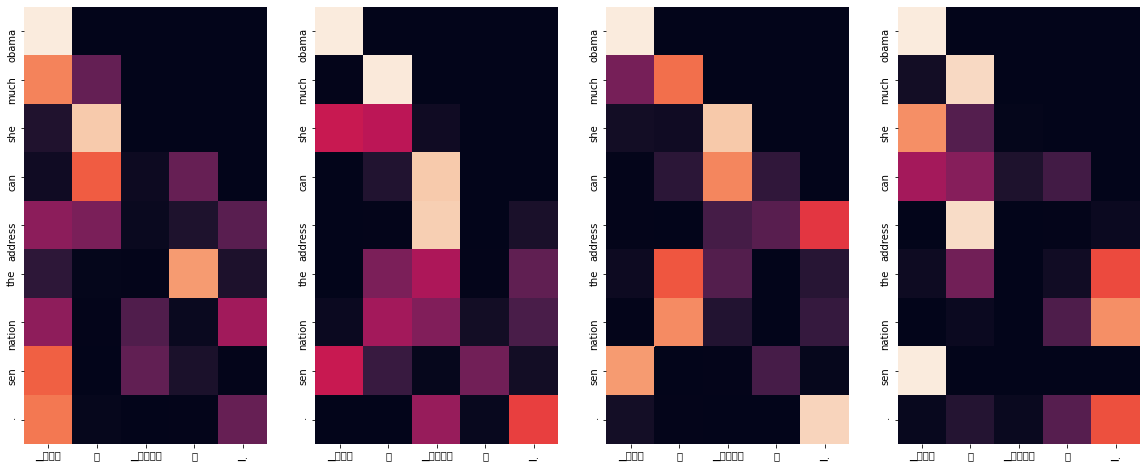

Decoder Self Layer 2


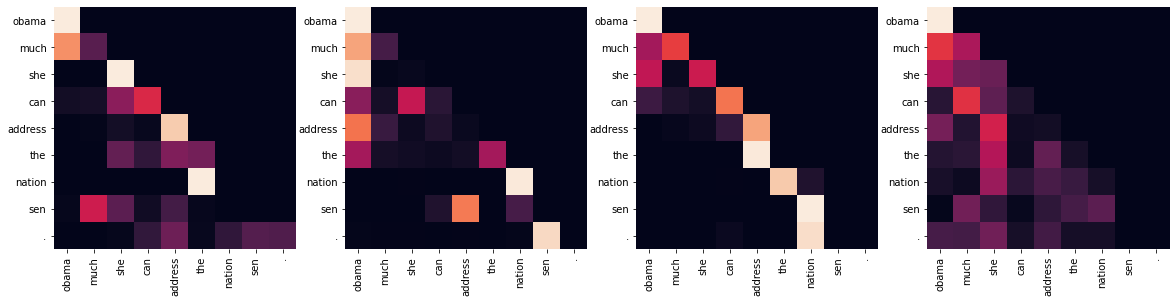

Decoder Src Layer 2


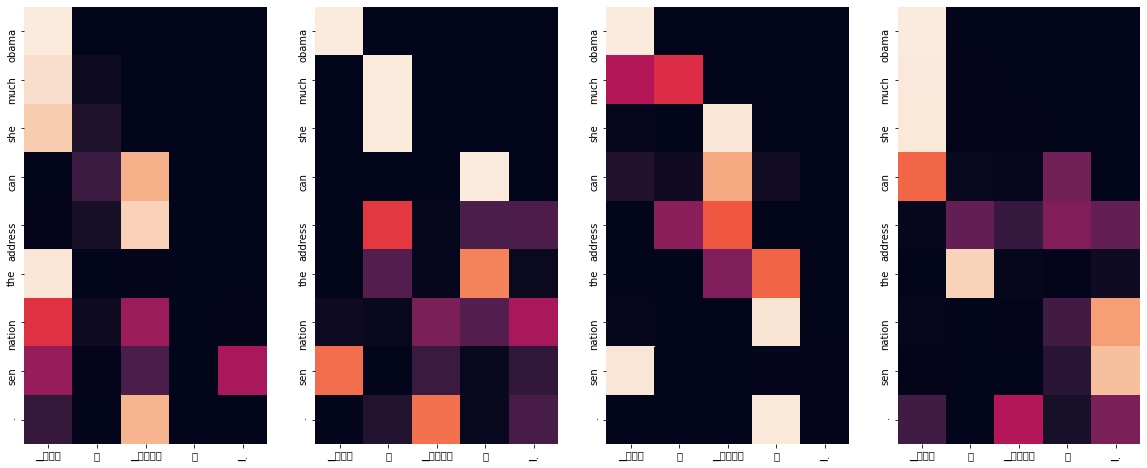

Input: 시민들은 도시 속에 산다.
Predicted translation: they re hail their city .
Encoder Layer 1


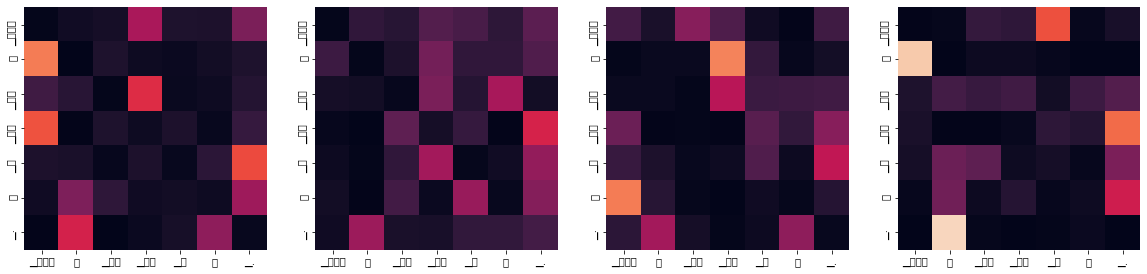

Encoder Layer 2


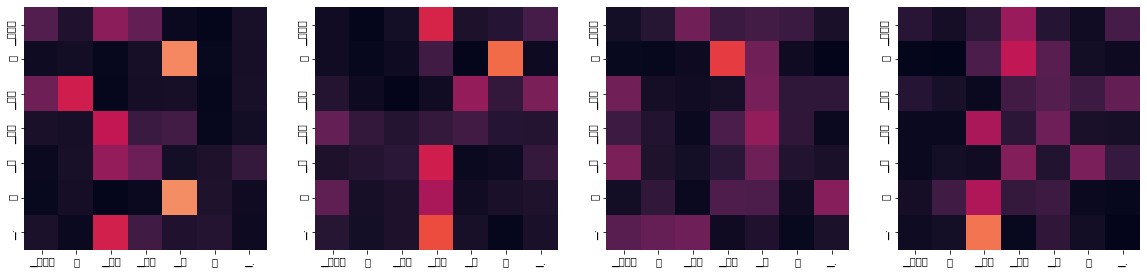

Decoder Self Layer 1


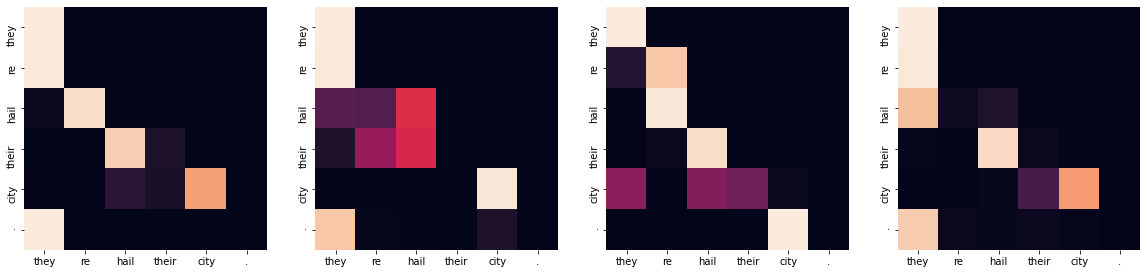

Decoder Src Layer 1


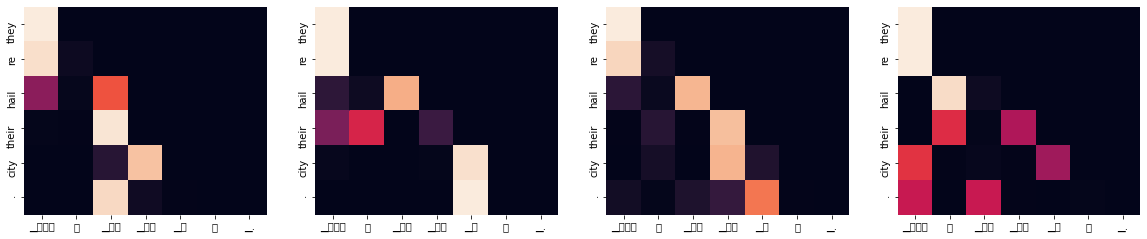

Decoder Self Layer 2


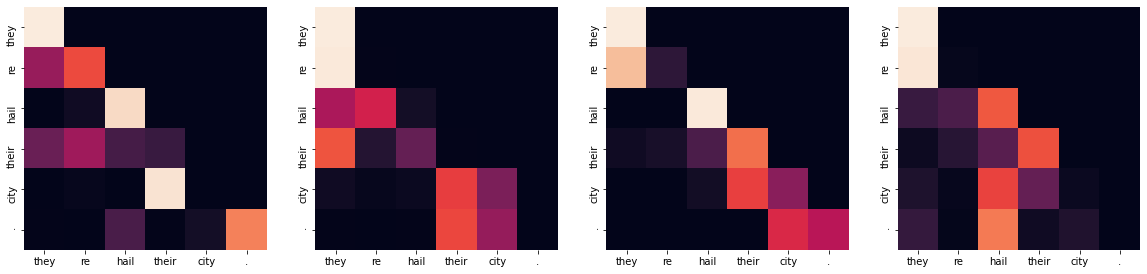

Decoder Src Layer 2


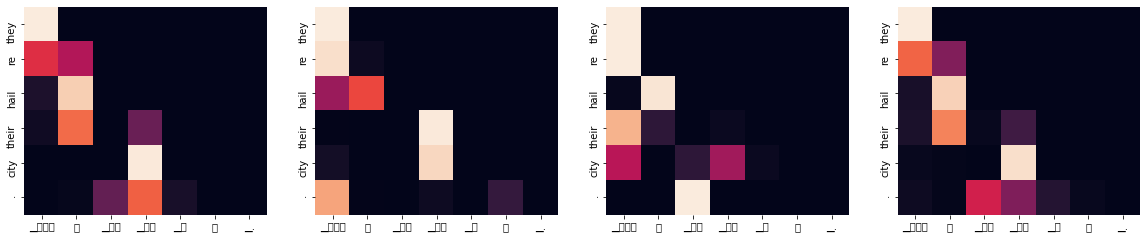

Input: 커피는 필요 없다.
Predicted translation: don t need coffee wear .
Encoder Layer 1


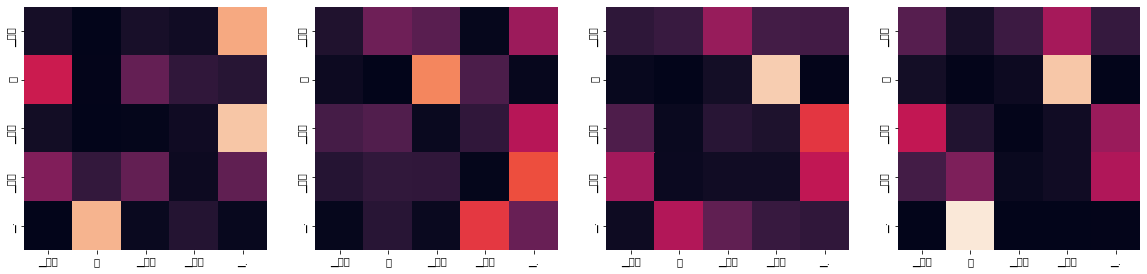

Encoder Layer 2


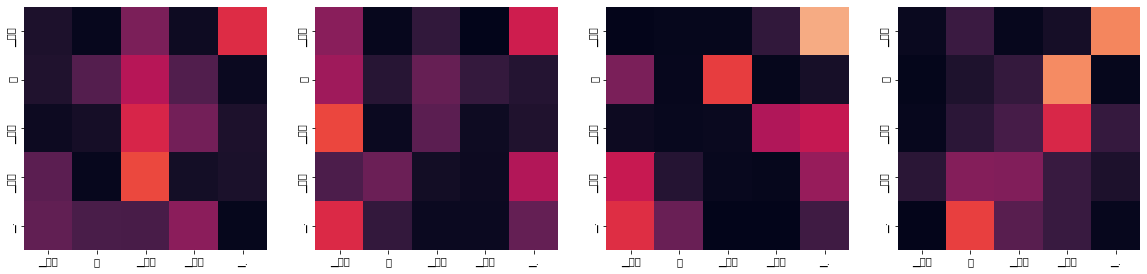

Decoder Self Layer 1


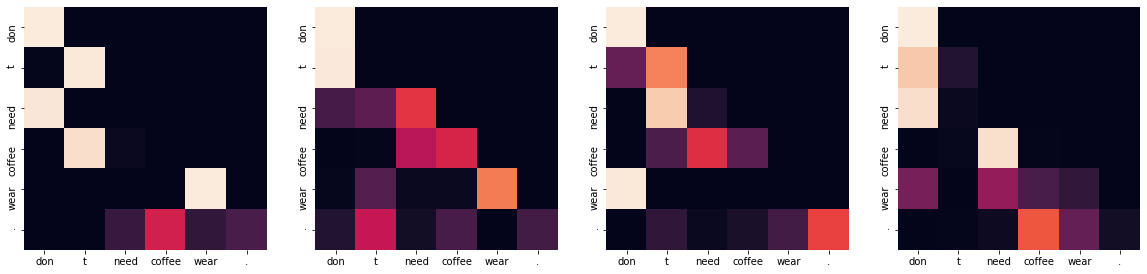

Decoder Src Layer 1


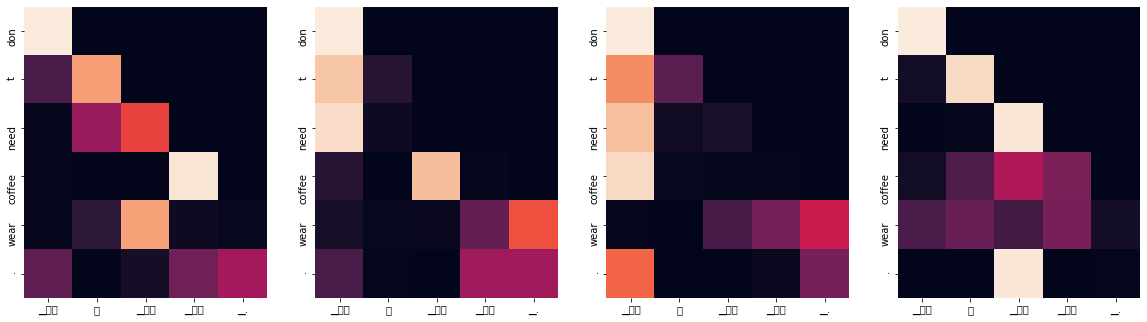

Decoder Self Layer 2


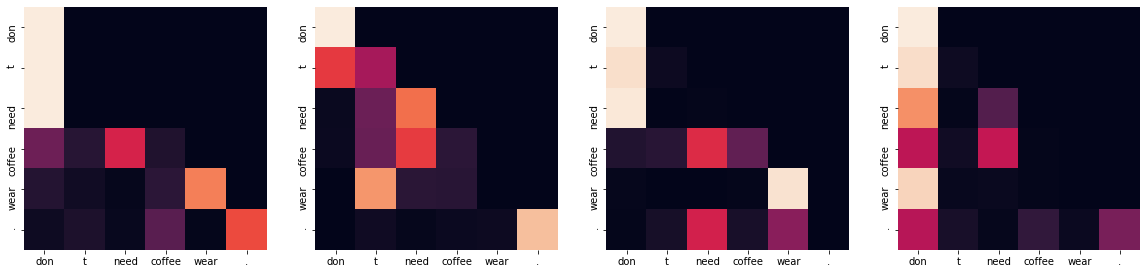

Decoder Src Layer 2


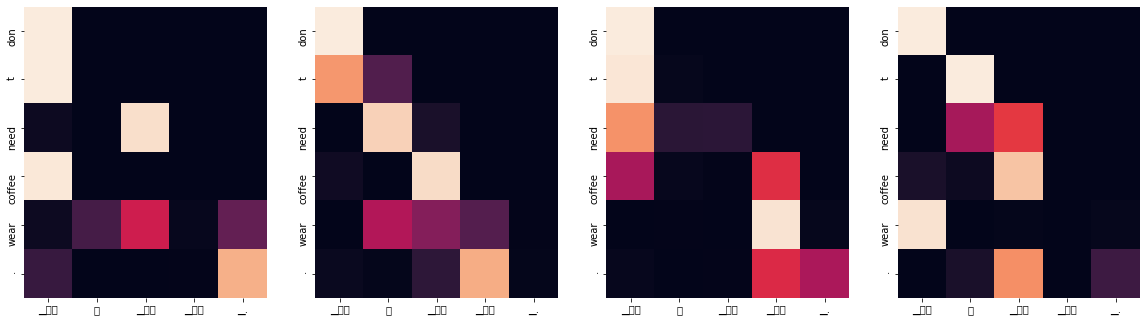

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven people the seven death toll was not rise .
Encoder Layer 1


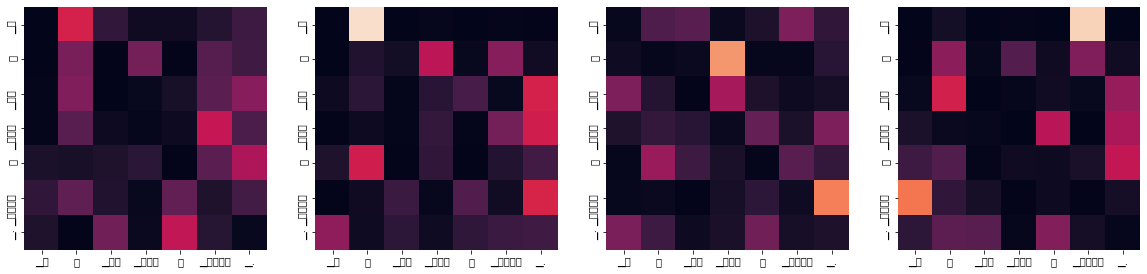

Encoder Layer 2


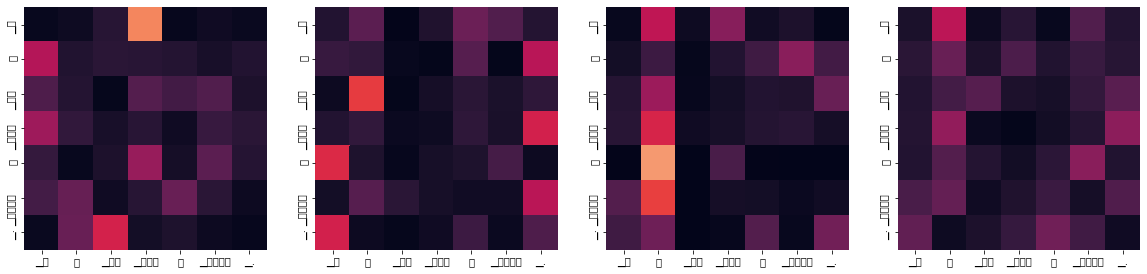

Decoder Self Layer 1


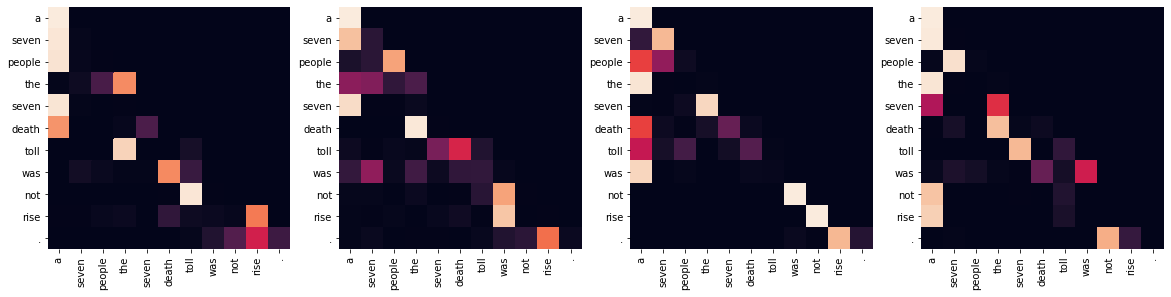

Decoder Src Layer 1


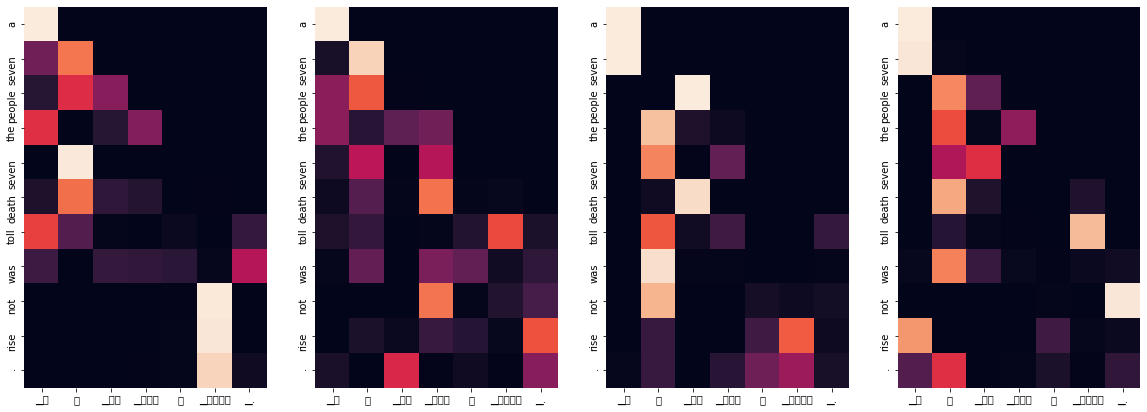

Decoder Self Layer 2


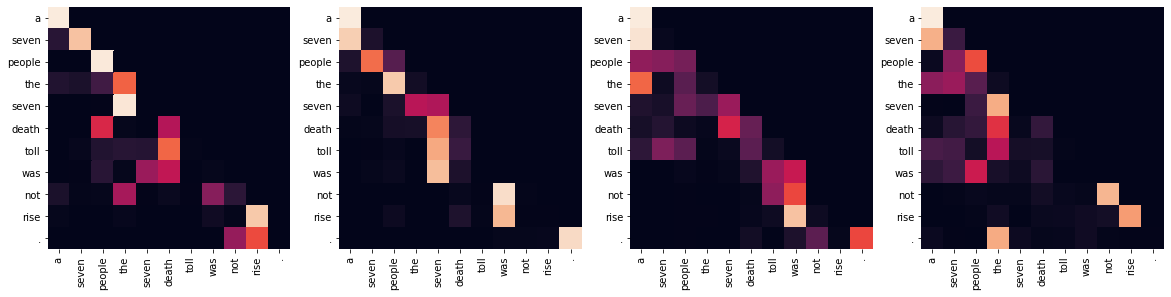

Decoder Src Layer 2


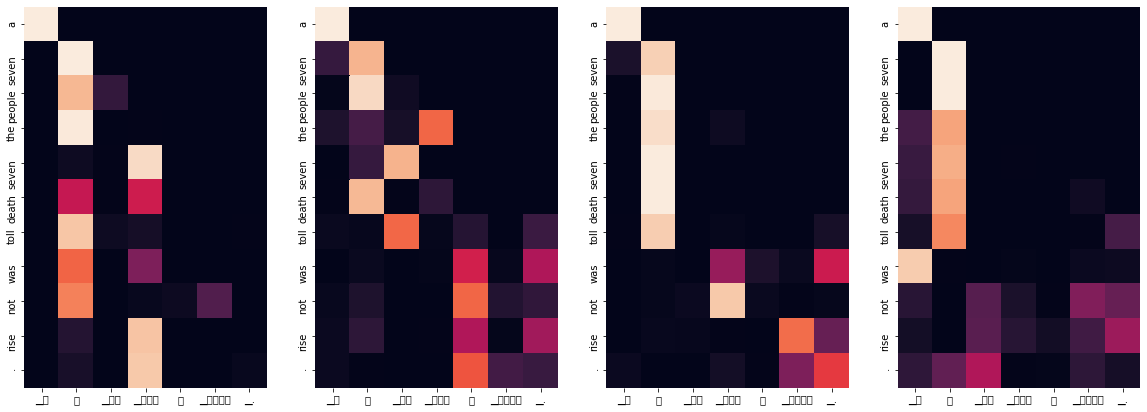

Epoch 10: 100%|██████████| 2127/2127 [07:59<00:00,  4.44it/s, Loss 0.5678]


Input: 오바마는 대통령이다.
Predicted translation: obama is less unpopular .
Encoder Layer 1


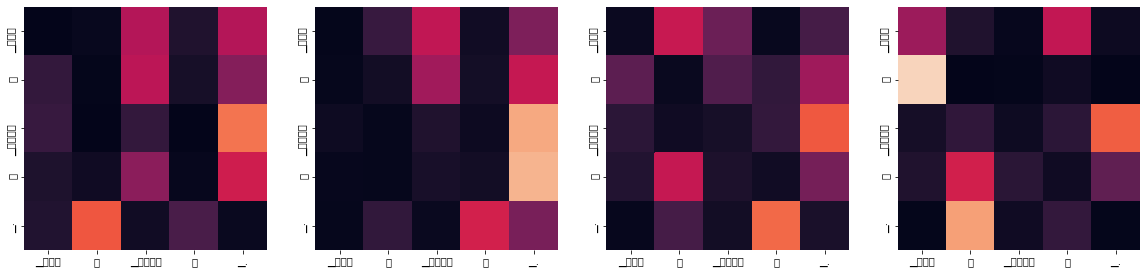

Encoder Layer 2


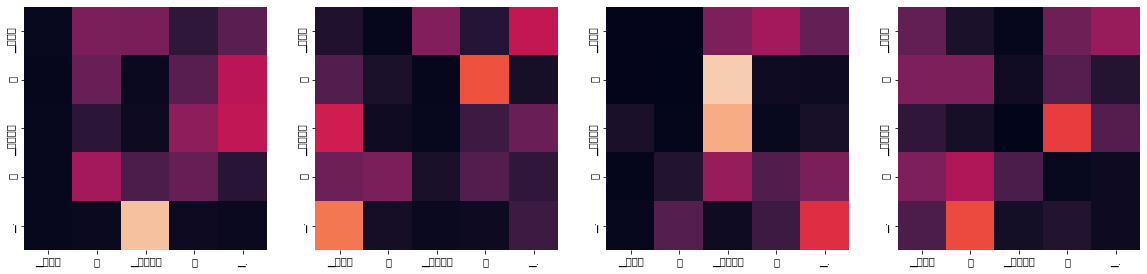

Decoder Self Layer 1


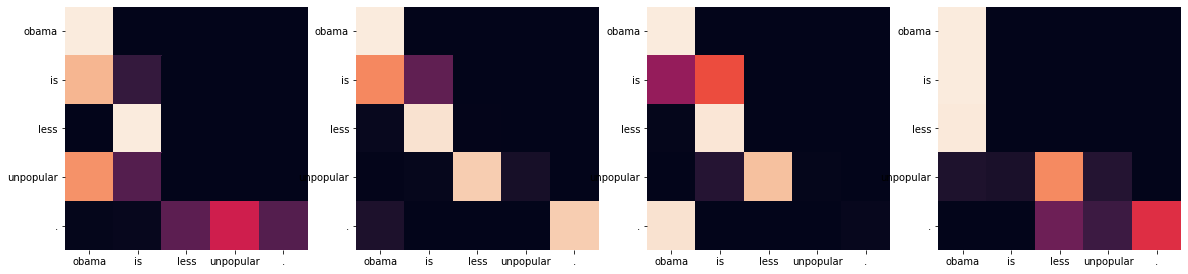

Decoder Src Layer 1


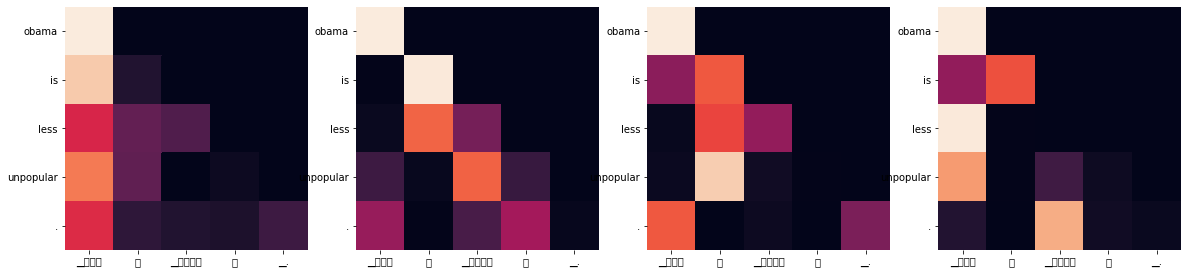

Decoder Self Layer 2


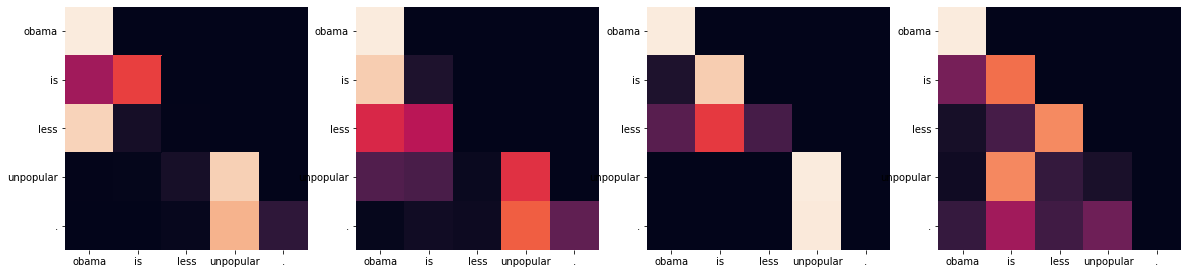

Decoder Src Layer 2


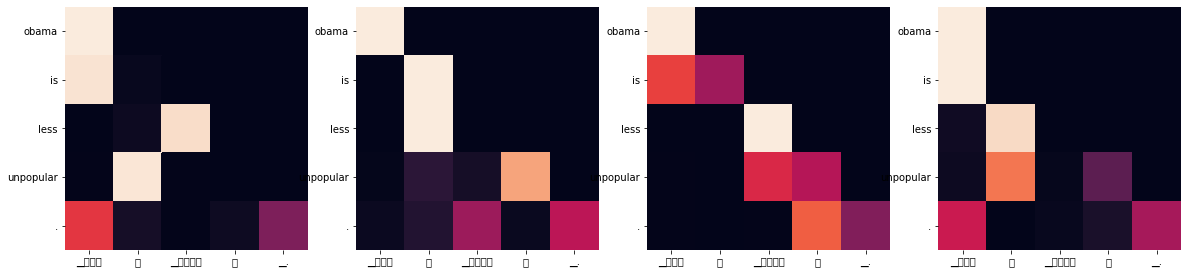

Input: 시민들은 도시 속에 산다.
Predicted translation: some b this town on the second floor of the cities .
Encoder Layer 1


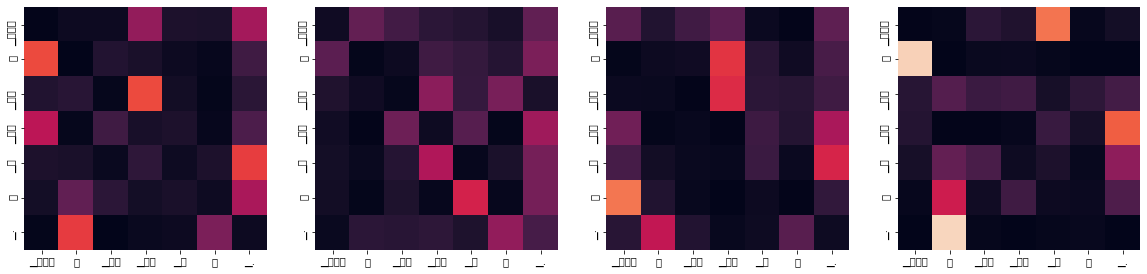

Encoder Layer 2


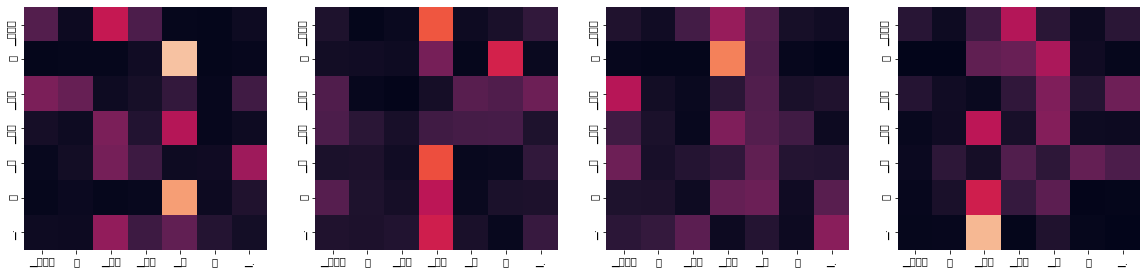

Decoder Self Layer 1


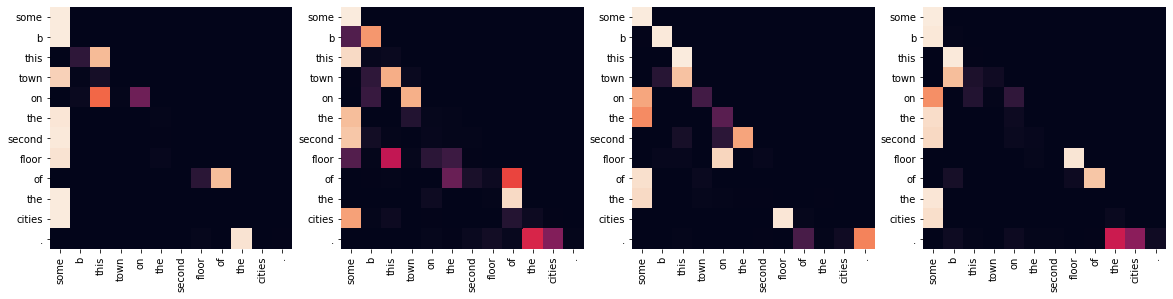

Decoder Src Layer 1


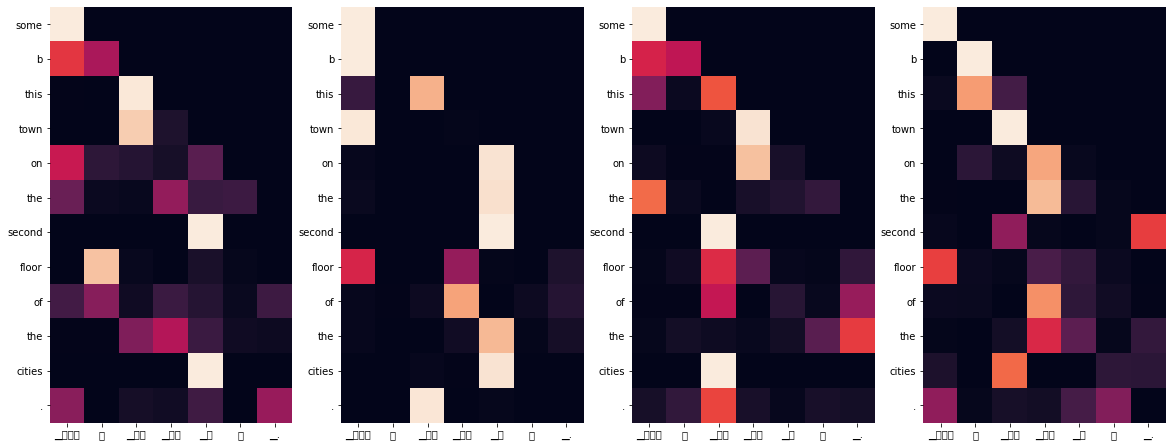

Decoder Self Layer 2


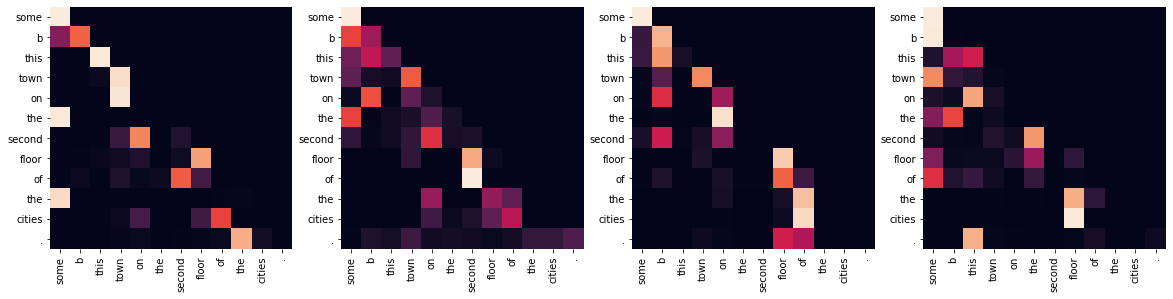

Decoder Src Layer 2


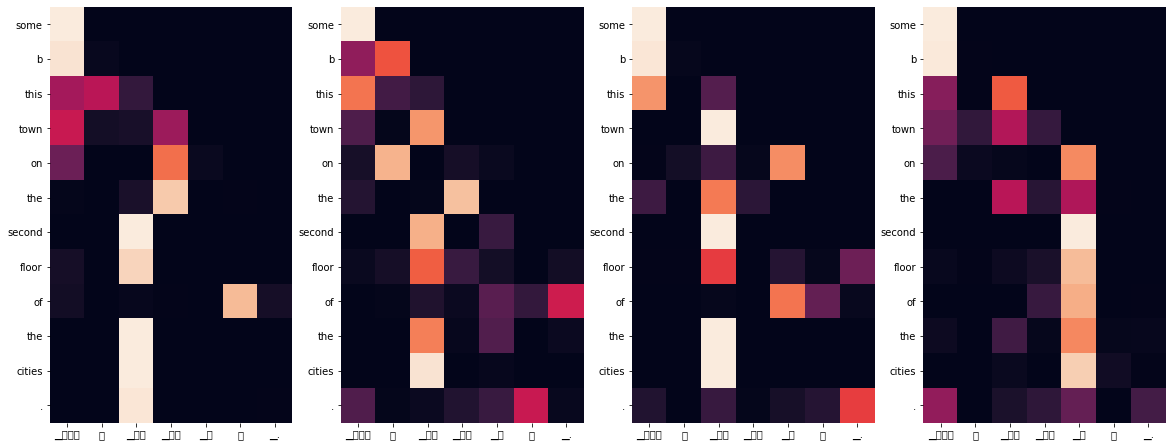

Input: 커피는 필요 없다.
Predicted translation: don t need coffee , he said .
Encoder Layer 1


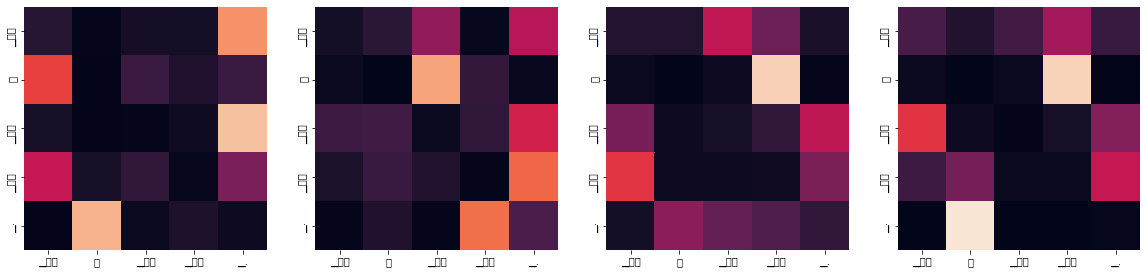

Encoder Layer 2


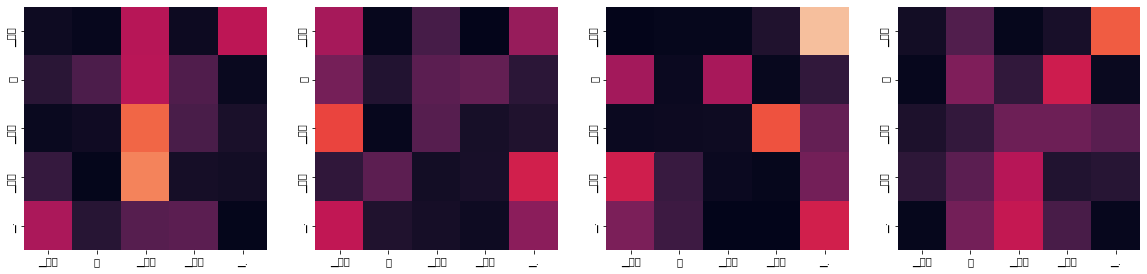

Decoder Self Layer 1


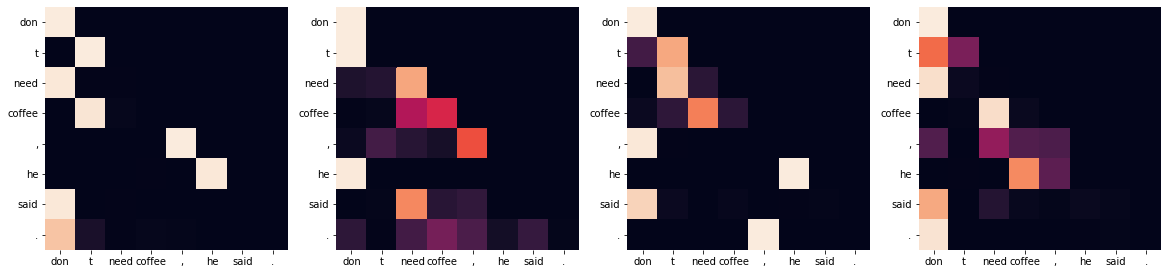

Decoder Src Layer 1


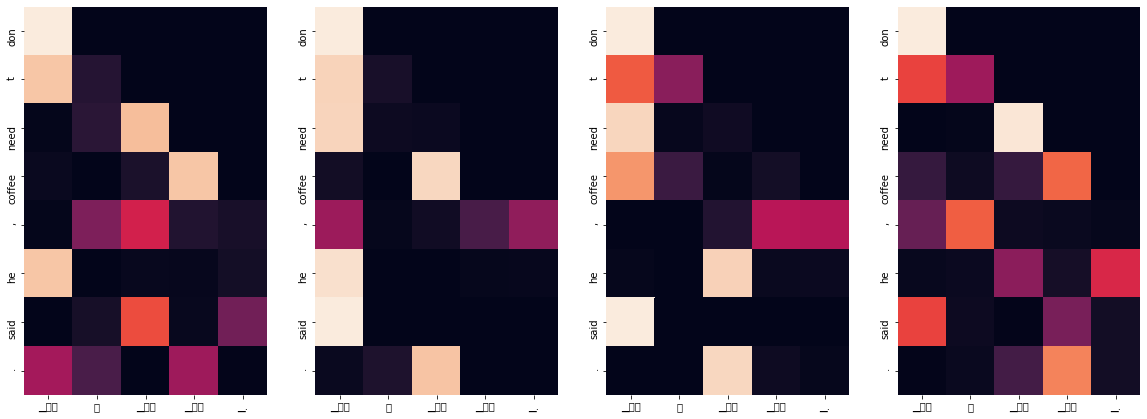

Decoder Self Layer 2


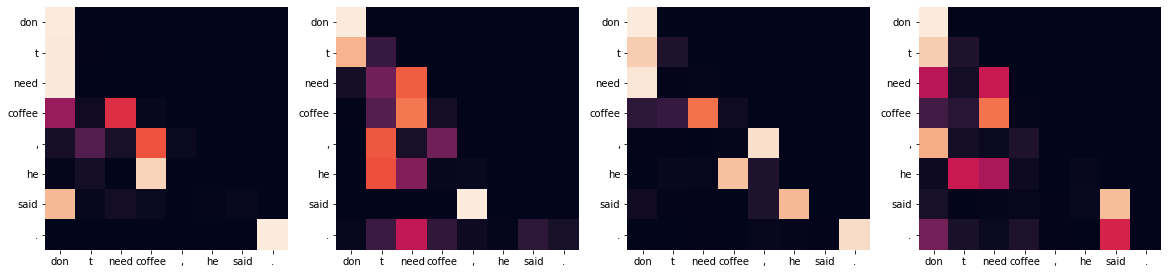

Decoder Src Layer 2


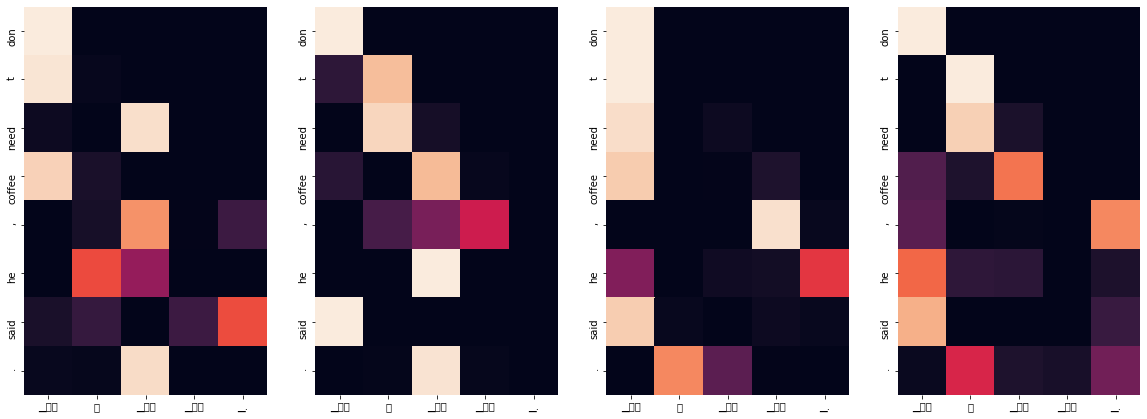

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead .
Encoder Layer 1


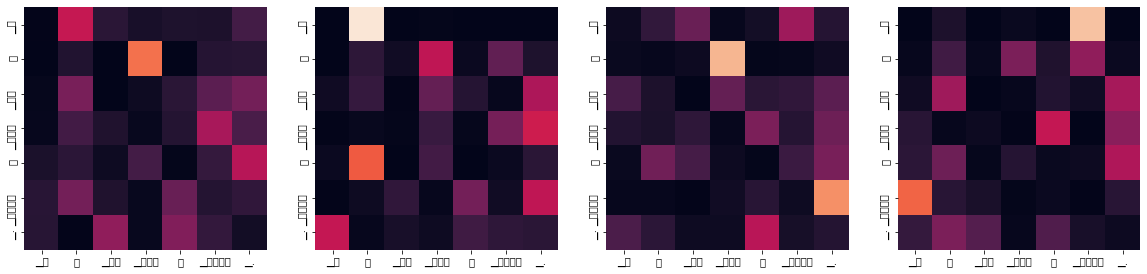

Encoder Layer 2


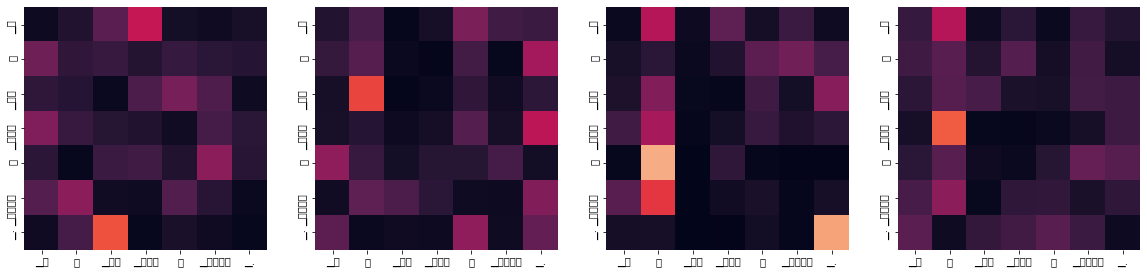

Decoder Self Layer 1


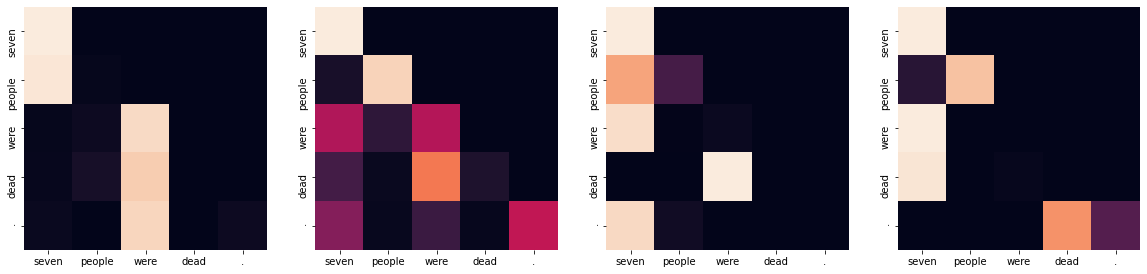

Decoder Src Layer 1


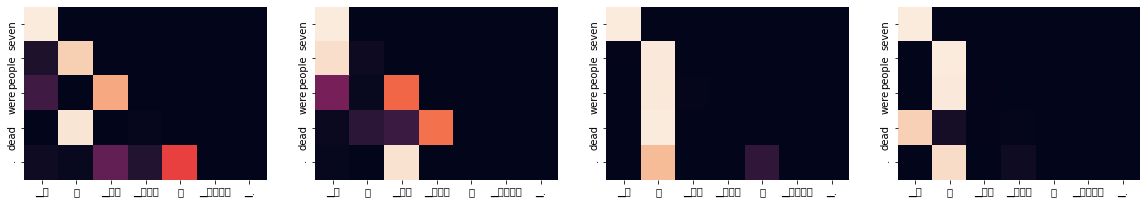

Decoder Self Layer 2


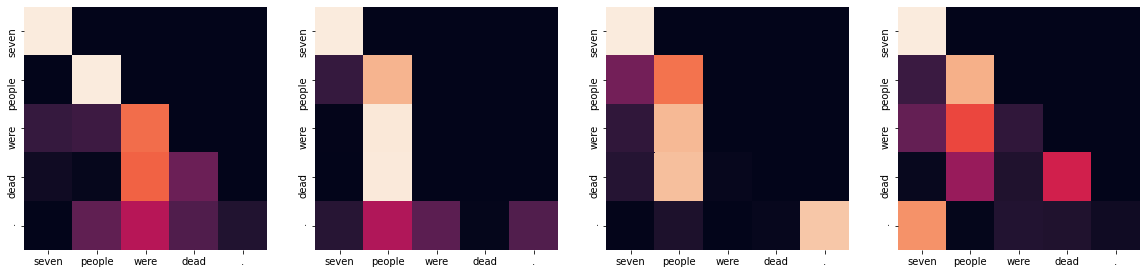

Decoder Src Layer 2


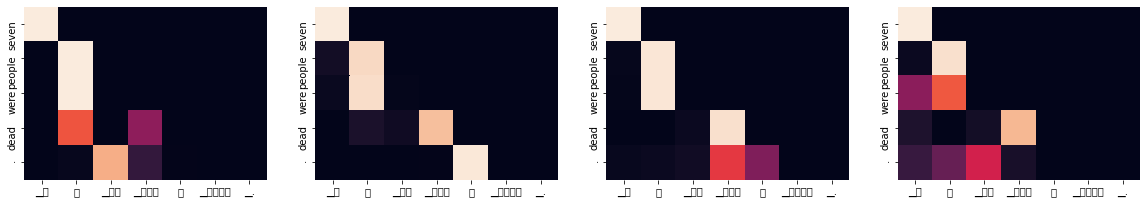

Epoch 11: 100%|██████████| 2127/2127 [07:58<00:00,  4.44it/s, Loss 0.4975]


Input: 오바마는 대통령이다.
Predicted translation: obama is our country .
Encoder Layer 1


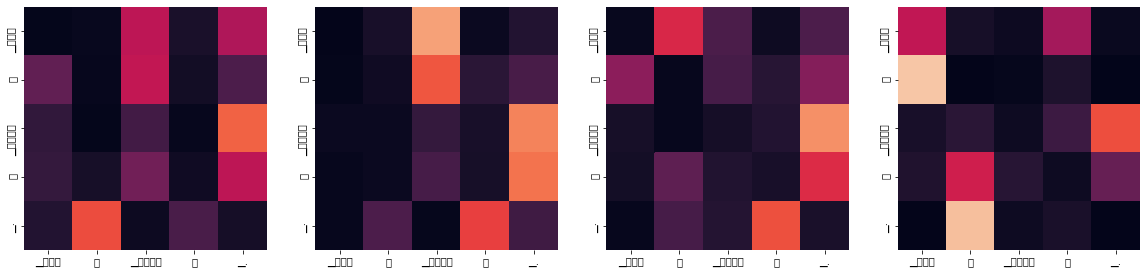

Encoder Layer 2


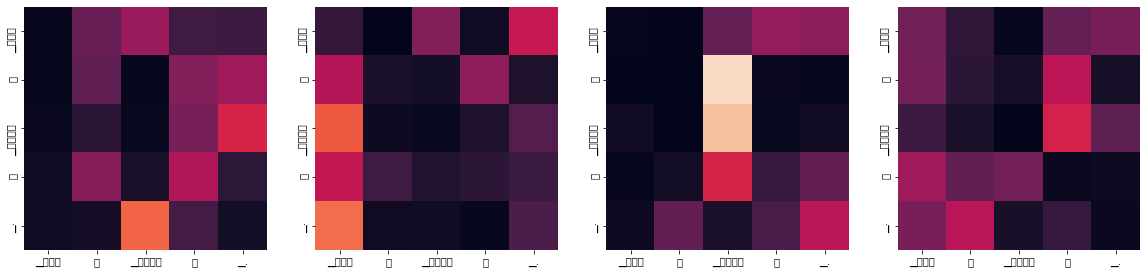

Decoder Self Layer 1


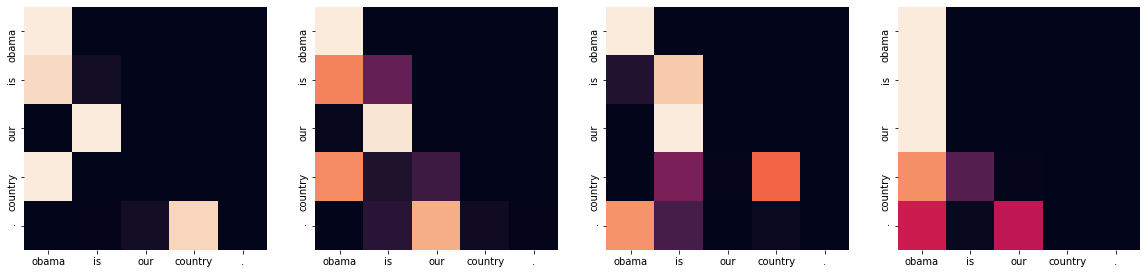

Decoder Src Layer 1


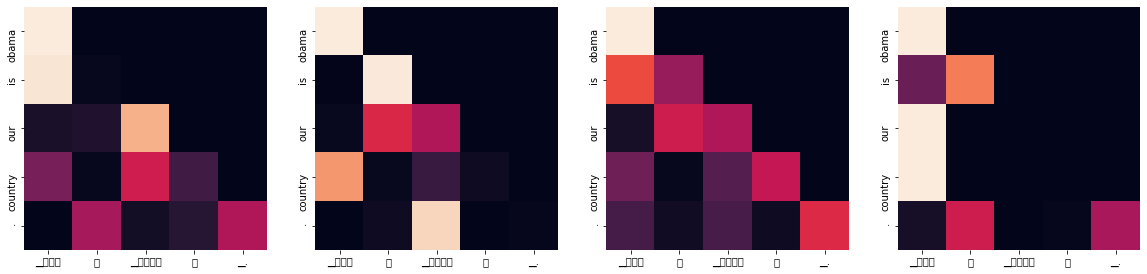

Decoder Self Layer 2


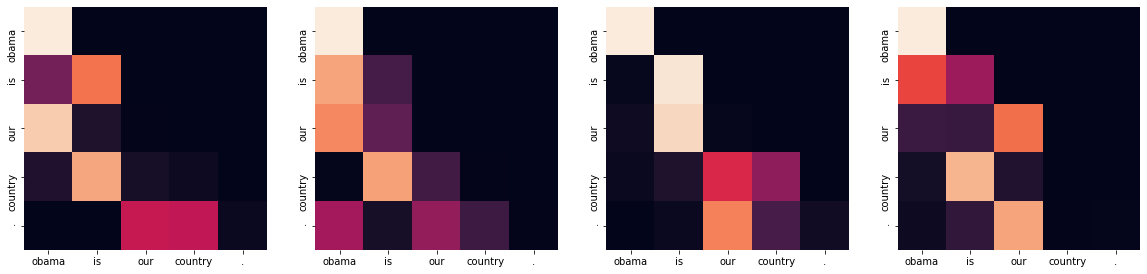

Decoder Src Layer 2


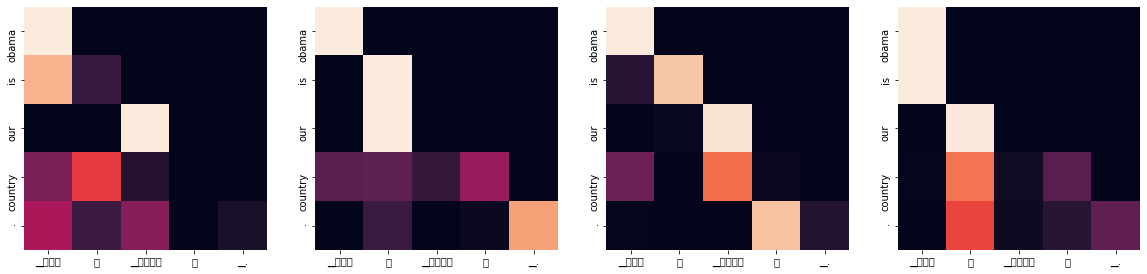

Input: 시민들은 도시 속에 산다.
Predicted translation: they re the second city .
Encoder Layer 1


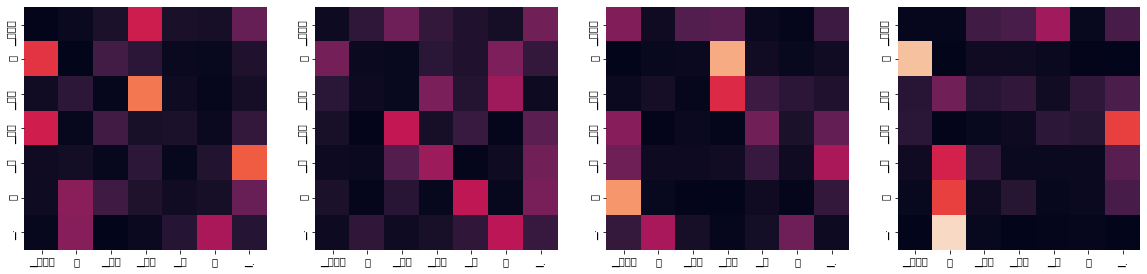

Encoder Layer 2


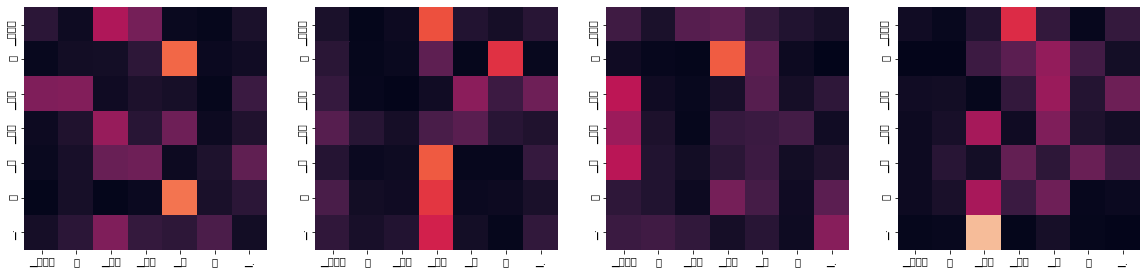

Decoder Self Layer 1


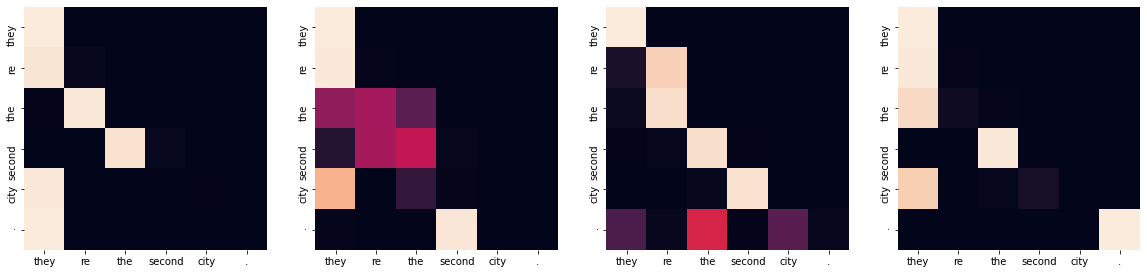

Decoder Src Layer 1


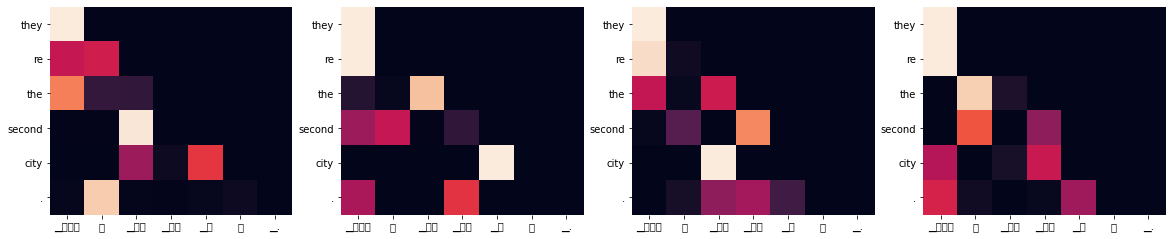

Decoder Self Layer 2


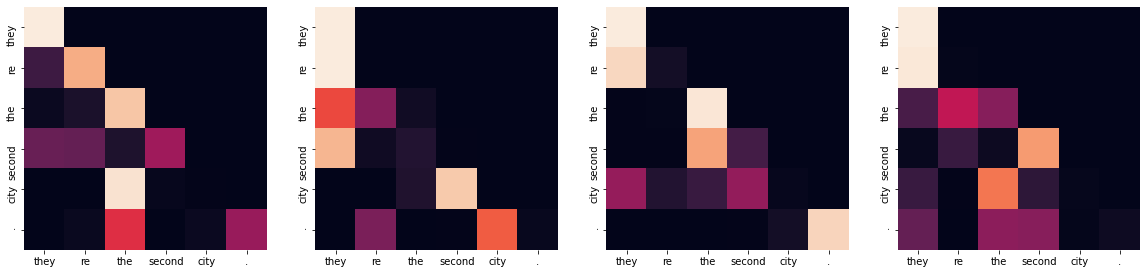

Decoder Src Layer 2


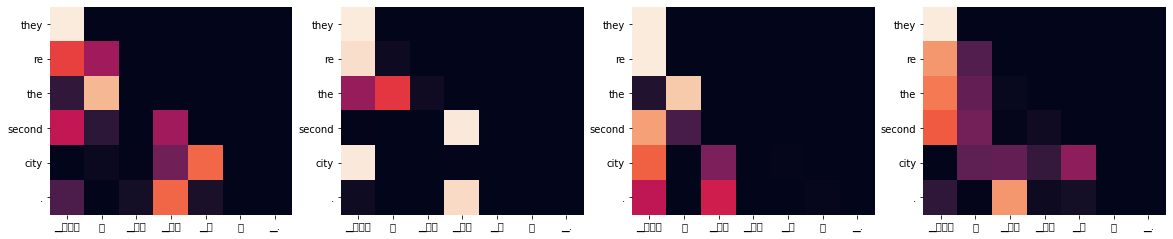

Input: 커피는 필요 없다.
Predicted translation: coffee
Encoder Layer 1


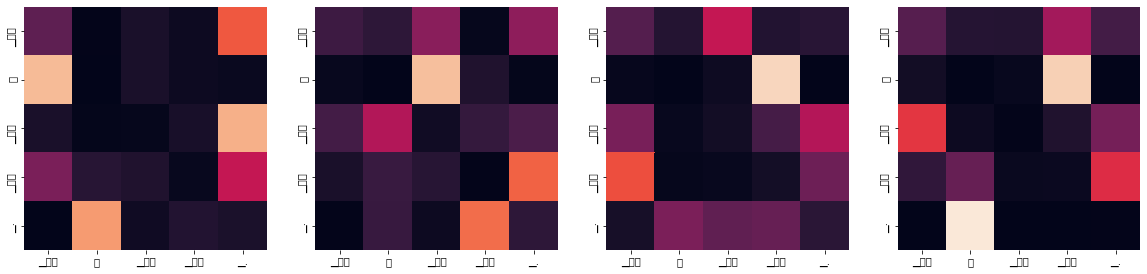

Encoder Layer 2


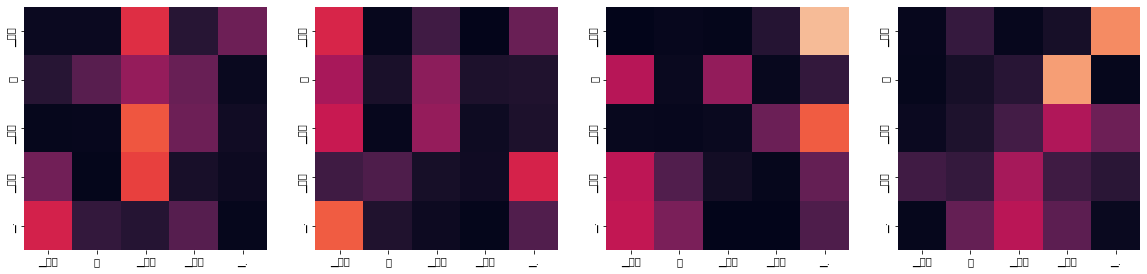

Decoder Self Layer 1


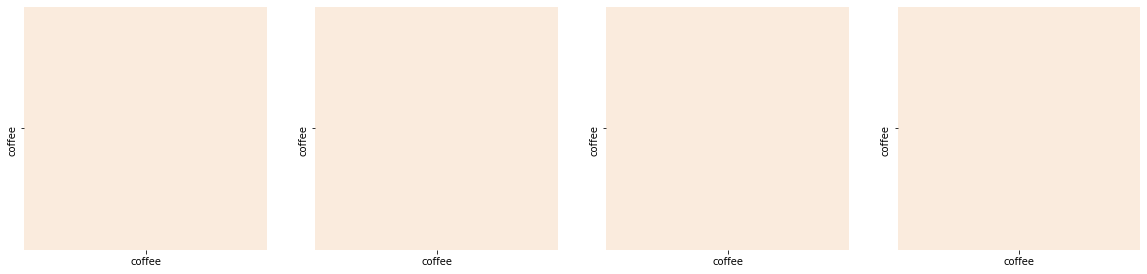

Decoder Src Layer 1


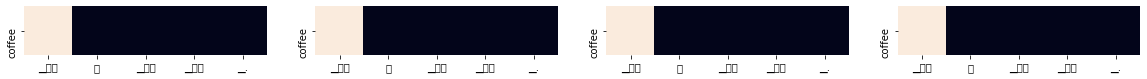

Decoder Self Layer 2


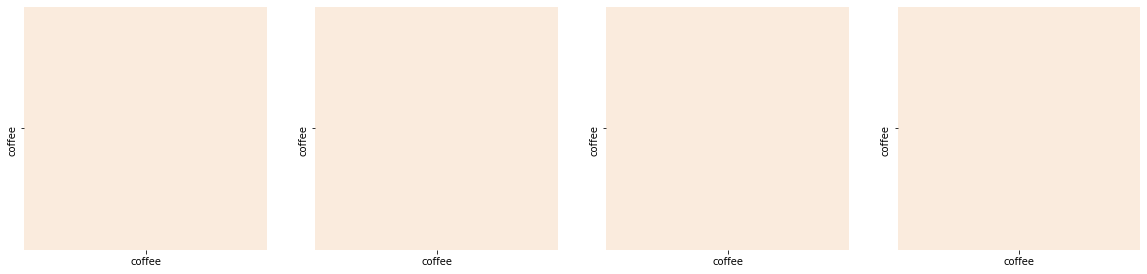

Decoder Src Layer 2


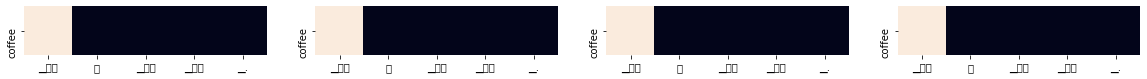

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilians have been killed .
Encoder Layer 1


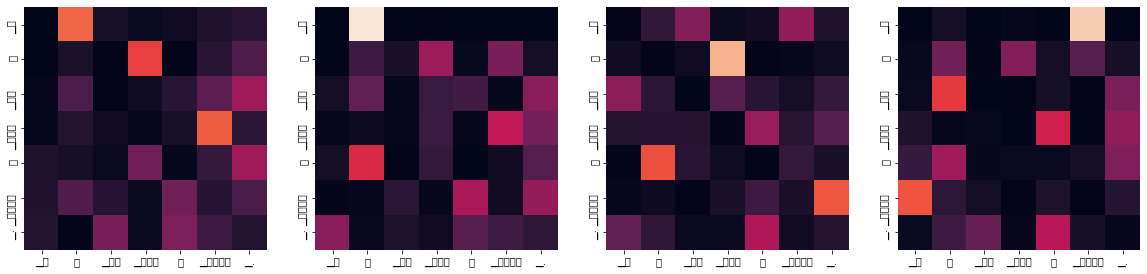

Encoder Layer 2


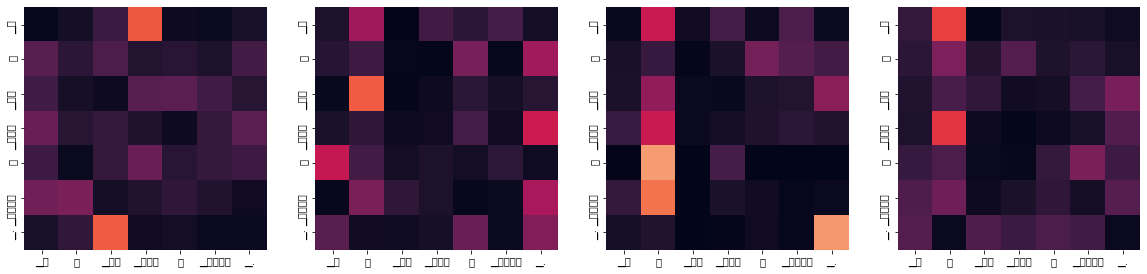

Decoder Self Layer 1


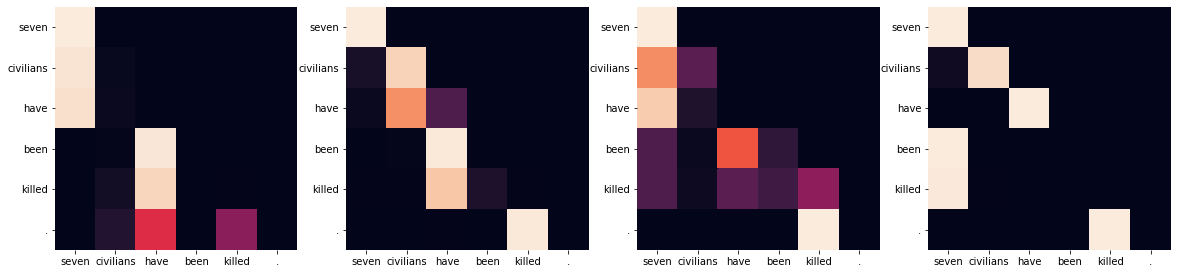

Decoder Src Layer 1


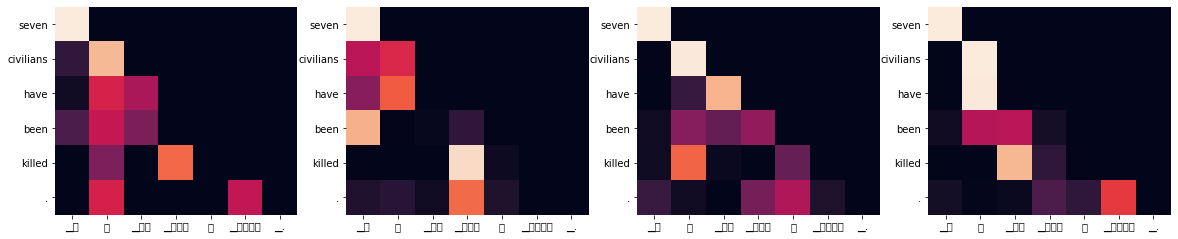

Decoder Self Layer 2


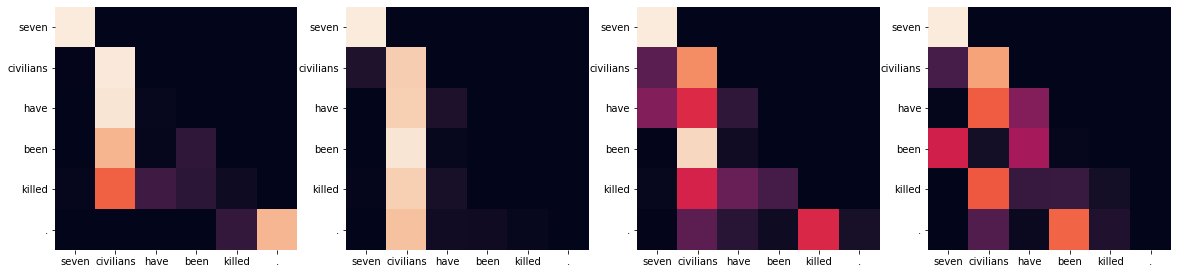

Decoder Src Layer 2


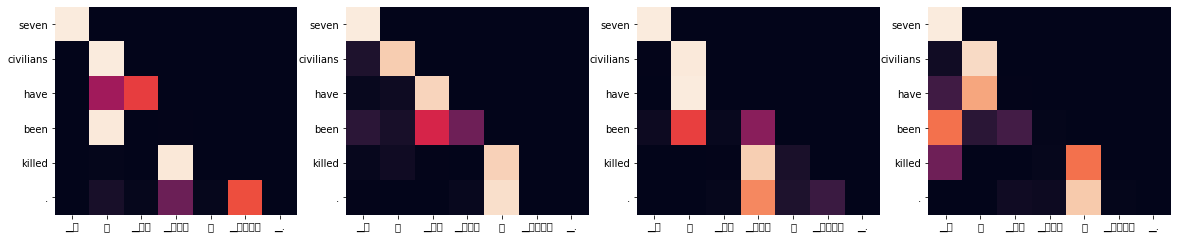

Epoch 12: 100%|██████████| 2127/2127 [08:06<00:00,  4.37it/s, Loss 0.4475]


Input: 오바마는 대통령이다.
Predicted translation: obama is the front runner .
Encoder Layer 1


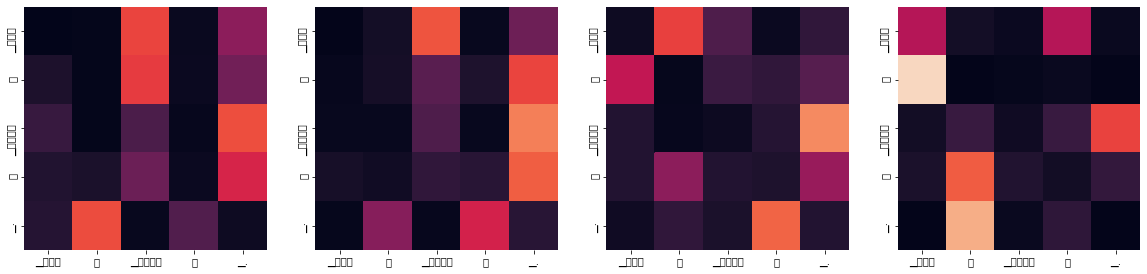

Encoder Layer 2


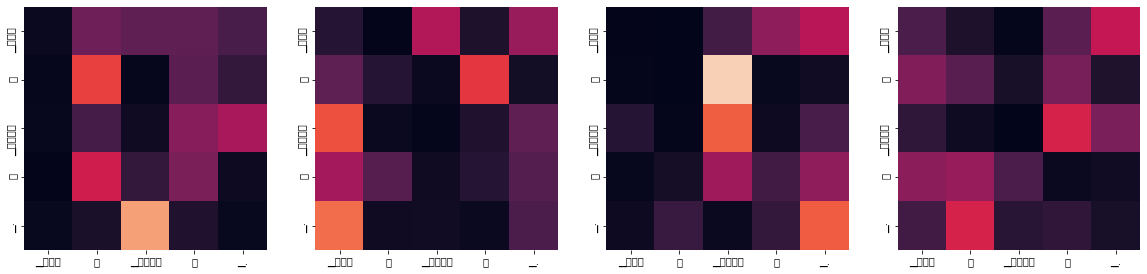

Decoder Self Layer 1


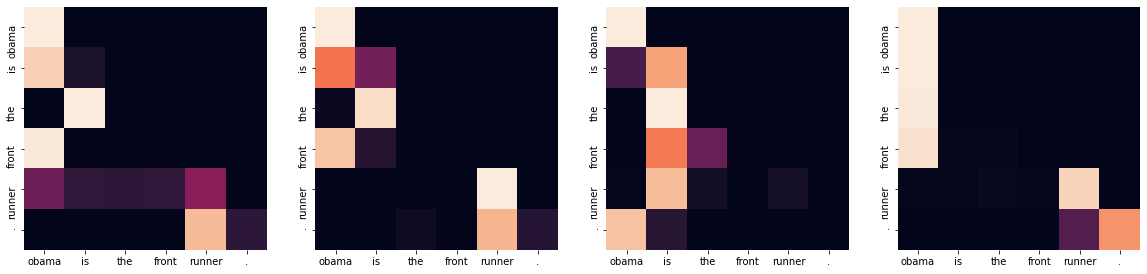

Decoder Src Layer 1


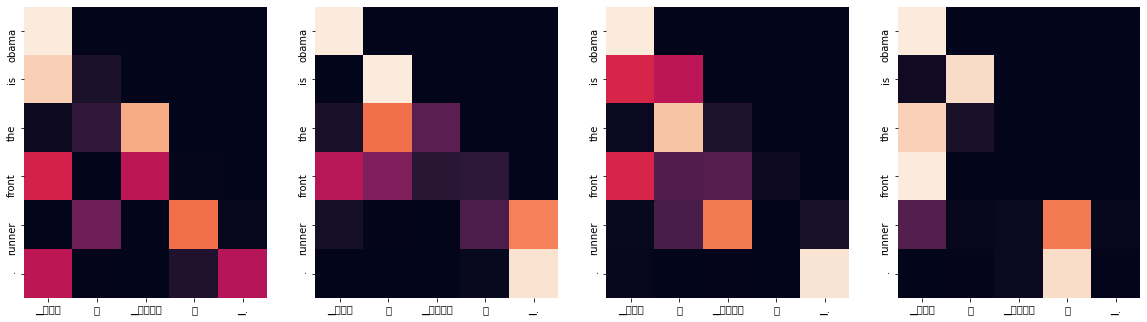

Decoder Self Layer 2


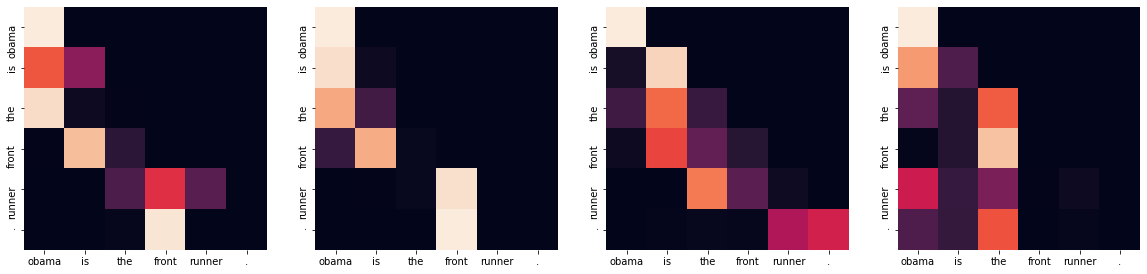

Decoder Src Layer 2


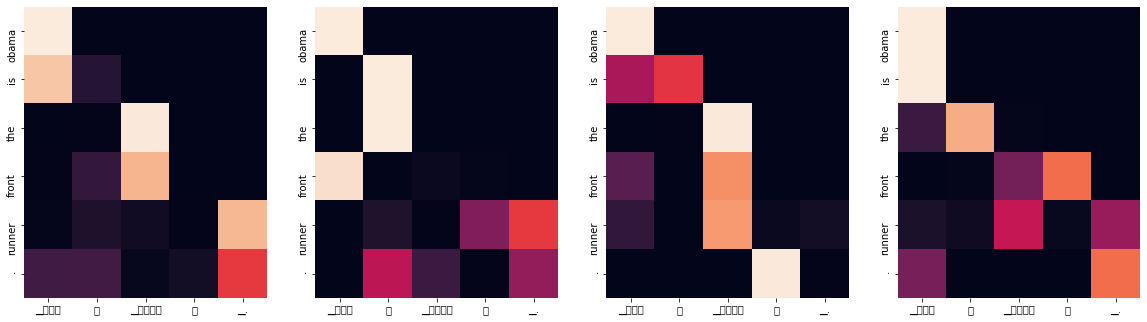

Input: 시민들은 도시 속에 산다.
Predicted translation: the b stop stop at live in the cities .
Encoder Layer 1


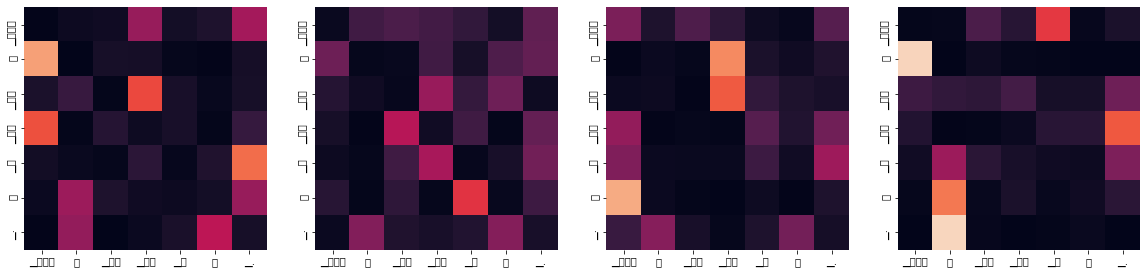

Encoder Layer 2


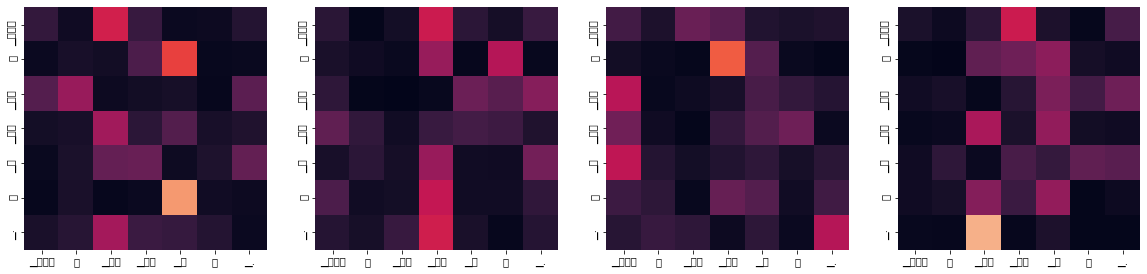

Decoder Self Layer 1


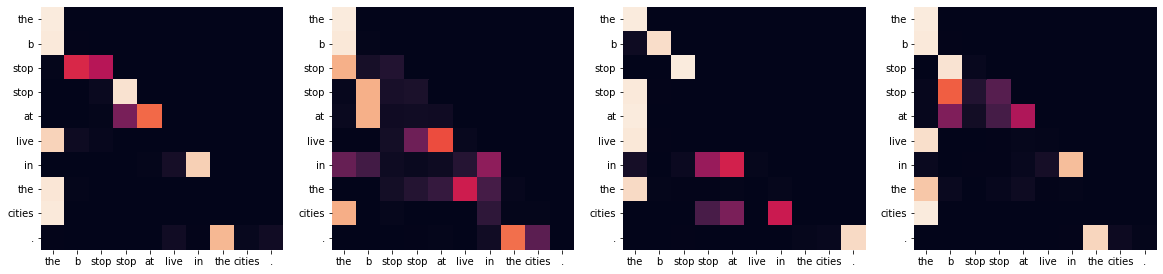

Decoder Src Layer 1


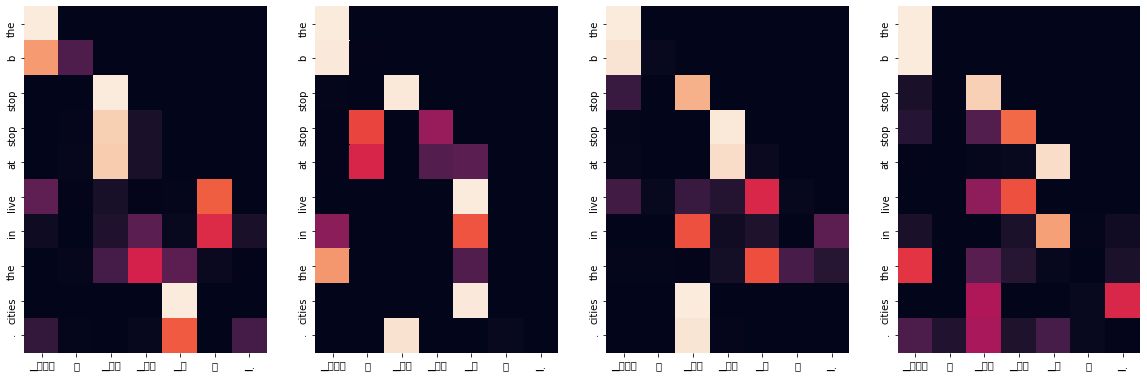

Decoder Self Layer 2


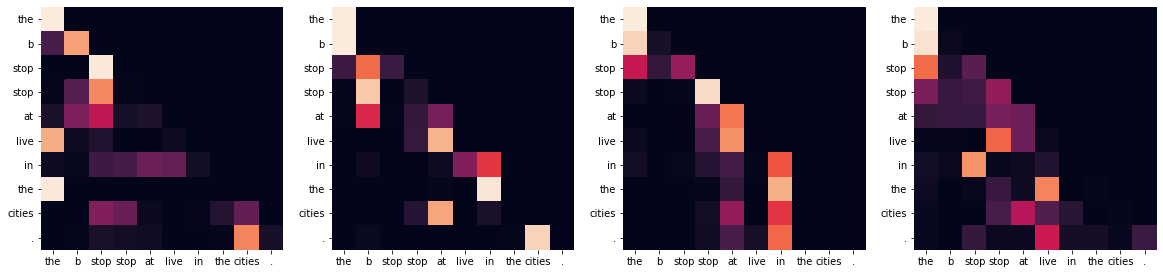

Decoder Src Layer 2


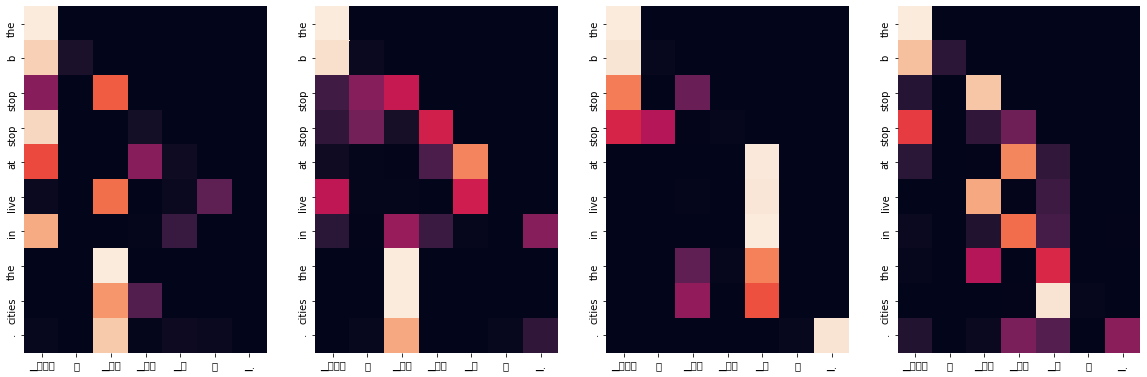

Input: 커피는 필요 없다.
Predicted translation: don t necessarily coffee at anything she needs .
Encoder Layer 1


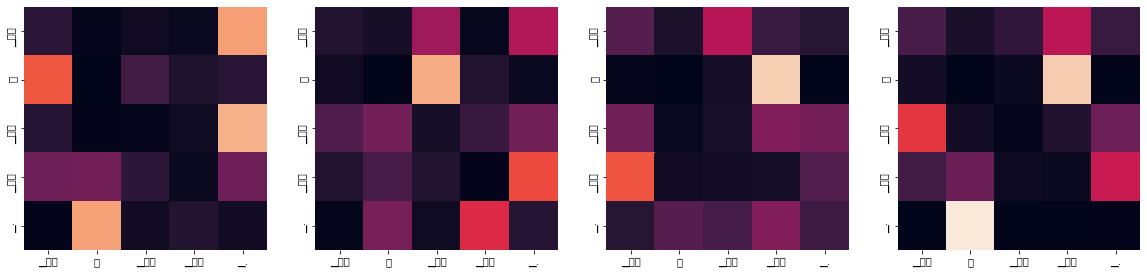

Encoder Layer 2


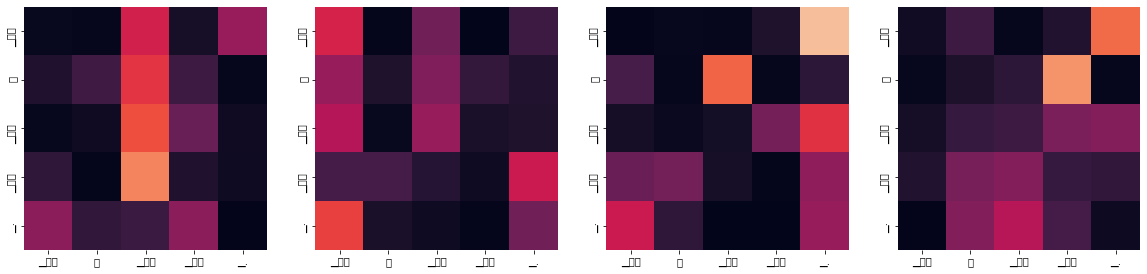

Decoder Self Layer 1


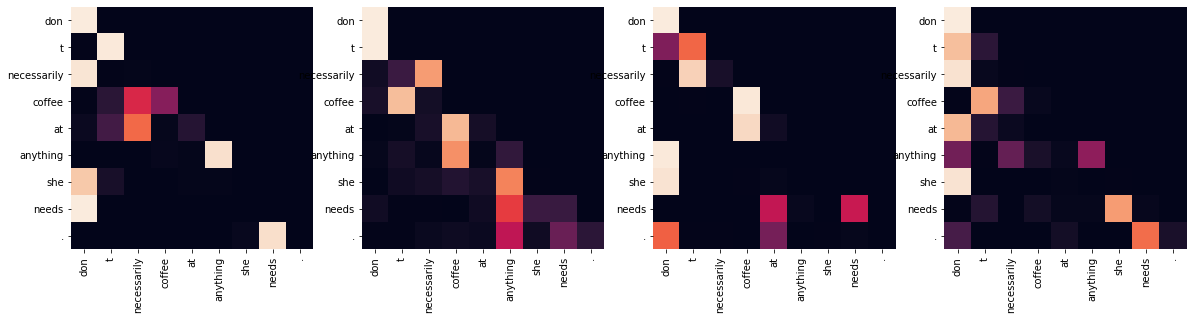

Decoder Src Layer 1


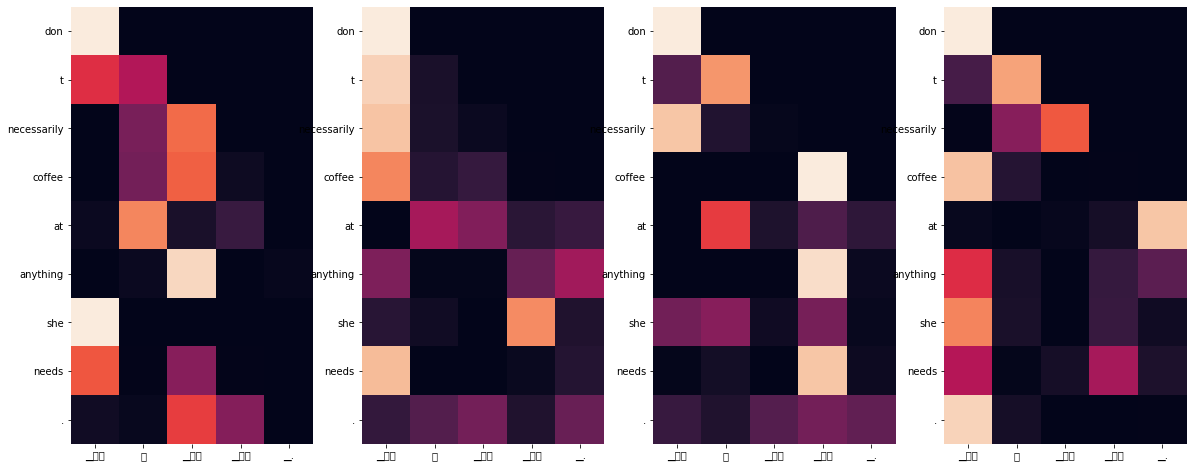

Decoder Self Layer 2


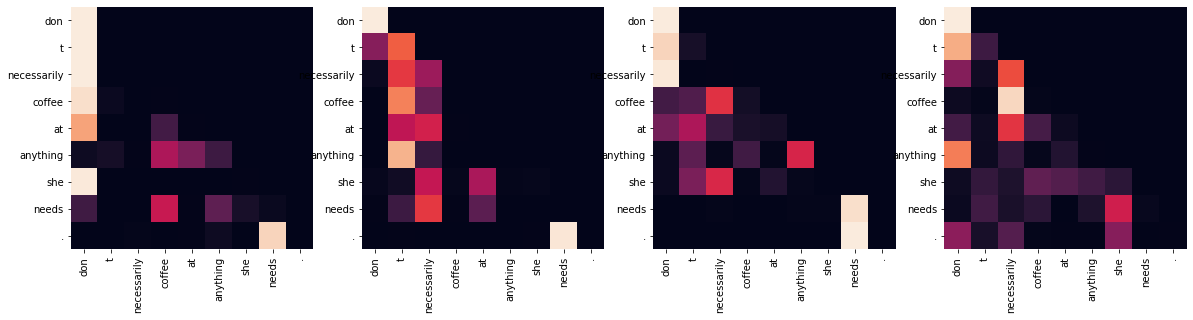

Decoder Src Layer 2


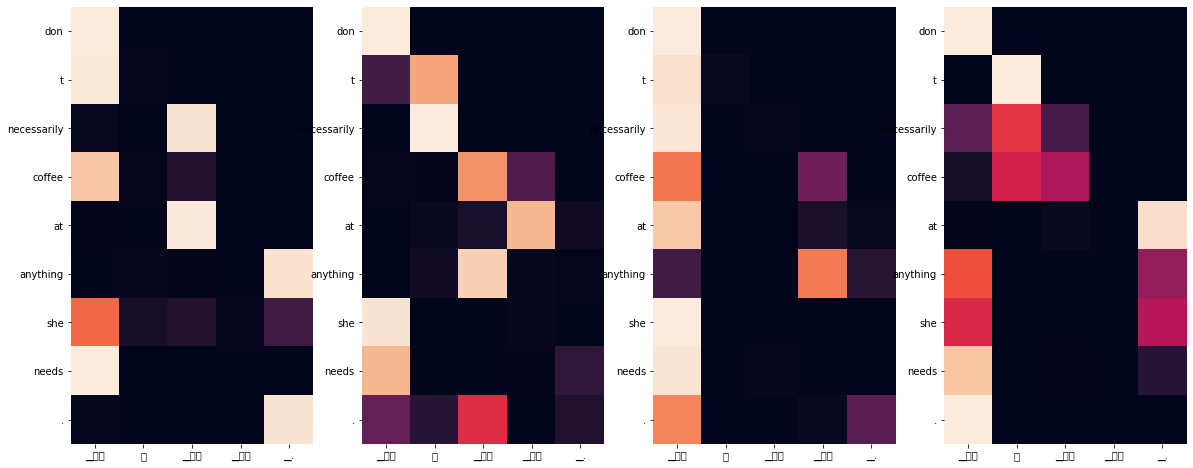

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilian people were killed .
Encoder Layer 1


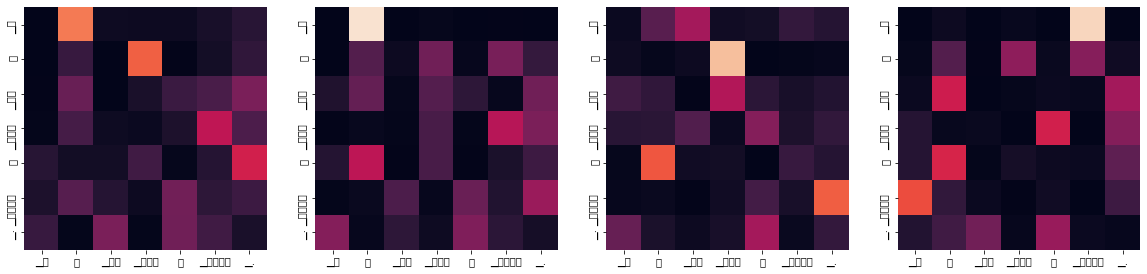

Encoder Layer 2


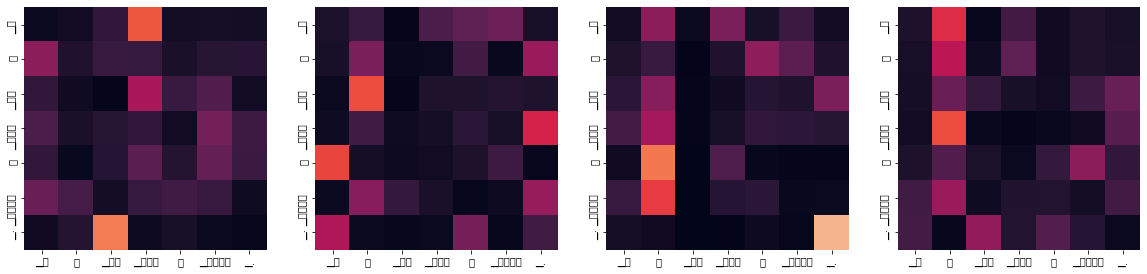

Decoder Self Layer 1


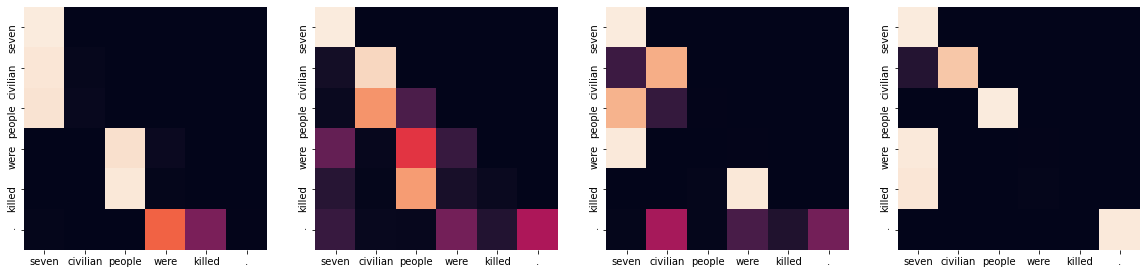

Decoder Src Layer 1


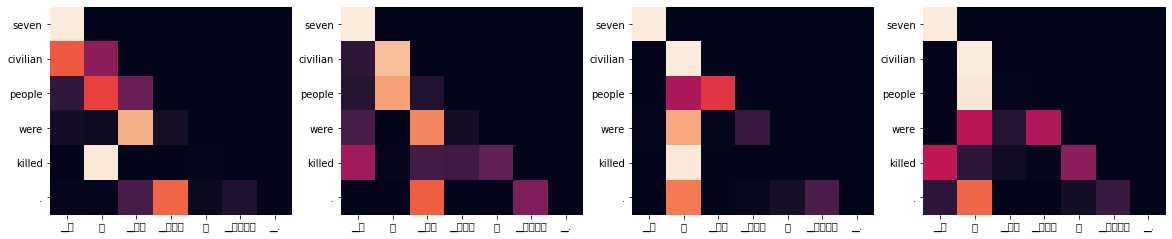

Decoder Self Layer 2


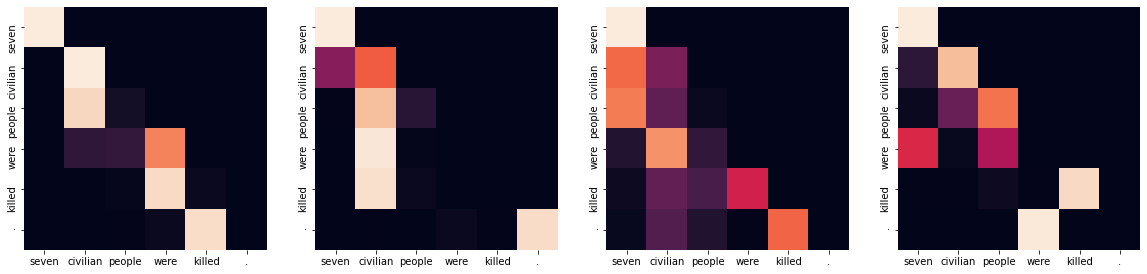

Decoder Src Layer 2


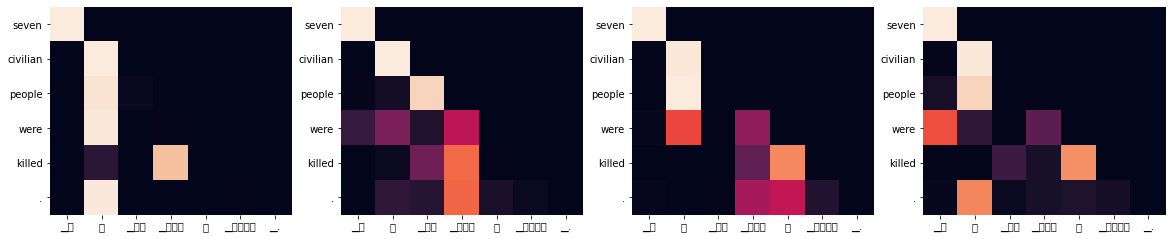

Epoch 13:  71%|███████   | 1514/2127 [05:45<02:22,  4.29it/s, Loss 0.3688]

In [ ]:
# 학습
EPOCHS = 20
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                     dec_train[idx:idx+BATCH_SIZE],
                                                                     transformer2,
                                                                     optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 매 Epoch 마다 제시된 예문에 대한 번역 생성
    for example in examples:
        translate(example, transformer2, ko_tokenizer, en_tokenizer, True)